#### **MA4282 - Kapita Selekta Statistika II**

## **Kode Program Tugas Besar**

Anggota Kelompok:

* Sekar Annasya Handayani (NIM. 10119001)
* Audri Utami Gunadi (NIM. 10119037)
* Alvero (NIM. 10119071)
* Saufi Chairunnisa (NIM. 10119098)
* Azeilla Raihan Putri Nurmawan (NIM. 10119108)
* Sarah Batrisyia Chalid (NIM. 10819044)


# *Function and Packages*

## *Packages* yang Digunakan

In [ ]:
!pip install mycolorpy
from tqdm import tqdm, trange

  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3851 sha256=06778ea9bac324b01a89b3963129244cea8f7df8658046e1b123fc852ec822e1
  Stored in directory: /root/.cache/pip/wheels/d6/1d/04/f8bfb8b04e3daba330b3f377c041b89304271ff98fb6704946
Successfully built mycolorpy


In [ ]:
import os
import sys
import datetime
from datetime import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter, NullLocator
from matplotlib import rcParams
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import ExpSineSquared
from mycolorpy import colorlist as mcp

In [ ]:
# normalisasi
# -----------
#
# fungsi untuk menstandarisasi data
def Standarisasi(dataframe) :

  rata_rata_list = []
  standar_deviasi_list = []
  dataframe_normalized = dataframe.copy(deep = True)

  for fitur in (dataframe_normalized.columns) :
    rata_rata = dataframe_normalized[fitur].mean()
    rata_rata_list.append(rata_rata)
    standar_deviasi = dataframe_normalized[fitur].std()
    standar_deviasi_list.append(standar_deviasi)
    dataframe_normalized[fitur] = (dataframe_normalized[fitur] - rata_rata)/standar_deviasi

  return(dataframe_normalized, rata_rata_list, standar_deviasi_list)

## Fungsi Kernel

### ARD

In [ ]:
# fungsi pembangun matriks kovariansi kernel
def Kernel_ARD(input_1, input_2, parameter, dimensi = None) :

  # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
  # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
  # sisa dari parameter adalah parameter bobot tiap fitur

  # jika dimensi tidak diberikan
  if dimensi == None:

    # mencoba menentukan dimensi dari input
    try:
      dimensi = input_1.shape[1]
      dimensi_2 = input_2.shape[1]

    # jika input bukan matriks 2D, ubah menjadi matriks 2D
    except:
      input_1 = np.array(input_1).reshape(-1,1)
      input_2 = np.array(input_2).reshape(-1,1)
      dimensi = input_1.shape[1]

  # mengecek apakah jumlah parameter sesuai dengan dimensi input
  if len(parameter) == dimensi + 1:

    # menyimpan parameter pertama sebagai parameter_a
    parameter_a = parameter[0]

    # inisialisasi matriks kernel menggunakan parameter_a
    kernel = np.exp(parameter_a) * np.ones([input_1.shape[0], input_2.shape[0]])

    # iterasi melalui setiap fitur dalam input
    for fitur in range(dimensi):
      # membuat matriks_x dengan mengulang input_1 sebanyak baris pada input_2
      matriks_x = np.array([input_1[:, fitur] for i in range(input_2.shape[0])]).T

      # membuat matriks_y dengan mengulang input_2 sebanyak baris pada input_1
      matriks_y = np.array([input_2[:, fitur] for i in range(input_1.shape[0])])

      # menghitung pengali dengan menggunakan parameter yang sesuai
      pengali = -1 * parameter[fitur + 1] * (matriks_x - matriks_y) * (matriks_x - matriks_y)

      # mengalikan matriks kernel dengan eksponensial dari pengali
      kernel = kernel * np.exp(pengali)

    return kernel

  else:
    # mengembalikan error jika jumlah parameter tidak sesuai
    raise ValueError("Banyak parameter tidak sama dengan dimensi input", len(parameter), dimensi, input_1.shape[1])

In [ ]:
# fungsi pembangun matriks yang diturunkan terhadap bobot fitur
def Turunan_fitur(input_1, input_2, parameter, fitur_ke, dimensi = None) :

  # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
  # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
  # sisa dari parameter adalah parameter bobot tiap fitur

  # jika dimensi tidak diberikan
  if dimensi == None:
    # mencoba menentukan dimensi dari input
    try:
        dimensi = input_1.shape[1]
        dimensi_2 = input_2.shape[1]
    # jika input bukan matriks 2D, ubah menjadi matriks 2D
    except:
        input_1 = np.array(input_1).reshape(-1, 1)
        input_2 = np.array(input_2).reshape(-1, 1)
        dimensi = input_1.shape[1]

  # mengecek apakah jumlah parameter sesuai dengan dimensi input
  if len(parameter) == dimensi + 1:

    # menyimpan parameter pertama sebagai parameter_a
    parameter_a = parameter[0]

    # inisialisasi matriks kernel menggunakan parameter_a
    kernel = np.exp(parameter_a) * np.ones([input_1.shape[0], input_2.shape[0]])

    # iterasi melalui setiap fitur dalam input
    for fitur in range(dimensi):
      # membuat matriks_x dengan mengulang input_1 sebanyak baris pada input_2
      matriks_x = np.array([input_1[:, fitur] for i in range(input_2.shape[0])], dtype=float).T

      # membuat matriks_y dengan mengulang input_2 sebanyak baris pada input_1
      matriks_y = np.array([input_2[:, fitur] for i in range(input_1.shape[0])], dtype=float)

      # menghitung pengali dengan menggunakan parameter yang sesuai
      pengali = -1 * parameter[fitur + 1] * (matriks_x - matriks_y) * (matriks_x - matriks_y)

      # mengalikan matriks kernel dengan eksponensial dari pengali
      kernel = kernel * np.exp(pengali)

      # jika fitur saat ini sama dengan fitur_ke, mengalikan kernel dengan (matriks_x - matriks_y)^2
      if fitur + 1 == fitur_ke:
        kernel = -1* kernel * (matriks_x - matriks_y) * (matriks_x - matriks_y)

    return kernel

### ESS (Exponential Sine Squared)

In [ ]:
# Fungsi pembangun matriks kovariansi kernel
def Kernel_ESS(input_1, input_2, parameter, dimensi = None) :

  # Bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
  # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
  # Sisa dari parameter adalah parameter bobot tiap fitur

  if dimensi == None :
    try :
      dimensi = input_1.shape[1]
      dimensi_2 = input_2.shape[1]

    except :
      input_1 = np.array(input_1).reshape(-1,1)
      input_2 = np.array(input_2).reshape(-1,1)

  if len(parameter) == 3 :
    parameter_a = parameter[0]
    kernel_ESS = np.exp(parameter_a)*ExpSineSquared(parameter[1],parameter[2])
    kernel = kernel_ESS.__call__(input_1,input_2)

    return(kernel)

  else :
    raise ValueError("Banyak parameter tidak sama dengan 3(tiga)")


In [ ]:
# Fungsi pembangun matriks turunan kernel
def Turunan_panjang(input_1, input_2, parameter, dimensi = None) :

  # Bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
  # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
  # Sisa dari parameter adalah parameter bobot tiap fitur

  if dimensi == None :
    try :
      dimensi = input_1.shape[1]
      dimensi_2 = input_2.shape[1]

    except :
      input_1 = np.array(input_1).reshape(-1,1)
      input_2 = np.array(input_2).reshape(-1,1)

  if len(parameter) == 3 :

    # Bikin matriks norm
    norm = np.zeros([input_1.shape[0],input_2.shape[0]])
    for data_2 in range(input_2.shape[0]) :
      matriks_baris = np.array([input_2[data_2] for  i in range(input_1.shape[0])]).reshape(-1,input_1.shape[1])
      norm[:,data_2]= np.linalg.norm(input_1 - matriks_baris, axis = 1)

    parameter_a = parameter[0]
    kernel_ESS = np.exp(parameter_a)*ExpSineSquared(parameter[1],parameter[2])
    kernel = kernel_ESS.__call__(input_1,input_2)
    kernel = kernel*(4/(parameter[1]**3))*np.power(np.sin(np.pi*norm/parameter[2]),2)


    return(kernel)

  else :
    raise ValueError("Banyak parameter tidak sama dengan 3(tiga)")


In [ ]:
# Fungsi pembangun matriks turunan kernel
def Turunan_periode(input_1, input_2, parameter, dimensi = None) :

  # Bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
  # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
  # Sisa dari parameter adalah parameter bobot tiap fitur

  if dimensi == None :
    try :
      dimensi = input_1.shape[1]
      dimensi_2 = input_2.shape[1]

    except :
      input_1 = np.array(input_1).reshape(-1,1)
      input_2 = np.array(input_2).reshape(-1,1)

  if len(parameter) == 3 :

    # Bikin matriks norm
    norm = np.zeros([input_1.shape[0],input_2.shape[0]])
    for data_2 in range(input_2.shape[0]) :
      matriks_baris = np.array([input_2[data_2] for  i in range(input_1.shape[0])]).reshape(-1,input_1.shape[1])
      norm[:,data_2]= np.linalg.norm(input_1 - matriks_baris, axis = 1)

    parameter_a = parameter[0]
    kernel_ESS = np.exp(parameter_a)*ExpSineSquared(parameter[1],parameter[2])
    kernel = kernel_ESS.__call__(input_1,input_2)
    kernel = kernel/((parameter[1]**2 * parameter[2]**2))*np.power(np.sin(2*np.pi*norm/parameter[2]),1)


    return(kernel)

  else :
    raise ValueError("Banyak parameter tidak sama dengan 3(tiga)")


In [ ]:
# Fungsi pembangun matriks turunan kovariansi kernel
def Turunan_ESS(input_1, input_2, parameter,parameter_ke, dimensi = None) :

  # Bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
  # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
  # Sisa dari parameter adalah parameter bobot tiap fitur

  if dimensi == None :
    try :
      dimensi = input_1.shape[1]
      dimensi_2 = input_2.shape[1]

    except :
      input_1 = np.array(input_1).reshape(-1,1)
      input_2 = np.array(input_2).reshape(-1,1)

  if len(parameter) == 3 :
    parameter_a = parameter[0]
    kernel_ESS = np.exp(parameter_a)*ExpSineSquared(parameter[1],parameter[2])
    turunan = kernel_ESS.__call__(input_1,eval_gradient = True)[1]
    kernel = np.array([turunan[i][:,parameter_ke] for i in range(input_1.shape[0])])

    return(kernel)

  else :
    raise ValueError("Banyak parameter tidak sama dengan 3(tiga)")


### ESS + ARD

In [ ]:
def Kernel_ESS_ARD(input_1,input_2,parameter, dimensi = None) :
  '''
  Parameter yang dimasukan berbentuk
  [sigma kuadrat ESS, panjang ESS, periode ESS, sigma kuadrat ARD, bobot ARD]
  '''

  if dimensi == None :
    try :
      dimensi = input_1.shape[1]
      dimensi_2 = input_2.shape[1]

    except :
      input_1 = np.array(input_1).reshape(-1,1)
      input_2 = np.array(input_2).reshape(-1,1)
      dimensi = input_1.shape[1]
      dimensi_2 = input_2.shape[1]

  if len(parameter) == input_1.shape[1] + 4 :

    parameter_ESS = np.array(parameter[0:3])
    parameter_ARD = np.array(parameter[3:])

    kernel = Kernel_ESS(input_1,input_2,parameter_ESS) + Kernel_ARD(input_1,input_2,parameter_ARD)

    return kernel

  else :
    raise ValueError("Parameter tidak berjumlah", dimensi+4)


### ESS + ARD independen

In [ ]:
def Kernel_ESS_ARD(input_1_ESS,input_2_ESS,input_1_ARD,input_2_ARD,parameter, dimensi = None) :
  '''
  Parameter yang dimasukan berbentuk
  [sigma kuadrat ESS, panjang ESS, periode ESS, sigma kuadrat ARD, bobot ARD]
  '''

  if dimensi == None :
    try:
      dimensi = input_1_ESS.shape[1]
      dimensi_2 = input_2_ESS.shape[1]
      dimensi_3 = input_1_ARD.shape[1]
      dimensi_4 = input_2_ARD.shape[1]

    except:
      input_1_ESS = np.array(input_1_ESS).reshape(-1,1)
      input_2_ESS = np.array(input_1_ESS).reshape(-1,1)
      input_1_ARD = np.array(input_1_ARD).reshape(-1,1)
      input_2_ARD = np.array(input_2_ARD).reshape(-1,1)
      dimensi = input_1_ESS.shape[1]
      dimensi_2 = input_2_ESS.shape[1]
      dimensi_3 = input_1_ARD.shape[1]
      dimensi_4 = input_2_ARD.shape[1]


  if len(parameter) == dimensi_3 + 4 :

    parameter_ESS = np.array(parameter[0:3])
    parameter_ARD = np.array(parameter[3:])

    kernel = Kernel_ESS(input_1_ESS,input_2_ESS,parameter_ESS) + Kernel_ARD(input_1_ARD,input_2_ARD,parameter_ARD)

    return kernel

  else :
    raise ValueError("Parameter tidak berjumlah", dimensi_3 + 4, dimensi_3, input_1_ARD.shape[1])


## Fungsi *Training*

Besar *gaussian noise* yang dipilih adalah 0.0001.

### ARD

In [ ]:
def Gaussian_Process_fitting_ARD(input, output, parameter, learning_rate, basis, batch_size = 1) :

  # fungsi untuk menghitung matriks Miu_n
  def Miu_ARD(input_1, parameter, dimensi = None):

    # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
    # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
    # sisa dari parameter adalah parameter bobot tiap fitur

    # mengakses variabel non-lokal dari fungsi utama
    nonlocal basis
    nonlocal M_n
    nonlocal S_n
    nonlocal K_n_invers

    # jika dimensi tidak diberikan, tentukan dimensi dari input
    if dimensi == None:
      try:
        dimensi = input_1.shape[1]

      except:
        input_1 = np.array(input_1).reshape(-1,1)
        dimensi = input_1.shape[1]

    # mengecek apakah jumlah parameter sesuai dengan dimensi input
    if len(parameter) == dimensi + 1:

      # menghitung vektor miu_n
      vektor = Kernel_ARD(input_1, basis, parameter) @ K_n_invers @ M_n

      return vektor

    else:
      raise ValueError("Banyak parameter tidak sama dengan dimensi input")


  # fungsi untuk menghitung matriks sigma_n
  def Sigma_ARD(input_1, input_2, parameter, dimensi = None):

    # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
    # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
    # sisa dari parameter adalah parameter bobot tiap fitur

    # mengakses variabel non-lokal dari fungsi utama
    nonlocal basis
    nonlocal M_n
    nonlocal S_n
    nonlocal K_n_invers

    # jika dimensi tidak diberikan, tentukan dimensi dari input
    if dimensi == None:
      try:
        dimensi = input_1.shape[1]
        dimensi_2 = input_2.shape[1]

      except:
        input_1 = np.array(input_1).reshape(-1,1)
        input_2 = np.array(input_2).reshape(-1,1)
        dimensi = input_1.shape[1]

    # mengecek apakah jumlah parameter sesuai dengan dimensi input
    if len(parameter) == dimensi + 1:

      # menghitung matriks sigma_n
      matriks = Kernel_ARD(input_1, input_2, parameter) - \
                Kernel_ARD(input_1, basis, parameter) @ K_n_invers @ Kernel_ARD(basis, input_2, parameter) + \
                Kernel_ARD(input_1, basis, parameter) @ K_n_invers @ S_n @ K_n_invers @ Kernel_ARD(basis, input_2, parameter)

      return matriks

    else :
      raise ValueError("Banyak parameter tidak sama dengan dimensi input")

  # fungsi untuk memprediksi nilai fungsi
  # fungsinya belum dipakai
  def Gaussian_Process_predict(input, M_n, S_n, parameter, basis) :

    Miu_predict = Miu_ARD(input, parameter)
    Sigma_predict = Sigma_ARD(input, input, parameter)

    return Miu_predict, Sigma_predict

  # mengubah format parameter ke numpy
  try:
    baris, kolom = parameter.shape

  except:
    parameter = np.array(parameter, dtype = float)

  # inisialisasi distribusi prior
  M_n = np.array([0 for i in range(len(basis))]).reshape(-1,1)
  S_n = Kernel_ARD(basis,basis,parameter)

  # Inisialisasi warna untuk plotting
  warna = mcp.gen_color(cmap = 'Spectral', n = len(parameter) + 1)

  loading_bar = trange(0,input.shape[0],batch_size, desc = "Fitting ARD")
  for data in loading_bar :
    try :
      indeks = np.arange(data, data + batch_size)
      batch = input[indeks]

    except :
      indeks = np.arange(data,input.shape[0])
      batch = input[data:]

    # inisialisasi matriks kernel awal
    Matriks_K_n = Kernel_ARD(basis,basis,parameter) + 0.01*np.identity(len(basis))
    K_n_invers = np.linalg.inv(Matriks_K_n)

    Sigma_observasi_observasi = Sigma_ARD(batch, batch, parameter) + 0.01*np.identity(batch.shape[0])
    Sigma_observasi_invers = np.linalg.inv(Sigma_observasi_observasi)

    # update M_n
    M_n = M_n + Sigma_ARD(basis, batch, parameter) @ Sigma_observasi_invers @ (output[indeks].reshape(-1,1) - Miu_ARD(batch, parameter) )

    # update S_n
    S_n = Sigma_ARD(basis,basis, parameter) - \
          Sigma_ARD(basis,batch,parameter) @  Sigma_observasi_invers @ Sigma_ARD(batch,basis,parameter)

    # update hyperparameter (theta_n)

    # buat tempat penyimpanan parameter lama
    parameter_lama = np.copy(parameter)

    for fitur in range(len(parameter)):
      if fitur == 0:
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Matriks_K_n
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
        plt.plot(data,parameter[fitur], 'o', color = warna[fitur])
      else:
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Turunan_fitur(basis, basis, parameter, fitur)
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
        plt.plot(data,parameter[fitur], 'o', color = warna[fitur])

    # Hitung galat dari vektor parameter
    galat = np.linalg.norm(parameter - parameter_lama)

  print('')
  print("Galat terakhir sebesar ", galat)
  return(M_n, S_n, parameter)

### ARD Randomized

In [ ]:
def Gaussian_Process_fitting_ARD_Randomized(input, output, parameter, learning_rate, basis, batch_size = 1, iterasi = 50000, galat_max = 1e-5) :

  # fungsi untuk menghitung matriks Miu_n
  def Miu_ARD(input_1, parameter, dimensi = None):

    # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
    # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
    # sisa dari parameter adalah parameter bobot tiap fitur

    # mengakses variabel non-lokal dari fungsi utama
    nonlocal basis
    nonlocal M_n
    nonlocal S_n
    nonlocal K_n_invers

    # jika dimensi tidak diberikan, tentukan dimensi dari input
    if dimensi == None:
      try:
        dimensi = input_1.shape[1]

      except:
        input_1 = np.array(input_1).reshape(-1,1)
        dimensi = input_1.shape[1]

    # mengecek apakah jumlah parameter sesuai dengan dimensi input
    if len(parameter) == dimensi + 1:

      # menghitung vektor miu_n
      vektor = Kernel_ARD(input_1, basis, parameter) @ K_n_invers @ M_n

      return vektor

    else:
      raise ValueError("Banyak parameter tidak sama dengan dimensi input")


  # fungsi untuk menghitung matriks sigma_n
  def Sigma_ARD(input_1, input_2, parameter, dimensi = None):

    # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
    # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
    # sisa dari parameter adalah parameter bobot tiap fitur

    # mengakses variabel non-lokal dari fungsi utama
    nonlocal basis
    nonlocal M_n
    nonlocal S_n
    nonlocal K_n_invers

    # jika dimensi tidak diberikan, tentukan dimensi dari input
    if dimensi == None:
      try:
        dimensi = input_1.shape[1]
        dimensi_2 = input_2.shape[1]

      except:
        input_1 = np.array(input_1).reshape(-1,1)
        input_2 = np.array(input_2).reshape(-1,1)
        dimensi = input_1.shape[1]

    # mengecek apakah jumlah parameter sesuai dengan dimensi input
    if len(parameter) == dimensi + 1:

      # menghitung matriks sigma_n
      matriks = Kernel_ARD(input_1, input_2, parameter) - \
                Kernel_ARD(input_1, basis, parameter) @ K_n_invers @ Kernel_ARD(basis, input_2, parameter) + \
                Kernel_ARD(input_1, basis, parameter) @ K_n_invers @ S_n @ K_n_invers @ Kernel_ARD(basis, input_2, parameter)

      return matriks

    else :
      raise ValueError("Banyak parameter tidak sama dengan dimensi input")

  # mengubah format parameter ke numpy
  try:
    baris, kolom = parameter.shape

  except:
    parameter = np.array(parameter, dtype = float)

  # inisialisasi distribusi prior
  M_n = np.array([0 for i in range(len(basis))]).reshape(-1,1)
  S_n = Kernel_ARD(basis,basis,parameter)

  # Inisialisasi warna untuk plotting
  warna = mcp.gen_color(cmap = 'Spectral', n = len(parameter) + 1)

  loading_bar = trange(0,iterasi,1, desc = "Fitting ARD")

  for data in loading_bar :

  # Mengambil sampel sembarang dari data train
    try :
      indeks = np.random.choice(input.shape[0], batch_size, replace=False)
      batch = input[indeks, :]

    except :
      raise ValueError("Sampel bermasalah")

    # inisialisasi matriks kernel awal
    Matriks_K_n = Kernel_ARD(basis,basis,parameter) + 0.01*np.identity(len(basis))
    K_n_invers = np.linalg.inv(Matriks_K_n)

    Sigma_observasi_observasi = Sigma_ARD(batch, batch, parameter) + 0.01*np.identity(batch_size)
    Sigma_observasi_invers = np.linalg.inv(Sigma_observasi_observasi)

    # update M_n
    M_n = M_n + Sigma_ARD(basis, batch, parameter) @ Sigma_observasi_invers @ (np.array(output[indeks]).reshape(-1,1) - Miu_ARD(batch, parameter) )

    # update S_n
    S_n = Sigma_ARD(basis,basis, parameter) - \
          Sigma_ARD(basis,batch,parameter) @  Sigma_observasi_invers @ Sigma_ARD(batch,basis,parameter)

    # update hyperparameter (theta_n)

    # buat tempat penyimpanan parameter lama
    parameter_lama = np.copy(parameter)

    for fitur in range(len(parameter)):
      if fitur == 0:
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Matriks_K_n
        #print("fitur 0", (1/2)*learning_rate*np.trace(Matriks_turunan))
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
        plt.plot(data,parameter[fitur], 'o', color = warna[fitur])
      else:
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Turunan_fitur(basis, basis, parameter, fitur)
        #print("fitur 1", (1/2)*learning_rate*np.trace(Matriks_turunan))
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
        plt.plot(data,parameter[fitur], 'o', color = warna[fitur])

    #print(parameter)
    # Hitung galat dari vektor parameter
    galat = np.linalg.norm(parameter - parameter_lama)
#    if galat < galat_max :
#     print("sudah cukup konvergen")
#    break

  print('')
  print("Galat terakhir sebesar ", galat)
  return(M_n, S_n, parameter)

### ESS

In [ ]:
def Gaussian_Process_fitting_ESS(input, output, parameter, learning_rate, basis, batch_size = 1) :

  # fungsi untuk menghitung matriks Miu_n
  def Miu_ESS(input_1, parameter, dimensi = None):

    # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
    # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
    # sisa dari parameter adalah parameter bobot tiap fitur

    # mengakses variabel non-lokal dari fungsi utama
    nonlocal basis
    nonlocal M_n
    nonlocal S_n
    nonlocal K_n_invers

    # jika dimensi tidak diberikan, tentukan dimensi dari input
    if dimensi == None:
      try:
        dimensi = input_1.shape[1]

      except:
        input_1 = np.array(input_1).reshape(-1,1)
        dimensi = input_1.shape[1]

    # mengecek apakah jumlah parameter sesuai dengan dimensi input
    if len(parameter) == 3:

      # menghitung vektor miu_n
      vektor = Kernel_ESS(input_1, basis, parameter) @ K_n_invers @ M_n

      return vektor

    else:
      raise ValueError("Banyak parameter tidak sama dengan dimensi input")


  # fungsi untuk menghitung matriks sigma_n
  def Sigma_ESS(input_1, input_2, parameter, dimensi = None):

    # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
    # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
    # sisa dari parameter adalah parameter bobot tiap fitur

    # mengakses variabel non-lokal dari fungsi utama
    nonlocal basis
    nonlocal M_n
    nonlocal S_n
    nonlocal K_n_invers

    # jika dimensi tidak diberikan, tentukan dimensi dari input
    if dimensi == None:
      try:
        dimensi = input_1.shape[1]
        dimensi_2 = input_2.shape[1]

      except:
        input_1 = np.array(input_1).reshape(-1,1)
        input_2 = np.array(input_2).reshape(-1,1)
        dimensi = input_1.shape[1]

    # mengecek apakah jumlah parameter sesuai dengan dimensi input
    if len(parameter) == 3:

      # menghitung matriks sigma_n
      matriks = Kernel_ESS(input_1, input_2, parameter) - \
                Kernel_ESS(input_1, basis, parameter) @ K_n_invers @ Kernel_ESS(basis, input_2, parameter) + \
                Kernel_ESS(input_1, basis, parameter) @ K_n_invers @ S_n @ K_n_invers @ Kernel_ESS(basis, input_2, parameter)

      return matriks

    else :
      raise ValueError("Banyak parameter tidak sama dengan dimensi input")

  # fungsi untuk memprediksi nilai fungsi
  # fungsinya belum dipakai
  def Gaussian_Process_predict(input, M_n, S_n, parameter, basis) :

    Miu_predict = Miu_ESS(input, parameter)
    Sigma_predict = Sigma_ESS(input, input, parameter)

    return Miu_predict, Sigma_predict

  # mengubah format parameter ke numpy
  try:
    baris, kolom = parameter.shape

  except:
    parameter = np.array(parameter, dtype = float)

  # inisialisasi distribusi prior
  M_n = np.array([0 for i in range(len(basis))]).reshape(-1,1)
  S_n = Kernel_ESS(basis,basis,parameter)



  loading_bar = trange(0,input.shape[0],batch_size, desc = "Fitting ESS")
  for data in loading_bar :
    try :
      batch = input[data:data+batch_size]

    except :
      batch = input[data:]

    # inisialisasi matriks kernel awal
    Matriks_K_n = Kernel_ESS(basis,basis,parameter) + 0.01*np.identity(len(basis))
    K_n_invers = np.linalg.inv(Matriks_K_n)

    Sigma_observasi_observasi = Sigma_ESS(batch, batch, parameter) + 0.01*np.identity(batch.shape[0])
    Sigma_observasi_invers = np.linalg.inv(Sigma_observasi_observasi)

    # update M_n
    M_n = M_n + Sigma_ESS(basis, batch, parameter) @ Sigma_observasi_invers @ (output[data] - Miu_ESS(batch, parameter) )

    # update S_n
    S_n = Sigma_ESS(basis,basis, parameter) - \
          Sigma_ESS(basis,batch,parameter) @  Sigma_observasi_invers @ Sigma_ESS(batch,basis,parameter)

    # update hyperparameter (theta_n)

    # buat tempat penyimpanan parameter lama
    parameter_lama = np.copy(parameter)

    for fitur in range(len(parameter)):
      if fitur == 0 :
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Matriks_K_n
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
      elif fitur == 1 :
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Turunan_panjang(basis, basis, parameter, fitur)
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
      else:
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Turunan_periode(basis, basis, parameter, fitur)
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)

    # Hitung galat dari vektor parameter
    galat = np.linalg.norm(parameter - parameter_lama)

  print('')
  print("Galat terakhir sebesar ", galat)
  return(M_n, S_n, parameter)

### ESS Randomized

In [ ]:
def Gaussian_Process_fitting_ESS_Randomized(input, output, parameter, learning_rate, basis, batch_size = 1, iterasi = 50000, galat_max = 1e-5) :

  # fungsi untuk menghitung matriks Miu_n
  def Miu_ESS(input_1, parameter, dimensi = None):

    # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
    # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
    # sisa dari parameter adalah parameter bobot tiap fitur

    # mengakses variabel non-lokal dari fungsi utama
    nonlocal basis
    nonlocal M_n
    nonlocal S_n
    nonlocal K_n_invers

    # jika dimensi tidak diberikan, tentukan dimensi dari input
    if dimensi == None:
      try:
        dimensi = input_1.shape[1]

      except:
        input_1 = np.array(input_1).reshape(-1,1)
        dimensi = input_1.shape[1]

    # mengecek apakah jumlah parameter sesuai dengan dimensi input
    if len(parameter) == 3:

      # menghitung vektor miu_n
      vektor = Kernel_ESS(input_1, basis, parameter) @ K_n_invers @ M_n

      return vektor

    else:
      raise ValueError("Banyak parameter tidak sama dengan dimensi input")


  # fungsi untuk menghitung matriks sigma_n
  def Sigma_ESS(input_1, input_2, parameter, dimensi = None):

    # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
    # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
    # sisa dari parameter adalah parameter bobot tiap fitur

    # mengakses variabel non-lokal dari fungsi utama
    nonlocal basis
    nonlocal M_n
    nonlocal S_n
    nonlocal K_n_invers

    # jika dimensi tidak diberikan, tentukan dimensi dari input
    if dimensi == None:
      try:
        dimensi = input_1.shape[1]
        dimensi_2 = input_2.shape[1]

      except:
        input_1 = np.array(input_1).reshape(-1,1)
        input_2 = np.array(input_2).reshape(-1,1)
        dimensi = input_1.shape[1]

    # mengecek apakah jumlah parameter sesuai dengan dimensi input
    if len(parameter) == 3:

      # menghitung matriks sigma_n
      matriks = Kernel_ESS(input_1, input_2, parameter) - \
                Kernel_ESS(input_1, basis, parameter) @ K_n_invers @ Kernel_ESS(basis, input_2, parameter) + \
                Kernel_ESS(input_1, basis, parameter) @ K_n_invers @ S_n @ K_n_invers @ Kernel_ESS(basis, input_2, parameter)

      return matriks

    else :
      raise ValueError("Banyak parameter tidak sama dengan dimensi input")

  # mengubah format parameter ke numpy
  try:
    baris, kolom = parameter.shape

  except:
    parameter = np.array(parameter, dtype = float)

  # inisialisasi distribusi prior
  M_n = np.array([0 for i in range(len(basis))]).reshape(-1,1)
  S_n = Kernel_ESS(basis,basis,parameter)

  # Inisialisasi warna untuk plotting
  warna = mcp.gen_color(cmap = 'Spectral', n = len(parameter) + 1)

  loading_bar = trange(0,iterasi,1, desc = "Fitting ESS")

  for data in loading_bar :

  # Mengambil sampel sembarang dari data train
    try :
      indeks = np.random.choice(input.shape[0], batch_size, replace=False)
      batch = input[indeks, :]

    except :
      raise ValueError("Sampel bermasalah")

    # inisialisasi matriks kernel awal
    Matriks_K_n = Kernel_ESS(basis,basis,parameter) + 0.01*np.identity(len(basis))
    K_n_invers = np.linalg.inv(Matriks_K_n)

    Sigma_observasi_observasi = Sigma_ESS(batch, batch, parameter) + 0.01*np.identity(batch_size)
    Sigma_observasi_invers = np.linalg.inv(Sigma_observasi_observasi)

    # update M_n
    M_n = M_n + Sigma_ESS(basis, batch, parameter) @ Sigma_observasi_invers @ (output[indeks].reshape(-1,1) - Miu_ESS(batch, parameter) )

    # update S_n
    S_n = Sigma_ESS(basis,basis, parameter) - \
          Sigma_ESS(basis,batch,parameter) @  Sigma_observasi_invers @ Sigma_ESS(batch,basis,parameter)

    # update hyperparameter (theta_n)

    # buat tempat penyimpanan parameter lama
    parameter_lama = np.copy(parameter)

    for fitur in range(len(parameter)):
      if fitur == 0 :
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Matriks_K_n
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
        plt.plot(data,parameter[fitur], 'o', color = warna[fitur])
      elif fitur == 1 :
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Turunan_panjang(basis, basis, parameter, fitur)
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
        plt.plot(data,parameter[fitur], 'o', color = warna[fitur])
      else:
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Turunan_periode(basis, basis, parameter, fitur)
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
        plt.plot(data,parameter[fitur], 'o', color = warna[fitur])

    # Hitung galat dari vektor parameter
    galat = np.linalg.norm(parameter - parameter_lama)

  print('')
  print("Galat terakhir sebesar ", galat)
  return(M_n, S_n, parameter)

### ESS + ARD


In [ ]:
def Gaussian_Process_fitting_ESS_ARD(input, output, parameter, learning_rate, basis, batch_size = 1) :

  '''
  Parameter yang dimasukan berbentuk
  [sigma kuadrat ESS_ARD, panjang ESS_ARD, periode ESS_ARD, sigma kuadrat ARD, bobot ARD]
  '''

  # fungsi untuk menghitung matriks Miu_n
  def Miu_ESS_ARD(input_1, parameter, dimensi = None):

    # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
    # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
    # sisa dari parameter adalah parameter bobot tiap fitur

    # mengakses variabel non-lokal dari fungsi utama
    nonlocal basis
    nonlocal M_n
    nonlocal S_n
    nonlocal K_n_invers

    # jika dimensi tidak diberikan, tentukan dimensi dari input
    if dimensi == None:
      try:
        dimensi = input_1.shape[1]

      except:
        input_1 = np.array(input_1).reshape(-1,1)
        dimensi = input_1.shape[1]

    # mengecek apakah jumlah parameter sesuai dengan dimensi input
    if len(parameter) == dimensi + 4:

      # menghitung vektor miu_n
      vektor = Kernel_ESS_ARD(input_1, basis, parameter) @ K_n_invers @ M_n

      return vektor

    else:
      raise ValueError("Banyak parameter tidak sama dengan dimensi input")


  # fungsi untuk menghitung matriks sigma_n
  def Sigma_ESS_ARD(input_1, input_2, parameter, dimensi = None):

    # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
    # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
    # sisa dari parameter adalah parameter bobot tiap fitur

    # mengakses variabel non-lokal dari fungsi utama
    nonlocal basis
    nonlocal M_n
    nonlocal S_n
    nonlocal K_n_invers

    # jika dimensi tidak diberikan, tentukan dimensi dari input
    if dimensi == None:
      try:
        dimensi = input_1.shape[1]
        dimensi_2 = input_2.shape[1]

      except:
        input_1 = np.array(input_1).reshape(-1,1)
        input_2 = np.array(input_2).reshape(-1,1)
        dimensi = input_1.shape[1]

    # mengecek apakah jumlah parameter sesuai dengan dimensi input
    if len(parameter) == dimensi + 4:

      # menghitung matriks sigma_n
      matriks = Kernel_ESS_ARD(input_1, input_2, parameter) - \
                Kernel_ESS_ARD(input_1, basis, parameter) @ K_n_invers @ Kernel_ESS_ARD(basis, input_2, parameter) + \
                Kernel_ESS_ARD(input_1, basis, parameter) @ K_n_invers @ S_n @ K_n_invers @ Kernel_ESS_ARD(basis, input_2, parameter)

      return matriks

    else :
      raise ValueError("Banyak parameter tidak sama dengan dimensi input")

  # fungsi untuk memprediksi nilai fungsi
  # fungsinya belum dipakai
  def Gaussian_Process_predict(input, M_n, S_n, parameter, basis) :

    Miu_predict = Miu_ESS_ARD(input, parameter)
    Sigma_predict = Sigma_ESS_ARD(input, input, parameter)

    return Miu_predict, Sigma_predict

  # mengubah format parameter ke numpy
  try:
    baris, kolom = parameter.shape

  except:
    parameter = np.array(parameter, dtype = float)

  # inisialisasi distribusi prior
  M_n = np.array([0 for i in range(len(basis))]).reshape(-1,1)
  S_n = Kernel_ESS_ARD(basis,basis,parameter)



  loading_bar = trange(0,input.shape[0],batch_size, desc = "Fitting ESS_ARD")
  for data in loading_bar :
    try :
      batch = input[data:data+batch_size]

    except :
      batch = input[data:]

    # inisialisasi matriks kernel awal
    Matriks_K_n = Kernel_ESS_ARD(basis,basis,parameter) + 0.01*np.identity(len(basis))
    K_n_invers = np.linalg.inv(Matriks_K_n)

    Sigma_observasi_observasi = Sigma_ESS_ARD(batch, batch, parameter) + 0.01*np.identity(batch.shape[0])
    Sigma_observasi_invers = np.linalg.inv(Sigma_observasi_observasi)

    # update M_n
    M_n = M_n + Sigma_ESS_ARD(basis, batch, parameter) @ Sigma_observasi_invers @ (output[data] - Miu_ESS_ARD(batch, parameter) )

    # update S_n
    S_n = Sigma_ESS_ARD(basis,basis,parameter) - \
          Sigma_ESS_ARD(basis,batch,parameter) @  Sigma_observasi_invers @ Sigma_ESS_ARD(batch,basis,parameter)

    # update hyperparameter (theta_n)

    # buat tempat penyimpanan parameter lama
    parameter_lama = np.copy(parameter)

    for fitur in range(len(parameter)):
      if fitur == 0 :
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Kernel_ESS(basis,basis,parameter[0:3])
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
      elif fitur == 1 :
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Turunan_panjang(basis, basis, parameter[0:3], fitur)
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
      elif fitur == 2:
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Turunan_periode(basis, basis, parameter[0:3], fitur)
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
      elif fitur == 3 :
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Kernel_ARD(basis, basis, parameter[3:])
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
      else :
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Turunan_fitur(basis, basis, parameter[3:], fitur)
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)


    # Hitung galat dari vektor parameter
    galat = np.linalg.norm(parameter - parameter_lama)

  print('')
  print("Galat terakhir sebesar ", galat)
  return(M_n, S_n, parameter)

### ESS + ARD independen

In [ ]:
def Gaussian_Process_fitting_ESS_ARD(input_ESS, input_ARD, output, parameter, learning_rate, basis_ESS, basis_ARD, batch_size = 1) :

  '''
  Parameter yang dimasukan berbentuk
  [sigma kuadrat ESS_ARD, panjang ESS_ARD, periode ESS_ARD, sigma kuadrat ARD, bobot ARD]
  '''

  # fungsi untuk menghitung matriks Miu_n
  def Miu_ESS_ARD(input_1_ESS, input_1_ARD, parameter, dimensi = None):

    # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
    # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
    # sisa dari parameter adalah parameter bobot tiap fitur

    # mengakses variabel non-lokal dari fungsi utama
    nonlocal basis_ESS
    nonlocal basis_ARD
    nonlocal M_n
    nonlocal S_n
    nonlocal K_n_invers

    # jika dimensi tidak diberikan, tentukan dimensi dari input
    if dimensi == None:
      try:
        dimensi = input_1_ESS.shape[1]
        dimensi_2 = input_1_ARD.shape[1]

      except:
        input_1_ESS = np.array(input_1_ESS).reshape(-1,1)
        input_1_ARD = np.array(input_1_ARD).reshape(-1,1)
        dimensi = input_1_ESS.shape[1]
        dimensi_2 = input_1_ARD.shape[1]

    # mengecek apakah jumlah parameter sesuai dengan dimensi input
    if len(parameter) == dimensi_2 + 4:

      # menghitung vektor miu_n
      vektor = Kernel_ESS_ARD(input_1_ESS, basis_ESS, input_1_ARD, basis_ARD, parameter) @ K_n_invers @ M_n

      return vektor

    else:
      raise ValueError("Banyak parameter tidak sama dengan dimensi input")


  # fungsi untuk menghitung matriks sigma_n
  def Sigma_ESS_ARD(input_1_ESS,input_2_ESS,input_1_ARD,input_2_ARD, parameter, dimensi = None):

    # bentuk vektor parameternya harus dimulai dari parameter bias (sigma kuadrat)
    # parameter bias ditulis ulang menjadi exp(a) dengan a sebagai parameter
    # sisa dari parameter adalah parameter bobot tiap fitur

    # mengakses variabel non-lokal dari fungsi utama
    nonlocal basis_ESS
    nonlocal basis_ARD
    nonlocal M_n
    nonlocal S_n
    nonlocal K_n_invers

    # jika dimensi tidak diberikan, tentukan dimensi dari input
    if dimensi == None:
      try:
        dimensi = input_1_ESS.shape[1]
        dimensi_2 = input_2_ESS.shape[1]
        dimensi_3 = input_1_ARD.shape[1]
        dimensi_4 = input_2_ARD.shape[1]

      except:
        input_1_ESS = np.array(input_1_ESS).reshape(input_1_ESS,-1)
        input_2_ESS = np.array(input_2_ESS).reshape(input_2_ESS,-1)
        input_1_ARD = np.array(input_1_ARD).reshape(input_1_ARD,-1)
        input_2_ARD = np.array(input_2_ARD).reshape(input_2_ARD,-1)
        dimensi = input_1_ESS.shape[1]
        dimensi_2 = input_2_ESS.shape[1]
        dimensi_3 = input_1_ARD.shape[1]
        dimensi_4 = input_2_ARD.shape[1]


    # mengecek apakah jumlah parameter sesuai dengan dimensi input
    if len(parameter) == dimensi_3 + 4:

      # menghitung matriks sigma_n
      matriks = Kernel_ESS_ARD(input_1_ESS,input_2_ESS,input_1_ARD,input_2_ARD, parameter) - \
                Kernel_ESS_ARD(input_1_ESS,basis_ESS,input_1_ARD,basis_ARD, parameter) @ K_n_invers @ \
                Kernel_ESS_ARD(basis_ESS,input_2_ESS,basis_ARD,input_2_ARD, parameter) + \
                Kernel_ESS_ARD(input_1_ESS,basis_ESS,input_1_ARD,basis_ARD, parameter) @ K_n_invers @ S_n @ K_n_invers @ \
                Kernel_ESS_ARD(basis_ESS,input_2_ESS,basis_ARD,input_2_ARD, parameter)

      return matriks

    else :
      raise ValueError("Banyak parameter tidak sama dengan dimensi input", len(parameter), dimensi_3)

  # mengubah format parameter ke numpy
  try:
    baris, kolom = parameter.shape

  except:
    parameter = np.array(parameter, dtype = float)

  # inisialisasi distribusi prior
  M_n = np.array([0 for i in range(len(basis_ARD))]).reshape(-1,1)
  S_n = Kernel_ESS_ARD(basis_ESS,basis_ESS,basis_ARD,basis_ARD,parameter)



  loading_bar = trange(0,input_ARD.shape[0],batch_size, desc = "Fitting ESS_ARD")
  for data in loading_bar :
    try :
      batch_ESS = input_ESS[data:data+batch_size]
      batch_ARD = input_ARD[data:data+batch_size]

    except :
      batch_ESS = input_ESS[data:]
      batch_ARD = input_ARD[data:]

    # inisialisasi matriks kernel awal
    Matriks_K_n = Kernel_ESS_ARD(basis_ESS,basis_ESS,basis_ARD,basis_ARD,parameter) + 0.01*np.identity(len(basis_ARD))
    K_n_invers = np.linalg.inv(Matriks_K_n)

    Sigma_observasi_observasi = Sigma_ESS_ARD(batch_ESS, batch_ESS, batch_ARD, batch_ARD, parameter) + 0.01*np.identity(batch_ARD.shape[0])
    Sigma_observasi_invers = np.linalg.inv(Sigma_observasi_observasi)

    # update M_n
    M_n = M_n + Sigma_ESS_ARD(basis_ESS, batch_ESS, basis_ARD, batch_ARD, parameter) @ Sigma_observasi_invers @ \
          (output[data] - Miu_ESS_ARD(batch_ESS, batch_ARD, parameter) )

    # update S_n
    S_n = Sigma_ESS_ARD(basis_ESS, basis_ESS, basis_ARD, basis_ARD,parameter) - \
          Sigma_ESS_ARD(basis_ESS, batch_ESS, basis_ARD, batch_ARD,parameter) @  Sigma_observasi_invers @ \
          Sigma_ESS_ARD(batch_ESS, basis_ESS, batch_ARD, basis_ARD,parameter)

    # update hyperparameter (theta_n)

    # buat tempat penyimpanan parameter lama
    parameter_lama = np.copy(parameter)

    for fitur in range(len(parameter)):
      if fitur == 0 :
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Kernel_ESS(basis_ESS,basis_ESS,parameter[0:3])
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
      elif fitur == 1 :
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Turunan_panjang(basis_ESS,basis_ESS, parameter[0:3], fitur)
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
      elif fitur == 2:
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Turunan_periode(basis_ESS,basis_ESS, parameter[0:3], fitur)
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
      elif fitur == 3 :
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Kernel_ARD(basis_ARD,basis_ARD, parameter[3:])
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)
      else :
        Matriks_turunan = ((K_n_invers @ M_n) @ (K_n_invers @ M_n).T - K_n_invers) @ Turunan_fitur(basis_ARD,basis_ARD, parameter[3:], fitur)
        parameter[fitur] = parameter[fitur] + (1/2)*learning_rate*np.trace(Matriks_turunan)


    # Hitung galat dari vektor parameter
    galat = np.linalg.norm(parameter - parameter_lama)

  print('')
  print("Galat terakhir sebesar ", galat)
  return(M_n, S_n, parameter)

## Fungsi Predict


In [ ]:
def Predict_ARD(input,parameter,basis,rata_rata_basis, kovariansi_basis, partisi = 1000) :

  Matriks_K_n = Kernel_ARD(basis,basis, parameter) + 0.01*np.identity(len(basis))
  K_n_invers = np.linalg.inv(Matriks_K_n)

  loading_bar_2 = trange(0,input.shape[0],partisi, desc = "Predict ARD")
  rata_rata_prediksi = np.array([])
  variansi_prediksi = np.array([])

  # Looping untuk tiap partisi
  for data_ke in loading_bar_2 :

    # Inisialisasi segmen data yang akan diprediksi
    try :
      segmen_prediktor = input[data_ke:data_ke + partisi]

    except :
      segmen_prediktor = input[data_ke:]

    # Prediksi rata-rata di partisi yang dipilih
    rata_rata_segmen = Kernel_ARD(segmen_prediktor, basis, parameter) @ K_n_invers @ rata_rata_basis
    rata_rata_prediksi = np.append(rata_rata_prediksi, rata_rata_segmen)

    # Prediksi nilai kovariansi di partisi yang dipilih
    variansi_segmen = Kernel_ARD(segmen_prediktor, segmen_prediktor, parameter) - \
                      Kernel_ARD(segmen_prediktor, basis, parameter) @ K_n_invers @\
                      Kernel_ARD(basis, segmen_prediktor, parameter) + \
                      Kernel_ARD(segmen_prediktor, basis, parameter) @ K_n_invers @\
                      kovariansi_basis @ K_n_invers @ Kernel_ARD(basis, segmen_prediktor, parameter)

    # Untuk mempermudah penyimpanan hanya diambil diagonalnya saja (variansinya saja)
    variansi_prediksi = np.append(variansi_prediksi,np.diag(variansi_segmen))

  rata_rata_prediksi = rata_rata_prediksi.reshape(-1,1)
  variansi_prediksi = variansi_prediksi.reshape(-1,1)

  return (rata_rata_prediksi, variansi_prediksi)

In [ ]:
def Predict_ESS(input,parameter,basis,rata_rata_basis, kovariansi_basis, partisi = 1000) :

  Matriks_K_n = Kernel_ESS(basis,basis, parameter) + 0.0001*np.identity(len(basis))
  K_n_invers = np.linalg.inv(Matriks_K_n)

  loading_bar_2 = trange(0,input.shape[0],partisi, desc = "Predict ESS")
  rata_rata_prediksi = np.array([])
  variansi_prediksi = np.array([])

  # Looping untuk tiap partisi
  for data_ke in loading_bar_2 :

    # Inisialisasi segmen data yang akan diprediksi
    try :
      segmen_prediktor = input[data_ke:data_ke + partisi]

    except :
      segmen_prediktor = input[data_ke:]

    # Prediksi rata-rata di partisi yang dipilih
    rata_rata_segmen = Kernel_ESS(segmen_prediktor, basis, parameter) @ K_n_invers @ rata_rata_basis
    rata_rata_prediksi = np.append(rata_rata_prediksi, rata_rata_segmen)

    # Prediksi nilai kovariansi di partisi yang dipilih
    variansi_segmen = Kernel_ESS(segmen_prediktor, segmen_prediktor, parameter) - \
                      Kernel_ESS(segmen_prediktor, basis, parameter) @ K_n_invers @\
                      Kernel_ESS(basis, segmen_prediktor, parameter) + \
                      Kernel_ESS(segmen_prediktor, basis, parameter) @ K_n_invers @\
                      kovariansi_basis @ K_n_invers @ Kernel_ESS(basis, segmen_prediktor, parameter)

    # Untuk mempermudah penyimpanan hanya diambil diagonalnya saja (variansinya saja)
    variansi_prediksi = np.append(variansi_prediksi,np.diag(variansi_segmen))

  rata_rata_prediksi = rata_rata_prediksi.reshape(-1,1)
  variansi_prediksi = variansi_prediksi.reshape(-1,1)

  return (rata_rata_prediksi, variansi_prediksi)

In [ ]:
def Predict_ESS_ARD(input,parameter,basis,rata_rata_basis, kovariansi_basis, partisi = 1000) :

  Matriks_K_n = Kernel_ESS_ARD(basis,basis, parameter) + 0.0001*np.identity(len(basis))
  K_n_invers = np.linalg.inv(Matriks_K_n)

  loading_bar_2 = trange(0,input.shape[0],partisi, desc = "Predict ESS_ARD")
  rata_rata_prediksi = np.array([])
  variansi_prediksi = np.array([])

  # Looping untuk tiap partisi
  for data_ke in loading_bar_2 :

    # Inisialisasi segmen data yang akan diprediksi
    try :
      segmen_prediktor = input[data_ke:data_ke + partisi]

    except :
      segmen_prediktor = input[data_ke:]

    # Prediksi rata-rata di partisi yang dipilih
    rata_rata_segmen = Kernel_ESS_ARD(segmen_prediktor, basis, parameter) @ K_n_invers @ rata_rata_basis
    rata_rata_prediksi = np.append(rata_rata_prediksi, rata_rata_segmen)

    # Prediksi nilai kovariansi di partisi yang dipilih
    variansi_segmen = Kernel_ESS_ARD(segmen_prediktor, segmen_prediktor, parameter) - \
                      Kernel_ESS_ARD(segmen_prediktor, basis, parameter) @ K_n_invers @\
                      Kernel_ESS_ARD(basis, segmen_prediktor, parameter) + \
                      Kernel_ESS_ARD(segmen_prediktor, basis, parameter) @ K_n_invers @\
                      kovariansi_basis @ K_n_invers @ Kernel_ESS_ARD(basis, segmen_prediktor, parameter)

    # Untuk mempermudah penyimpanan hanya diambil diagonalnya saja (variansinya saja)
    variansi_prediksi = np.append(variansi_prediksi,np.diag(variansi_segmen))

  rata_rata_prediksi = rata_rata_prediksi.reshape(-1,1)
  variansi_prediksi = variansi_prediksi.reshape(-1,1)

  return (rata_rata_prediksi, variansi_prediksi)

# Eksperimen Sinus ARD

In [ ]:
def fungsi_sinus(x):
  hasil = np.sin(x) + np.sin(3*x)
  return hasil

In [ ]:
np.random.seed(11)
# Membangun data sintetis

banyak_data_train = 100000
prediktor_train = np.linspace(5,15,banyak_data_train).reshape(-1,1)
target_train = fungsi_sinus(prediktor_train) + np.random.normal(0,1,banyak_data_train).reshape(-1,1)

In [ ]:
# Mencari titik pusat dengan K-Means

banyak_basis = 250
cluster = KMeans(n_clusters = banyak_basis, random_state = 10, n_init = 10).fit(prediktor_train)
Titik_pusat_basis = cluster.cluster_centers_
Titik_pusat_basis.shape

(250, 1)

Fitting ARD: 100%|██████████| 391/391 [01:19<00:00,  4.94it/s]



Galat terakhir sebesar  0.0009741770182017151
Waktu fitting : 
0:01:19.187630


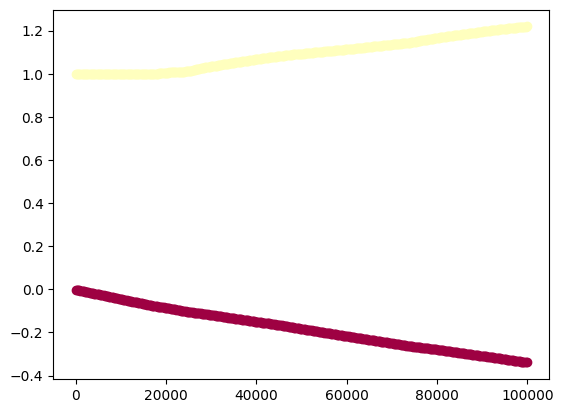

In [ ]:
np.random.seed(1)
start = datetime.datetime.now()

parameter_awal_ARD = [0,1]
rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, parameter_akhir = Gaussian_Process_fitting_ARD(prediktor_train,
                                                                                                           target_train,
                                                                                                           parameter_awal_ARD,
                                                                                                           learning_rate = 1e-5,
                                                                                                           basis = Titik_pusat_basis,
                                                                                                           batch_size = 256)#,
                                                                                                           #iterasi = 5000)

print("Waktu fitting : ")
print(datetime.datetime.now() - start)

In [ ]:
print("Parameter ARD")
print("sigma kuadrat :",np.exp(parameter_akhir[0]))
print("fitur satu :",parameter_akhir[1])

Parameter ARD
sigma kuadrat : 0.712285497394196
fitur satu : 1.2194588553983934


In [ ]:
rata_rata_dalam, variansi_dalam = \
Predict_ARD(prediktor_train,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 500)

Predict ARD: 100%|██████████| 200/200 [00:15<00:00, 12.89it/s]


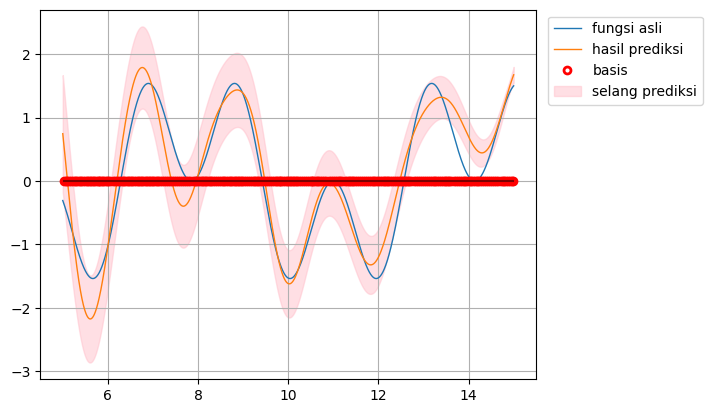

In [ ]:
# Plotting

#plt.plot(prediktor_train, target_train, 'o', markersize = 2, label = "data train", alpha = 0.01)
plt.plot(prediktor_train, fungsi_sinus(prediktor_train), linewidth = 1, label = "fungsi asli")
plt.plot(prediktor_train, rata_rata_dalam, label = "hasil prediksi", linewidth = 1)
plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(prediktor_train[:,0],
                 rata_rata_dalam[:,0] - 1.96*np.power(variansi_dalam[:,0],0.5),
                 rata_rata_dalam[:,0] + 1.96*np.power(variansi_dalam[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 0.5)
plt.grid()
plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-3,3])
plt.legend(bbox_to_anchor=(1.35, 1.0))


In [ ]:
Titik_luar = np.linspace(-5,5,100000).reshape(-1,1)

rata_rata_luar, variansi_luar = \
Predict_ARD(Titik_luar,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 500)

Predict ARD: 100%|██████████| 200/200 [00:13<00:00, 14.74it/s]


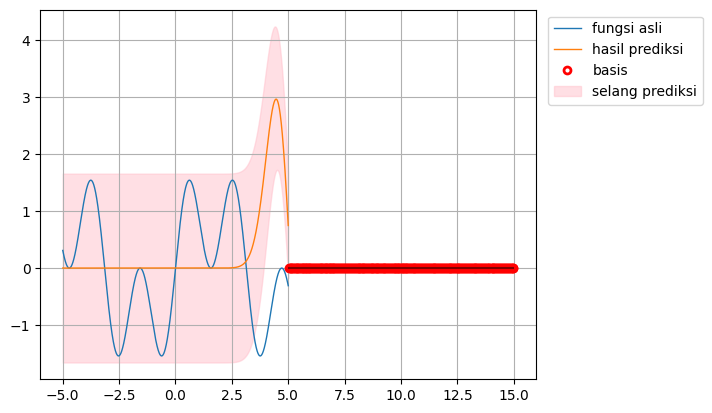

In [ ]:
# Plotting

#plt.plot(Titik_luar, target_train, 'o', markersize = 2, label = "data train", alpha = 0.01)
plt.plot(Titik_luar, fungsi_sinus(Titik_luar), linewidth = 1, label = "fungsi asli")
plt.plot(Titik_luar, rata_rata_luar, label = "hasil prediksi", linewidth = 1)
plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(Titik_luar[:,0],
                 rata_rata_luar[:,0] - 1.96*np.power(variansi_luar[:,0],0.5),
                 rata_rata_luar[:,0] + 1.96*np.power(variansi_luar[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 0.5)
plt.grid()
plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-3,3])
plt.legend(bbox_to_anchor=(1.35, 1.0))


# Eksperimen Sinus ESS

In [ ]:
def fungsi_sinus(x):
  hasil = np.sin(x) + np.sin(3*x)
  return hasil

In [ ]:
np.random.seed(10)
# Membangun data sintetis

banyak_data_train = 100000
prediktor_train = np.linspace(-15,5,banyak_data_train).reshape(-1,1)
target_train = fungsi_sinus(prediktor_train) + np.random.normal(0,1,banyak_data_train).reshape(-1,1)

In [ ]:
# Mencari titik pusat dengan K-Means

banyak_basis = 50
cluster = KMeans(n_clusters = banyak_basis, random_state = 10, n_init = 10).fit(prediktor_train)
Titik_pusat_basis = cluster.cluster_centers_
Titik_pusat_basis.shape

(50, 1)

Fitting ESS: 100%|██████████| 5000/5000 [02:17<00:00, 36.34it/s]



Galat terakhir sebesar  8.877981987198691e-05
Waktu fitting : 
0:02:17.592037


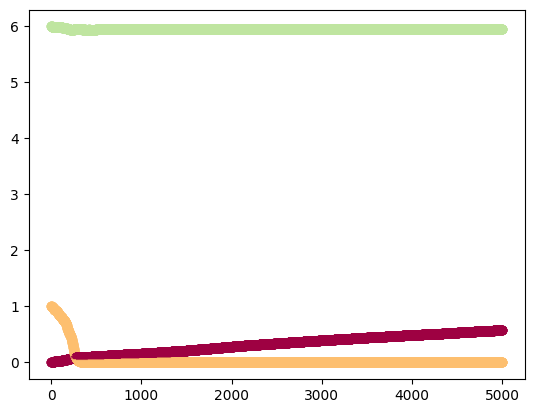

In [ ]:
np.random.seed(10)

start = datetime.datetime.now()

parameter_awal = [0,1,6]
rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, parameter_akhir = Gaussian_Process_fitting_ESS_Randomized(prediktor_train,
                                                                                                           target_train,
                                                                                                           parameter_awal,
                                                                                                           learning_rate = 1e-5,
                                                                                                           basis = Titik_pusat_basis,
                                                                                                           batch_size = 16,
                                                                                                           iterasi = 5000)

print("Waktu fitting : ")
print(datetime.datetime.now() - start)

In [ ]:
print("Parameter ESS")
print("sigma kuadrat :",np.exp(parameter_akhir[0]))
print("Lengthscale :",parameter_akhir[1])
print("periodicity :",parameter_akhir[2])

Parameter ESS
sigma kuadrat : 1.7687881384220947
Lengthscale : -0.00013211723037870934
periodicity : 5.947151055165712


In [ ]:
# Prediksi dengan partisi

Matriks_K_n = Kernel_ESS(Titik_pusat_basis,Titik_pusat_basis, parameter_akhir) + 0.01*np.identity(len(Titik_pusat_basis))
K_n_invers = np.linalg.inv(Matriks_K_n)

partisi = 1000
loading_bar_2 = trange(0,prediktor_train.shape[0],partisi, desc = "Predict ESS")
rata_rata_prediksi = np.array([])
variansi_prediksi = np.array([])

# Looping untuk tiap partisi
for data_ke in loading_bar_2 :

  # Inisialisasi segmen data yang akan diprediksi
  try :
    segmen_prediktor = prediktor_train[data_ke:data_ke + partisi]

  except :
    segmen_prediktor = prediktor_train[data_ke:]

  # Prediksi rata-rata di partisi yang dipilih
  rata_rata_segmen = Kernel_ESS(segmen_prediktor, Titik_pusat_basis, parameter_akhir) @ K_n_invers @ rata_rata_basis_prediksi
  rata_rata_prediksi = np.append(rata_rata_prediksi, rata_rata_segmen)

  # Prediksi nilai kovariansi di partisi yang dipilih
  variansi_segmen = Kernel_ESS(segmen_prediktor, segmen_prediktor, parameter_akhir) - \
                        Kernel_ESS(segmen_prediktor, Titik_pusat_basis, parameter_akhir) @ K_n_invers @\
                        Kernel_ESS(Titik_pusat_basis, segmen_prediktor, parameter_akhir) + \
                        Kernel_ESS(segmen_prediktor, Titik_pusat_basis, parameter_akhir) @ K_n_invers @\
                        matriks_kovariansi_basis_prediksi @ K_n_invers @ Kernel_ESS(Titik_pusat_basis, segmen_prediktor, parameter_akhir)
  # Untuk mempermudah penyimpanan hanya diambil diagonalnya saja (variansinya saja)
  variansi_prediksi = np.append(variansi_prediksi,np.diag(variansi_segmen))

rata_rata_prediksi = rata_rata_prediksi.reshape(-1,1)
variansi_prediksi = variansi_prediksi.reshape(-1,1)

Predict ESS: 100%|██████████| 100/100 [00:10<00:00,  9.38it/s]


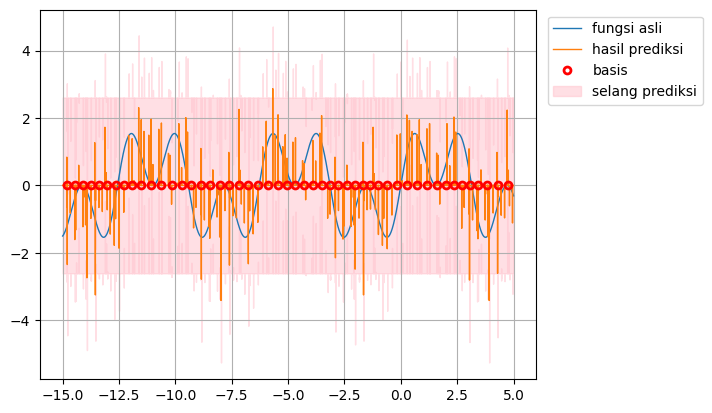

In [ ]:
# Plotting

#plt.plot(prediktor_train, target_train, 'o', markersize = 2, label = "data train", alpha = 0.01)
plt.plot(prediktor_train, fungsi_sinus(prediktor_train), linewidth = 1, label = "fungsi asli")
plt.plot(prediktor_train, rata_rata_prediksi, label = "hasil prediksi", linewidth = 1)
plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(prediktor_train[:,0],
                 rata_rata_prediksi[:,0] - 1.96*np.power(variansi_prediksi[:,0],0.5),
                 rata_rata_prediksi[:,0] + 1.96*np.power(variansi_prediksi[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 0.5)
plt.grid()
#plt.hlines(0,-5,5, color = 'black', alpha = 0.5)
#plt.ylim([-3,3])
plt.legend(bbox_to_anchor=(1.35, 1.0))


In [ ]:
Titik_luar = np.linspace(5,15,100000).reshape(-1,1)

# Prediksi dengan partisi

Matriks_K_n = Kernel_ESS(Titik_pusat_basis,Titik_pusat_basis, parameter_akhir) + 0.0001*np.identity(len(Titik_pusat_basis))
K_n_invers = np.linalg.inv(Matriks_K_n)

partisi = 1000
loading_bar_2 = trange(0,Titik_luar.shape[0],partisi, desc = "Predict ESS")
rata_rata_prediksi = np.array([])
variansi_prediksi = np.array([])

# Looping untuk tiap partisi
for data_ke in loading_bar_2 :

  # Inisialisasi segmen data yang akan diprediksi
  try :
    segmen_prediktor = Titik_luar[data_ke:data_ke + partisi]

  except :
    segmen_prediktor = Titik_luar[data_ke:]

  # Prediksi rata-rata di partisi yang dipilih
  rata_rata_segmen = Kernel_ESS(segmen_prediktor, Titik_pusat_basis, parameter_akhir) @ K_n_invers @ rata_rata_basis_prediksi
  rata_rata_prediksi = np.append(rata_rata_prediksi, rata_rata_segmen)

  # Prediksi nilai kovariansi di partisi yang dipilih
  variansi_segmen = Kernel_ESS(segmen_prediktor, segmen_prediktor, parameter_akhir) - \
                        Kernel_ESS(segmen_prediktor, Titik_pusat_basis, parameter_akhir) @ K_n_invers @\
                        Kernel_ESS(Titik_pusat_basis, segmen_prediktor, parameter_akhir) + \
                        Kernel_ESS(segmen_prediktor, Titik_pusat_basis, parameter_akhir) @ K_n_invers @\
                        matriks_kovariansi_basis_prediksi @ K_n_invers @ Kernel_ESS(Titik_pusat_basis, segmen_prediktor, parameter_akhir)
  # Untuk mempermudah penyimpanan hanya diambil diagonalnya saja (variansinya saja)
  variansi_prediksi = np.append(variansi_prediksi,np.diag(variansi_segmen))

rata_rata_prediksi = rata_rata_prediksi.reshape(-1,1)
variansi_prediksi = variansi_prediksi.reshape(-1,1)

Predict ESS: 100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


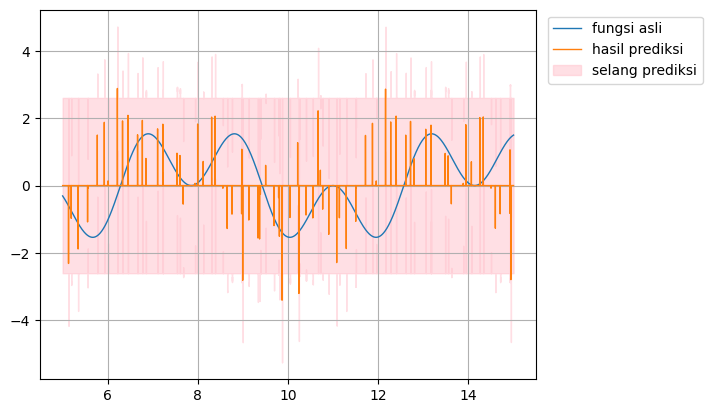

In [ ]:
# Plotting

#plt.plot(Titik_luar, target_train, 'o', markersize = 2, label = "data train", alpha = 0.01)
plt.plot(Titik_luar, fungsi_sinus(Titik_luar), linewidth = 1, label = "fungsi asli")
plt.plot(Titik_luar, rata_rata_prediksi, label = "hasil prediksi", linewidth = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(Titik_luar[:,0],
                 rata_rata_prediksi[:,0] - 1.96*np.power(variansi_prediksi[:,0],0.5),
                 rata_rata_prediksi[:,0] + 1.96*np.power(variansi_prediksi[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 0.5)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-3,3])
plt.legend(bbox_to_anchor=(1.35, 1.0))


# Eksperimen Sinus ESS + ARD

In [ ]:
def fungsi_sinus(x):
  hasil = np.sin(x) + np.sin(3*x)
  return hasil

In [ ]:
np.random.seed(10)
# Membangun data sintetis

banyak_data_train = 100000
prediktor_train = np.linspace(-15,5,banyak_data_train).reshape(-1,1)
target_train = fungsi_sinus(prediktor_train) + np.random.normal(0,1,banyak_data_train).reshape(-1,1)

In [ ]:
# Mencari titik pusat dengan K-Means

banyak_basis = 50
cluster = KMeans(n_clusters = banyak_basis, random_state = 10, n_init = 10).fit(prediktor_train)
Titik_pusat_basis = cluster.cluster_centers_
Titik_pusat_basis.shape

(50, 1)

In [ ]:
np.random.seed(10)

start = datetime.datetime.now()

parameter_awal = [0,1,6,0,1]
rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, parameter_akhir = Gaussian_Process_fitting_ESS_ARD(prediktor_train,
                                                                                                           target_train,
                                                                                                           parameter_awal,
                                                                                                           learning_rate = 1*10e-6,
                                                                                                           basis = Titik_pusat_basis,
                                                                                                           batch_size = 23)

print("Waktu fitting : ")
print(datetime.datetime.now() - start)

Fitting ESS_ARD: 100%|██████████| 4348/4348 [02:09<00:00, 33.51it/s]


Galat terakhir sebesar  0.00017047618355664734
Waktu fitting : 
0:02:09.750022


In [ ]:
print("Parameter ESS + ARD")
print("sigma kuadrat ESS :",np.exp(parameter_akhir[0]))
print("Lengthscale :",parameter_akhir[1])
print("periodicity :",parameter_akhir[2])
print("sigma kuadrat ARD :",np.exp(parameter_akhir[3]))
print("fitur 1 :",parameter_akhir[4])

Parameter ESS + ARD
sigma kuadrat ESS : 1.0342414552247865
Lengthscale : 0.7579540067076691
periodicity : 6.243625674601635
sigma kuadrat ARD : 0.9249038540614909
fitur 1 : 0.9219420413771491


In [ ]:
# Prediksi dengan partisi

Matriks_K_n = Kernel_ESS_ARD(Titik_pusat_basis,Titik_pusat_basis, parameter_akhir) + 0.01*np.identity(len(Titik_pusat_basis))
K_n_invers = np.linalg.inv(Matriks_K_n)

partisi = 1000
loading_bar_2 = trange(0,prediktor_train.shape[0],partisi, desc = "Predict ESS + ARD")
rata_rata_prediksi = np.array([])
variansi_prediksi = np.array([])

# Looping untuk tiap partisi
for data_ke in loading_bar_2 :

  # Inisialisasi segmen data yang akan diprediksi
  try :
    segmen_prediktor = prediktor_train[data_ke:data_ke + partisi]

  except :
    segmen_prediktor = prediktor_train[data_ke:]

  # Prediksi rata-rata di partisi yang dipilih
  rata_rata_segmen = Kernel_ESS_ARD(segmen_prediktor, Titik_pusat_basis, parameter_akhir) @ K_n_invers @ rata_rata_basis_prediksi
  rata_rata_prediksi = np.append(rata_rata_prediksi, rata_rata_segmen)

  # Prediksi nilai kovariansi di partisi yang dipilih
  variansi_segmen = Kernel_ESS_ARD(segmen_prediktor, segmen_prediktor, parameter_akhir) - \
                        Kernel_ESS_ARD(segmen_prediktor, Titik_pusat_basis, parameter_akhir) @ K_n_invers @\
                        Kernel_ESS_ARD(Titik_pusat_basis, segmen_prediktor, parameter_akhir) + \
                        Kernel_ESS_ARD(segmen_prediktor, Titik_pusat_basis, parameter_akhir) @ K_n_invers @\
                        matriks_kovariansi_basis_prediksi @ K_n_invers @ Kernel_ESS_ARD(Titik_pusat_basis, segmen_prediktor, parameter_akhir)
  # Untuk mempermudah penyimpanan hanya diambil diagonalnya saja (variansinya saja)
  variansi_prediksi = np.append(variansi_prediksi,np.diag(variansi_segmen))

rata_rata_prediksi = rata_rata_prediksi.reshape(-1,1)
variansi_prediksi = variansi_prediksi.reshape(-1,1)

Predict ESS + ARD: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


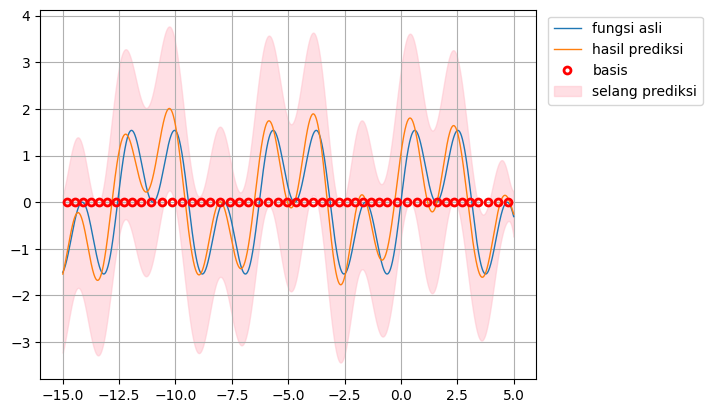

In [ ]:
# Plotting

#plt.plot(prediktor_train, target_train, 'o', markersize = 2, label = "data train", alpha = 0.01)
plt.plot(prediktor_train, fungsi_sinus(prediktor_train), linewidth = 1, label = "fungsi asli")
plt.plot(prediktor_train, rata_rata_prediksi, label = "hasil prediksi", linewidth = 1)
plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(prediktor_train[:,0],
                 rata_rata_prediksi[:,0] - 1.96*np.power(variansi_prediksi[:,0],0.5),
                 rata_rata_prediksi[:,0] + 1.96*np.power(variansi_prediksi[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 0.5)
plt.grid()
#plt.hlines(0,-5,5, color = 'black', alpha = 0.5)
#plt.ylim([-3,3])
plt.legend(bbox_to_anchor=(1.35, 1.0))


In [ ]:
Titik_luar = np.linspace(-25,-15,100000).reshape(-1,1)

# Prediksi dengan partisi

Matriks_K_n = Kernel_ESS_ARD(Titik_pusat_basis,Titik_pusat_basis, parameter_akhir) + 0.01*np.identity(len(Titik_pusat_basis))
K_n_invers = np.linalg.inv(Matriks_K_n)

partisi = 1000
loading_bar_2 = trange(0,Titik_luar.shape[0],partisi, desc = "Predict ESS + ARD")
rata_rata_prediksi = np.array([])
variansi_prediksi = np.array([])

# Looping untuk tiap partisi
for data_ke in loading_bar_2 :

  # Inisialisasi segmen data yang akan diprediksi
  try :
    segmen_prediktor = Titik_luar[data_ke:data_ke + partisi]

  except :
    segmen_prediktor = Titik_luar[data_ke:]

  # Prediksi rata-rata di partisi yang dipilih
  rata_rata_segmen = Kernel_ESS_ARD(segmen_prediktor, Titik_pusat_basis, parameter_akhir) @ K_n_invers @ rata_rata_basis_prediksi
  rata_rata_prediksi = np.append(rata_rata_prediksi, rata_rata_segmen)

  # Prediksi nilai kovariansi di partisi yang dipilih
  variansi_segmen = Kernel_ESS_ARD(segmen_prediktor, segmen_prediktor, parameter_akhir) - \
                        Kernel_ESS_ARD(segmen_prediktor, Titik_pusat_basis, parameter_akhir) @ K_n_invers @\
                        Kernel_ESS_ARD(Titik_pusat_basis, segmen_prediktor, parameter_akhir) + \
                        Kernel_ESS_ARD(segmen_prediktor, Titik_pusat_basis, parameter_akhir) @ K_n_invers @\
                        matriks_kovariansi_basis_prediksi @ K_n_invers @ Kernel_ESS_ARD(Titik_pusat_basis, segmen_prediktor, parameter_akhir)
  # Untuk mempermudah penyimpanan hanya diambil diagonalnya saja (variansinya saja)
  variansi_prediksi = np.append(variansi_prediksi,np.diag(variansi_segmen))

rata_rata_prediksi = rata_rata_prediksi.reshape(-1,1)
variansi_prediksi = variansi_prediksi.reshape(-1,1)

Predict ESS + ARD: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


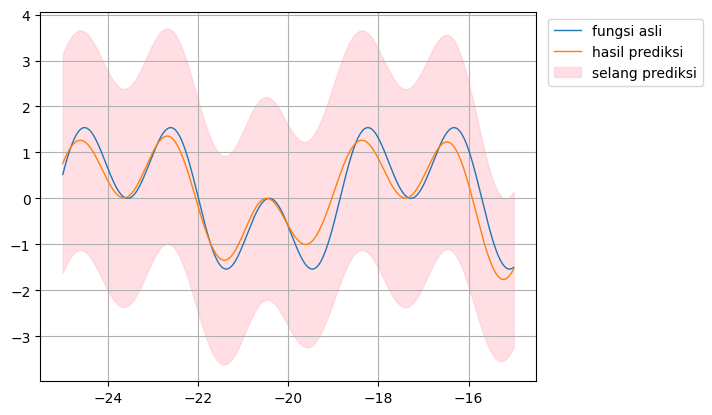

In [ ]:
# Plotting

#plt.plot(Titik_luar, target_train, 'o', markersize = 2, label = "data train", alpha = 0.01)
plt.plot(Titik_luar, fungsi_sinus(Titik_luar), linewidth = 1, label = "fungsi asli")
plt.plot(Titik_luar, rata_rata_prediksi, label = "hasil prediksi", linewidth = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(Titik_luar[:,0],
                 rata_rata_prediksi[:,0] - 1.96*np.power(variansi_prediksi[:,0],0.5),
                 rata_rata_prediksi[:,0] + 1.96*np.power(variansi_prediksi[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 0.5)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-3,3])
plt.legend(bbox_to_anchor=(1.35, 1.0))


# *Preliminary Data Wrangling*

In [ ]:
data = pd.read_csv("https://media.githubusercontent.com/media/virtualtayce/tugas_besar/main/2008.csv")
informasi = pd.read_csv("https://raw.githubusercontent.com/virtualtayce/tugas_besar/main/variable-descriptions.csv",
                        skiprows = 3, header = None)

In [ ]:
informasi.columns = ['No', 'Name', 'Description']
informasi.set_index('No', inplace = True)
informasi

Name                                        Description
No                                                                      
1                Year                                          1987-2008
2               Month                                             12-Jan
3          DayofMonth                                             31-Jan
4           DayOfWeek                            1 (Monday) - 7 (Sunday)
5             DepTime                actual departure time (local, hhmm)
6          CRSDepTime             scheduled departure time (local, hhmm)
7             ArrTime                  actual arrival time (local, hhmm)
8          CRSArrTime               scheduled arrival time (local, hhmm)
9       UniqueCarrier                                unique carrier code
10          FlightNum                                      flight number
11            TailNum                                  plane tail number
12  ActualElapsedTime                                         in minutes
13     CRSElapsedTime                                         in minutes
14            AirTime                                         in minutes
15           ArrDelay                          arrival delay, in minutes
16           DepDelay                        departure delay, in minutes
17             Origin                           origin IATA airport code
18               Dest                      destination IATA airport code
19           Distance                                           in miles
20             TaxiIn                           taxi in time, in minutes
21            TaxiOut                           taxi out time in minutes
22          Cancelled                          was the flight cancelled?
23   CancellationCode  reason for cancellation (A = carrier, B = weat...
24           Diverted                                    1 = yes, 0 = no
25       CarrierDelay                                         in minutes
26       WeatherDelay                                         in minutes
27           NASDelay                                         in minutes
28      SecurityDelay                                         in minutes
29  LateAircraftDelay                                         in minutes

In [ ]:
informasi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 1 to 29
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         29 non-null     object
 1   Description  29 non-null     object
dtypes: object(2)
memory usage: 696.0+ bytes


In [ ]:
print('Terdapat ' + str(informasi.shape[0]) + ' baris dan ' + str(informasi.shape[1]) + ' kolom di dataset yang berisi informasi.')

Terdapat 29 baris dan 2 kolom di dataset yang berisi informasi.


In [ ]:
cancel_code_desc = informasi.iloc[22, 1]
print(cancel_code_desc)

reason for cancellation (A = carrier, B = weather, C = NAS, D = security)


In [ ]:
data

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0        2008      1           3          4   1343.0        1325   1451.0   
1        2008      1           3          4   1125.0        1120   1247.0   
2        2008      1           3          4   2009.0        2015   2136.0   
3        2008      1           3          4    903.0         855   1203.0   
4        2008      1           3          4   1423.0        1400   1726.0   
...       ...    ...         ...        ...      ...         ...      ...   
2389212  2008      4          17          4   1025.0        1025   1234.0   
2389213  2008      4          17          4   1319.0        1320   1527.0   
2389214  2008      4          17          4   1335.0        1335   1556.0   
2389215  2008      4          17          4   1933.0        1935   2140.0   
2389216  2008      4          17          4    621.0         615    752.0   

         CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
0              1435            WN        588  ...    4.0      9.0          0   
1              1245            WN       1343  ...    3.0      8.0          0   
2              2140            WN       3841  ...    2.0     14.0          0   
3              1205            WN          3  ...    5.0      7.0          0   
4              1710            WN         25  ...    6.0     10.0          0   
...             ...           ...        ...  ...    ...      ...        ...   
2389212        1237            DL       1207  ...    5.0     16.0          0   
2389213        1524            DL       1208  ...    9.0     12.0          0   
2389214        1553            DL       1209  ...    7.0     31.0          0   
2389215        2141            DL       1210  ...    9.0     12.0          0   
2389216         754            DL       1211  ...   15.0     12.0          0   

         CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0                     NaN         0          16.0          0.0      0.0   
1                     NaN         0           NaN          NaN      NaN   
2                     NaN         0           NaN          NaN      NaN   
3                     NaN         0           NaN          NaN      NaN   
4                     NaN         0          16.0          0.0      0.0   
...                   ...       ...           ...          ...      ...   
2389212               NaN         0           NaN          NaN      NaN   
2389213               NaN         0           NaN          NaN      NaN   
2389214               NaN         0           NaN          NaN      NaN   
2389215               NaN         0           NaN          NaN      NaN   
2389216               NaN         0           NaN          NaN      NaN   

         SecurityDelay  LateAircraftDelay  
0                  0.0                0.0  
1                  NaN                NaN  
2                  NaN                NaN  
3                  NaN                NaN  
4                  0.0                0.0  
...                ...                ...  
2389212            NaN                NaN  
2389213            NaN                NaN  
2389214            NaN                NaN  
2389215            NaN                NaN  
2389216            NaN                NaN  

[2389217 rows x 29 columns]

In [ ]:
print('Terdapat ' + str(data.shape[0]) + ' baris dan ' + str(data.shape[1]) + ' kolom di dataset penerbangan.')

Terdapat 2389217 baris dan 29 kolom di dataset penerbangan.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389217 entries, 0 to 2389216
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

In [ ]:
data.describe()

Year         Month    DayofMonth     DayOfWeek       DepTime  \
count  2389217.0  2.389217e+06  2.389217e+06  2.389217e+06  2.324775e+06   
mean      2008.0  2.505009e+00  1.566386e+01  3.909625e+00  1.340018e+03   
std          0.0  1.121493e+00  8.750405e+00  1.980431e+00  4.802717e+02   
min       2008.0  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%       2008.0  1.000000e+00  8.000000e+00  2.000000e+00  9.300000e+02   
50%       2008.0  3.000000e+00  1.600000e+01  4.000000e+00  1.330000e+03   
75%       2008.0  4.000000e+00  2.300000e+01  6.000000e+00  1.733000e+03   
max       2008.0  4.000000e+00  3.100000e+01  7.000000e+00  2.400000e+03   

         CRSDepTime       ArrTime    CRSArrTime     FlightNum  \
count  2.389217e+06  2.319121e+06  2.389217e+06  2.389217e+06   
mean   1.329992e+03  1.485835e+03  1.496744e+03  2.213888e+03   
std    4.657833e+02  5.081295e+02  4.845238e+02  1.951392e+03   
min    0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    9.270000e+02  1.110000e+03  1.115000e+03  6.050000e+02   
50%    1.325000e+03  1.516000e+03  1.520000e+03  1.544000e+03   
75%    1.720000e+03  1.914000e+03  1.910000e+03  3.631000e+03   
max    2.359000e+03  2.400000e+03  2.400000e+03  9.741000e+03   

       ActualElapsedTime  ...      Distance        TaxiIn       TaxiOut  \
count       2.319121e+06  ...  2.389217e+06  2.319121e+06  2.324775e+06   
mean        1.286189e+02  ...  7.261589e+02  6.839862e+00  1.668584e+01   
std         7.025303e+01  ...  5.571763e+02  4.846435e+00  1.102905e+01   
min         1.400000e+01  ...  1.700000e+01  0.000000e+00  0.000000e+00   
25%         7.800000e+01  ...  3.250000e+02  4.000000e+00  1.000000e+01   
50%         1.110000e+02  ...  5.830000e+02  6.000000e+00  1.400000e+01   
75%         1.600000e+02  ...  9.570000e+02  8.000000e+00  1.900000e+01   
max         9.050000e+02  ...  4.962000e+03  2.130000e+02  3.830000e+02   

          Cancelled      Diverted   CarrierDelay   WeatherDelay  \
count  2.389217e+06  2.389217e+06  584583.000000  584583.000000   
mean   2.697202e-02  2.366466e-03      15.752957       2.938243   
std    1.620017e-01  4.858875e-02      40.035487      19.166662   
min    0.000000e+00  0.000000e+00       0.000000       0.000000   
25%    0.000000e+00  0.000000e+00       0.000000       0.000000   
50%    0.000000e+00  0.000000e+00       0.000000       0.000000   
75%    0.000000e+00  0.000000e+00      16.000000       0.000000   
max    1.000000e+00  1.000000e+00    2436.000000    1148.000000   

            NASDelay  SecurityDelay  LateAircraftDelay  
count  584583.000000  584583.000000      584583.000000  
mean       16.158462       0.080459          20.976710  
std        30.534167       1.742579          38.617154  
min         0.000000       0.000000           0.000000  
25%         0.000000       0.000000           0.000000  
50%         5.000000       0.000000           0.000000  
75%        20.000000       0.000000          27.000000  
max      1357.000000     392.000000        1254.000000  

[8 rows x 24 columns]

In [ ]:
# buat copy dataframe hanya untuk eksplorasi data/plot
penerbangan = data.copy()
detil = informasi.copy()

In [ ]:
data['Date'] = pd.to_datetime(data['Year'].map(str) + '-' + data['Month'].map(str) + '-' + data['DayofMonth'].map(str))
data

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0        2008      1           3          4   1343.0        1325   1451.0   
1        2008      1           3          4   1125.0        1120   1247.0   
2        2008      1           3          4   2009.0        2015   2136.0   
3        2008      1           3          4    903.0         855   1203.0   
4        2008      1           3          4   1423.0        1400   1726.0   
...       ...    ...         ...        ...      ...         ...      ...   
2389212  2008      4          17          4   1025.0        1025   1234.0   
2389213  2008      4          17          4   1319.0        1320   1527.0   
2389214  2008      4          17          4   1335.0        1335   1556.0   
2389215  2008      4          17          4   1933.0        1935   2140.0   
2389216  2008      4          17          4    621.0         615    752.0   

         CRSArrTime UniqueCarrier  FlightNum  ... TaxiOut  Cancelled  \
0              1435            WN        588  ...     9.0          0   
1              1245            WN       1343  ...     8.0          0   
2              2140            WN       3841  ...    14.0          0   
3              1205            WN          3  ...     7.0          0   
4              1710            WN         25  ...    10.0          0   
...             ...           ...        ...  ...     ...        ...   
2389212        1237            DL       1207  ...    16.0          0   
2389213        1524            DL       1208  ...    12.0          0   
2389214        1553            DL       1209  ...    31.0          0   
2389215        2141            DL       1210  ...    12.0          0   
2389216         754            DL       1211  ...    12.0          0   

         CancellationCode  Diverted  CarrierDelay  WeatherDelay NASDelay  \
0                     NaN         0          16.0           0.0      0.0   
1                     NaN         0           NaN           NaN      NaN   
2                     NaN         0           NaN           NaN      NaN   
3                     NaN         0           NaN           NaN      NaN   
4                     NaN         0          16.0           0.0      0.0   
...                   ...       ...           ...           ...      ...   
2389212               NaN         0           NaN           NaN      NaN   
2389213               NaN         0           NaN           NaN      NaN   
2389214               NaN         0           NaN           NaN      NaN   
2389215               NaN         0           NaN           NaN      NaN   
2389216               NaN         0           NaN           NaN      NaN   

        SecurityDelay  LateAircraftDelay       Date  
0                 0.0                0.0 2008-01-03  
1                 NaN                NaN 2008-01-03  
2                 NaN                NaN 2008-01-03  
3                 NaN                NaN 2008-01-03  
4                 0.0                0.0 2008-01-03  
...               ...                ...        ...  
2389212           NaN                NaN 2008-04-17  
2389213           NaN                NaN 2008-04-17  
2389214           NaN                NaN 2008-04-17  
2389215           NaN                NaN 2008-04-17  
2389216           NaN                NaN 2008-04-17  

[2389217 rows x 30 columns]

In [ ]:
def date_format(dataframe):
  if pd.isnull(dataframe):
    return np.nan
  else:
    if dataframe == 2400: dataframe = 0
    dataframe = "{0:04d}".format(int(dataframe))
    date = datetime.time(int(dataframe[0:2]), int(dataframe[2:4]))
    return date

In [ ]:
def date_combination(x):
  if pd.isnull(x[0]) or pd.isnull(x[1]):
    return np.nan
  else:
    return datetime.datetime.combine(x[0], x[1])

In [ ]:
def time_airline(data, col):
  new = []
  for index, cols in data[['Date', col]].iterrows():
    if pd.isnull(cols[1]):
      new.append(np.nan)
    elif float(cols[1]) == 2400:
      cols[0] += datetime.timedelta(days = 1)
      cols[1] = datetime.time(0,0)
      new.append(date_combination(cols))
    else:
      cols[1] = date_format(cols[1])
      new.append(date_combination(cols))
  return pd.Series(new)

In [ ]:
data['CRSDepTime'] = time_airline(data, 'CRSDepTime')
data['DepTime'] = data['DepTime'].apply(date_format)
data['CRSArrTime'] = data['CRSArrTime'].apply(date_format)
data['ArrTime'] = data['ArrTime'].apply(date_format)

In [ ]:
data[['CRSDepTime', 'CRSArrTime', 'DepTime', 'ArrTime', 'DepDelay', 'ArrDelay']]

CRSDepTime CRSArrTime   DepTime   ArrTime  DepDelay  ArrDelay
0       2008-01-03 13:25:00   14:35:00  13:43:00  14:51:00      18.0      16.0
1       2008-01-03 11:20:00   12:45:00  11:25:00  12:47:00       5.0       2.0
2       2008-01-03 20:15:00   21:40:00  20:09:00  21:36:00      -6.0      -4.0
3       2008-01-03 08:55:00   12:05:00  09:03:00  12:03:00       8.0      -2.0
4       2008-01-03 14:00:00   17:10:00  14:23:00  17:26:00      23.0      16.0
...                     ...        ...       ...       ...       ...       ...
2389212 2008-04-17 10:25:00   12:37:00  10:25:00  12:34:00       0.0      -3.0
2389213 2008-04-17 13:20:00   15:24:00  13:19:00  15:27:00      -1.0       3.0
2389214 2008-04-17 13:35:00   15:53:00  13:35:00  15:56:00       0.0       3.0
2389215 2008-04-17 19:35:00   21:41:00  19:33:00  21:40:00      -2.0      -1.0
2389216 2008-04-17 06:15:00   07:54:00  06:21:00  07:52:00       6.0      -2.0

[2389217 rows x 6 columns]

In [ ]:
null = data.isnull().sum(axis = 0).reset_index()
null.columns = ["Variabel", "Missing Values"]
null

Variabel  Missing Values
0                Year               0
1               Month               0
2          DayofMonth               0
3           DayOfWeek               0
4             DepTime           64442
5          CRSDepTime               0
6             ArrTime           70096
7          CRSArrTime               0
8       UniqueCarrier               0
9           FlightNum               0
10            TailNum           42452
11  ActualElapsedTime           70096
12     CRSElapsedTime             407
13            AirTime           70096
14           ArrDelay           70096
15           DepDelay           64442
16             Origin               0
17               Dest               0
18           Distance               0
19             TaxiIn           70096
20            TaxiOut           64442
21          Cancelled               0
22   CancellationCode         2324775
23           Diverted               0
24       CarrierDelay         1804634
25       WeatherDelay         1804634
26           NASDelay         1804634
27      SecurityDelay         1804634
28  LateAircraftDelay         1804634
29               Date               0

In [ ]:
null["Filling Factor (dalam %)"] = (data.shape[0] - null["Missing Values"])/data.shape[0]*100
null.sort_values(by = "Filling Factor (dalam %)").reset_index(drop = True)

Variabel  Missing Values  Filling Factor (dalam %)
0    CancellationCode         2324775                  2.697202
1       SecurityDelay         1804634                 24.467556
2            NASDelay         1804634                 24.467556
3        WeatherDelay         1804634                 24.467556
4   LateAircraftDelay         1804634                 24.467556
5        CarrierDelay         1804634                 24.467556
6             AirTime           70096                 97.066152
7   ActualElapsedTime           70096                 97.066152
8            ArrDelay           70096                 97.066152
9             ArrTime           70096                 97.066152
10             TaxiIn           70096                 97.066152
11            DepTime           64442                 97.302798
12           DepDelay           64442                 97.302798
13            TaxiOut           64442                 97.302798
14            TailNum           42452                 98.223184
15     CRSElapsedTime             407                 99.982965
16          Cancelled               0                100.000000
17           Diverted               0                100.000000
18               Year               0                100.000000
19               Dest               0                100.000000
20             Origin               0                100.000000
21          FlightNum               0                100.000000
22      UniqueCarrier               0                100.000000
23         CRSArrTime               0                100.000000
24         CRSDepTime               0                100.000000
25          DayOfWeek               0                100.000000
26         DayofMonth               0                100.000000
27              Month               0                100.000000
28           Distance               0                100.000000
29               Date               0                100.000000

In [ ]:
# tidak bisa:
# data.dropna(inplace = True)
# pada 6 buah row teratas yang terdapat filling factor yakni 2 - 25% (tidak baik)

# Eksplorasi Data

In [ ]:
hari = {1:'Senin', 2:'Selasa', 3:'Rabu', 4:'Kamis',\
        5:'Jum\'at', 6:'Sabtu', 7:'Minggu'}
penerbangan['DayOfWeek'].replace(hari, inplace = True)

In [ ]:
hari = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jum\'at', 'Sabtu', 'Minggu']
urutan_hari = pd.api.types.CategoricalDtype(ordered = True, categories = hari)
penerbangan['DayOfWeek'] = penerbangan['DayOfWeek'].astype(urutan_hari)

In [ ]:
penerbangan['DayOfWeek'].unique()

['Kamis', 'Jum'at', 'Sabtu', 'Minggu', 'Senin', 'Selasa', 'Rabu']
Categories (7, object): ['Senin' < 'Selasa' < 'Rabu' < 'Kamis' < 'Jum'at' < 'Sabtu' < 'Minggu']

In [ ]:
bulan = {1:'Januari', 2:'Februari', 3:'Maret', 4:'April'}
penerbangan['Month'].replace(bulan, inplace = True)

In [ ]:
bulan = ['Januari', 'Februari', 'Maret', 'April']
urutan_bulan = pd.api.types.CategoricalDtype(ordered = True, categories = bulan)
penerbangan['Month'] = penerbangan['Month'].astype(urutan_bulan)

In [ ]:
penerbangan['Month'].unique()

['Januari', 'Februari', 'Maret', 'April']
Categories (4, object): ['Januari' < 'Februari' < 'Maret' < 'April']

In [ ]:
penerbangan

Year    Month  DayofMonth DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0        2008  Januari           3     Kamis   1343.0        1325   1451.0   
1        2008  Januari           3     Kamis   1125.0        1120   1247.0   
2        2008  Januari           3     Kamis   2009.0        2015   2136.0   
3        2008  Januari           3     Kamis    903.0         855   1203.0   
4        2008  Januari           3     Kamis   1423.0        1400   1726.0   
...       ...      ...         ...       ...      ...         ...      ...   
2389212  2008    April          17     Kamis   1025.0        1025   1234.0   
2389213  2008    April          17     Kamis   1319.0        1320   1527.0   
2389214  2008    April          17     Kamis   1335.0        1335   1556.0   
2389215  2008    April          17     Kamis   1933.0        1935   2140.0   
2389216  2008    April          17     Kamis    621.0         615    752.0   

         CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
0              1435            WN        588  ...    4.0      9.0          0   
1              1245            WN       1343  ...    3.0      8.0          0   
2              2140            WN       3841  ...    2.0     14.0          0   
3              1205            WN          3  ...    5.0      7.0          0   
4              1710            WN         25  ...    6.0     10.0          0   
...             ...           ...        ...  ...    ...      ...        ...   
2389212        1237            DL       1207  ...    5.0     16.0          0   
2389213        1524            DL       1208  ...    9.0     12.0          0   
2389214        1553            DL       1209  ...    7.0     31.0          0   
2389215        2141            DL       1210  ...    9.0     12.0          0   
2389216         754            DL       1211  ...   15.0     12.0          0   

         CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0                     NaN         0          16.0          0.0      0.0   
1                     NaN         0           NaN          NaN      NaN   
2                     NaN         0           NaN          NaN      NaN   
3                     NaN         0           NaN          NaN      NaN   
4                     NaN         0          16.0          0.0      0.0   
...                   ...       ...           ...          ...      ...   
2389212               NaN         0           NaN          NaN      NaN   
2389213               NaN         0           NaN          NaN      NaN   
2389214               NaN         0           NaN          NaN      NaN   
2389215               NaN         0           NaN          NaN      NaN   
2389216               NaN         0           NaN          NaN      NaN   

         SecurityDelay  LateAircraftDelay  
0                  0.0                0.0  
1                  NaN                NaN  
2                  NaN                NaN  
3                  NaN                NaN  
4                  0.0                0.0  
...                ...                ...  
2389212            NaN                NaN  
2389213            NaN                NaN  
2389214            NaN                NaN  
2389215            NaN                NaN  
2389216            NaN                NaN  

[2389217 rows x 29 columns]

In [ ]:
# terdapat nilai-nilai NaN dan 0 yang digunakan untuk mencatat tidak terjadi delay
# untuk menstandarkan hal ini, semuanya akan dikonversi ke 0 karena penundaan dicatat dalam menit

# konversi nilai NaN menjadi 0
delay = ['CarrierDelay','WeatherDelay',	'NASDelay',	'SecurityDelay', 'LateAircraftDelay']

for column in delay:
  print('Awal: Terdapat ' + str(penerbangan[column].isnull().sum()) + ' nilai NaN di kolom ' + str(column))
  penerbangan[column].fillna(0, inplace = True)
  print('Akhir: Terdapat ' + str(penerbangan[column].isnull().sum()) + ' nilai NaN di kolom ' + str(column) + '\n')

Awal: Terdapat 1804634 nilai NaN di kolom CarrierDelay
Akhir: Terdapat 0 nilai NaN di kolom CarrierDelay

Awal: Terdapat 1804634 nilai NaN di kolom WeatherDelay
Akhir: Terdapat 0 nilai NaN di kolom WeatherDelay

Awal: Terdapat 1804634 nilai NaN di kolom NASDelay
Akhir: Terdapat 0 nilai NaN di kolom NASDelay

Awal: Terdapat 1804634 nilai NaN di kolom SecurityDelay
Akhir: Terdapat 0 nilai NaN di kolom SecurityDelay

Awal: Terdapat 1804634 nilai NaN di kolom LateAircraftDelay
Akhir: Terdapat 0 nilai NaN di kolom LateAircraftDelay



In [ ]:
penerbangan.loc[(penerbangan['DepTime'].isnull())& (penerbangan['ArrTime'].isnull())&
                (penerbangan['CarrierDelay'] == 0)& (penerbangan['WeatherDelay'] == 0)&
                (penerbangan['NASDelay'] == 0)& (penerbangan['SecurityDelay'] == 0)&
                (penerbangan['LateAircraftDelay'] == 0)]

Year    Month  DayofMonth DayOfWeek  DepTime  CRSDepTime  ArrTime  \
42       2008  Januari           3     Kamis      NaN         800      NaN   
259      2008  Januari           3     Kamis      NaN         700      NaN   
454      2008  Januari           3     Kamis      NaN        1100      NaN   
480      2008  Januari           3     Kamis      NaN         905      NaN   
482      2008  Januari           3     Kamis      NaN        1620      NaN   
...       ...      ...         ...       ...      ...         ...      ...   
2387945  2008    April          16      Rabu      NaN         855      NaN   
2387946  2008    April          16      Rabu      NaN        1045      NaN   
2388936  2008    April          17     Kamis      NaN        1240      NaN   
2389184  2008    April          17     Kamis      NaN        1100      NaN   
2389185  2008    April          17     Kamis      NaN        1238      NaN   

         CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
42              850            WN        609  ...    NaN      NaN          1   
259             830            WN        126  ...    NaN      NaN          1   
454            1215            WN       1146  ...    NaN      NaN          1   
480            1025            WN        469  ...    NaN      NaN          1   
482            1740            WN        618  ...    NaN      NaN          1   
...             ...           ...        ...  ...    ...      ...        ...   
2387945        1012            DL       1214  ...    NaN      NaN          1   
2387946        1217            DL       1215  ...    NaN      NaN          1   
2388936        1506            DL        916  ...    NaN      NaN          1   
2389184        1152            DL       1183  ...    NaN      NaN          1   
2389185        1526            DL       1184  ...    NaN      NaN          1   

         CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
42                      A         0           0.0          0.0      0.0   
259                     A         0           0.0          0.0      0.0   
454                     A         0           0.0          0.0      0.0   
480                     A         0           0.0          0.0      0.0   
482                     C         0           0.0          0.0      0.0   
...                   ...       ...           ...          ...      ...   
2387945                 A         0           0.0          0.0      0.0   
2387946                 A         0           0.0          0.0      0.0   
2388936                 A         0           0.0          0.0      0.0   
2389184                 A         0           0.0          0.0      0.0   
2389185                 A         0           0.0          0.0      0.0   

         SecurityDelay  LateAircraftDelay  
42                 0.0                0.0  
259                0.0                0.0  
454                0.0                0.0  
480                0.0                0.0  
482                0.0                0.0  
...                ...                ...  
2387945            0.0                0.0  
2387946            0.0                0.0  
2388936            0.0                0.0  
2389184            0.0                0.0  
2389185            0.0                0.0  

[64442 rows x 29 columns]

In [ ]:
# jika DepTime bernilai NaN dan tidak terdapat delay, waktu ditetapkan sebagai CRSDepTime
penerbangan['DepTime'] = np.where(penerbangan['DepTime'].isnull(),
                                  penerbangan['CRSDepTime'],
                                  penerbangan['DepTime'])

In [ ]:
penerbangan['DepTime'].sort_values()

1138140       1.0
2322557       1.0
1452245       1.0
278564        1.0
567676        1.0
            ...  
2045153    2400.0
2070514    2400.0
1436096    2400.0
2078065    2400.0
404687     2400.0
Name: DepTime, Length: 2389217, dtype: float64

In [ ]:
# jika ArrTime bernilai NaN dan tidak terdapat delay, waktu ditetapkan sebagai CRSArrTime
penerbangan['ArrTime'] = np.where(penerbangan['ArrTime'].isnull(),
                                  penerbangan['CRSArrTime'],
                                  penerbangan['ArrTime'])

In [ ]:
penerbangan['ArrTime'].sort_values()

1112424       1.0
348140        1.0
1699401       1.0
366630        1.0
833892        1.0
            ...  
1272867    2400.0
475871     2400.0
896879     2400.0
2129760    2400.0
1053237    2400.0
Name: ArrTime, Length: 2389217, dtype: float64

In [ ]:
# ubah DepTime, CRSDepTime, ArrTime, CRSArrTime menjadi format yang lebih mudah dibaca HH:MM
konversi = ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']

for column in konversi:
  # ubah ke string
  penerbangan[column] = penerbangan[column].astype(str)

  # hapus .0 jika ada
  penerbangan[column] = penerbangan[column].str.replace('\.0','')

  # isi string agar menjadi 4 digit
  penerbangan[column] = penerbangan[column].str.zfill(4)

  # ubah ke format HH:MM
  penerbangan[column] = penerbangan[column].apply(lambda x:"{}:{}".format(x[:2], x[2:]))

  # ganti 24:00 dengan 00:00
  penerbangan[column].replace({'24:00':'00:00'}, inplace = True)

  print(column + ', ' + str(penerbangan[penerbangan[column] == '24:00'].shape[0]) + ' masih perlu dikonversi.')

<ipython-input-36-cc8d3da9aad0>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  penerbangan[column] = penerbangan[column].str.replace('\.0','')


DepTime, 0 masih perlu dikonversi.
CRSDepTime, 0 masih perlu dikonversi.
ArrTime, 0 masih perlu dikonversi.
CRSArrTime, 0 masih perlu dikonversi.


In [ ]:
penerbangan['DepTime'].sort_values()

811542     00:00
2130853    00:00
1319562    00:00
148975     00:00
2049045    00:00
           ...  
316473     23:59
2009211    23:59
2158519    23:59
1325250    23:59
1468775    23:59
Name: DepTime, Length: 2389217, dtype: object

In [ ]:
penerbangan

Year    Month  DayofMonth DayOfWeek DepTime CRSDepTime ArrTime  \
0        2008  Januari           3     Kamis   13:43      13:25   14:51   
1        2008  Januari           3     Kamis   11:25      11:20   12:47   
2        2008  Januari           3     Kamis   20:09      20:15   21:36   
3        2008  Januari           3     Kamis   09:03      08:55   12:03   
4        2008  Januari           3     Kamis   14:23      14:00   17:26   
...       ...      ...         ...       ...     ...        ...     ...   
2389212  2008    April          17     Kamis   10:25      10:25   12:34   
2389213  2008    April          17     Kamis   13:19      13:20   15:27   
2389214  2008    April          17     Kamis   13:35      13:35   15:56   
2389215  2008    April          17     Kamis   19:33      19:35   21:40   
2389216  2008    April          17     Kamis   06:21      06:15   07:52   

        CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
0            14:35            WN        588  ...    4.0      9.0          0   
1            12:45            WN       1343  ...    3.0      8.0          0   
2            21:40            WN       3841  ...    2.0     14.0          0   
3            12:05            WN          3  ...    5.0      7.0          0   
4            17:10            WN         25  ...    6.0     10.0          0   
...            ...           ...        ...  ...    ...      ...        ...   
2389212      12:37            DL       1207  ...    5.0     16.0          0   
2389213      15:24            DL       1208  ...    9.0     12.0          0   
2389214      15:53            DL       1209  ...    7.0     31.0          0   
2389215      21:41            DL       1210  ...    9.0     12.0          0   
2389216      07:54            DL       1211  ...   15.0     12.0          0   

         CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0                     NaN         0          16.0          0.0      0.0   
1                     NaN         0           0.0          0.0      0.0   
2                     NaN         0           0.0          0.0      0.0   
3                     NaN         0           0.0          0.0      0.0   
4                     NaN         0          16.0          0.0      0.0   
...                   ...       ...           ...          ...      ...   
2389212               NaN         0           0.0          0.0      0.0   
2389213               NaN         0           0.0          0.0      0.0   
2389214               NaN         0           0.0          0.0      0.0   
2389215               NaN         0           0.0          0.0      0.0   
2389216               NaN         0           0.0          0.0      0.0   

         SecurityDelay  LateAircraftDelay  
0                  0.0                0.0  
1                  0.0                0.0  
2                  0.0                0.0  
3                  0.0                0.0  
4                  0.0                0.0  
...                ...                ...  
2389212            0.0                0.0  
2389213            0.0                0.0  
2389214            0.0                0.0  
2389215            0.0                0.0  
2389216            0.0                0.0  

[2389217 rows x 29 columns]

In [ ]:
penerbangan.info(verbose = True, null_counts = True)

<ipython-input-39-c36f31f7829a>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  penerbangan.info(verbose = True, null_counts = True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389217 entries, 0 to 2389216
Data columns (total 29 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   Year               2389217 non-null  int64   
 1   Month              2389217 non-null  category
 2   DayofMonth         2389217 non-null  int64   
 3   DayOfWeek          2389217 non-null  category
 4   DepTime            2389217 non-null  object  
 5   CRSDepTime         2389217 non-null  object  
 6   ArrTime            2389217 non-null  object  
 7   CRSArrTime         2389217 non-null  object  
 8   UniqueCarrier      2389217 non-null  object  
 9   FlightNum          2389217 non-null  int64   
 10  TailNum            2346765 non-null  object  
 11  ActualElapsedTime  2319121 non-null  float64 
 12  CRSElapsedTime     2388810 non-null  float64 
 13  AirTime            2319121 non-null  float64 
 14  ArrDelay           2319121 non-null  float64 
 15  DepDelay       

In [ ]:
# jika penerbangan berangkat terlambat maka penerbangan tersebut akan dianggap "delayed"
# akan dibuat sebuah kolom baru yang disebut "delayed"
# jika dep_delay > 0 maka penerbangan ditunda/ter-"delay"
# jika dep_delay <= 0 maka penerbangan berangkat tepat waktu atau lebih awal

penerbangan['Ditunda/Delay'] = penerbangan['DepDelay'].apply(lambda x: 1 if x > 0 else 0)
penerbangan[['Ditunda/Delay', 'DepDelay']]

Ditunda/Delay  DepDelay
0                    1      18.0
1                    1       5.0
2                    0      -6.0
3                    1       8.0
4                    1      23.0
...                ...       ...
2389212              0       0.0
2389213              0      -1.0
2389214              0       0.0
2389215              0      -2.0
2389216              1       6.0

[2389217 rows x 2 columns]

## Eksplorasi Univariat

In [ ]:
print((penerbangan['Cancelled'] == 0).sum())
print((penerbangan['Cancelled'] == 1).sum())

2324775
64442


In [ ]:
# persentase penerbangan yang tidak jadi/cancelled
penerbangan.loc[(penerbangan['Cancelled'] == 1)].shape[0]/penerbangan.shape[0]*100

2.6972016355148987

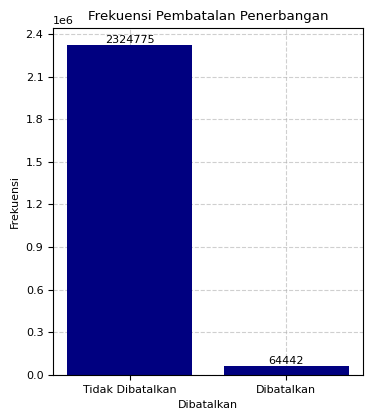

In [ ]:
rcParams.update({'font.size': 8})

fig, ax = plt.subplots(figsize = (4,4.5))
ax.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

jumlah_cancel = penerbangan['Cancelled'].value_counts()
x = ['Tidak Dibatalkan', 'Dibatalkan']
bars = ax.bar(x, jumlah_cancel, color = 'navy', zorder = 2)

ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto'))

for bar in bars:
  yval = bar.get_height()
  ax.text(bar.get_x() + bar.get_width() / 2, yval + 100, yval, ha = 'center', va = 'bottom')

ax.set_ylabel('Frekuensi')
ax.set_xlabel('Dibatalkan')
plt.title('Frekuensi Pembatalan Penerbangan')
plt.show()

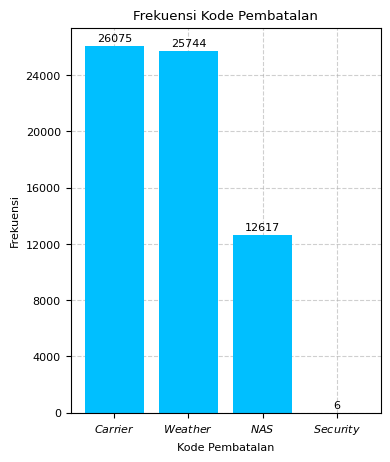

In [ ]:
fig, ax = plt.subplots(figsize = (4,5))
ax.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

kode = ['A', 'B', 'C', 'D']
jumlah_cancel_new = penerbangan['CancellationCode'].value_counts()[kode]

x = ['$\t{Carrier}$', '$\t{Weather}$', '$\t{NAS}$', '$\t{Security}$']
ax.bar(x, jumlah_cancel_new, color = 'deepskyblue', zorder = 2)

ax.set_xlabel('Kode Pembatalan')
ax.set_ylabel('Frekuensi')
ax.set_title('Frekuensi Kode Pembatalan')

ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto'))
for i in range(jumlah_cancel_new.shape[0]):
  count = jumlah_cancel_new[i]
  ax.text(i, count + 900, count, ha = 'center', va = 'top')

plt.show()

In [ ]:
print('Departure delay minimum adalah ' + str(int(penerbangan['DepDelay'].min())) + ' menit.')
print('Departure delay maksimum adalah ' + str(int(penerbangan['DepDelay'].max())) + ' menit.')
print('Arrival delay minimum adalah ' + str(int(penerbangan['ArrDelay'].min())) + ' menit.')
print('Arrival delay maksimum adalah ' + str(int(penerbangan['ArrDelay'].max())) + ' menit.')

Departure delay minimum adalah -92 menit.
Departure delay maksimum adalah 2467 menit.
Arrival delay minimum adalah -91 menit.
Arrival delay maksimum adalah 2461 menit.


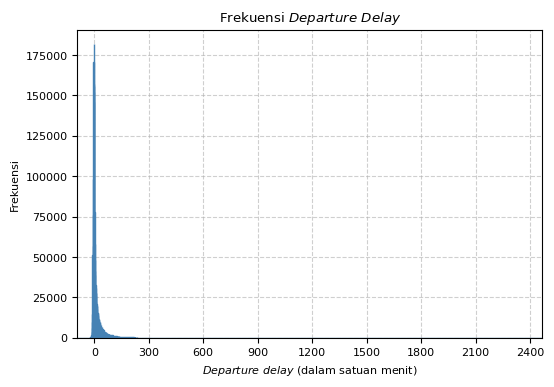

In [ ]:
fig, ax = plt.subplots(figsize = (6,4))
ax.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

space = np.arange(penerbangan['DepDelay'].min() - 1, penerbangan['DepDelay'].max() + 1, 1)
ax.set_xlim(penerbangan['DepDelay'].min() - 1, penerbangan['DepDelay'].max() + 1)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto'))

ax.hist(penerbangan['DepDelay'], bins = space, edgecolor = 'steelblue',
        color = 'steelblue', zorder = 2)

ax.set_xlabel('$\t{Departure\ delay}$ (dalam satuan menit)')
ax.set_ylabel('Frekuensi')
ax.set_title('Frekuensi $\t{Departure\ Delay}$')

plt.show()

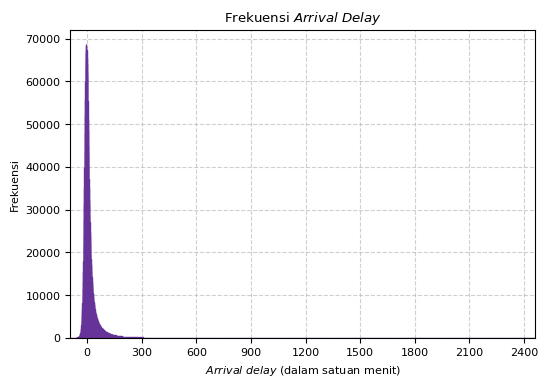

In [ ]:
fig, ax = plt.subplots(figsize = (6,4))
ax.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

space_new = np.arange(penerbangan['ArrDelay'].min() - 1, penerbangan['ArrDelay'].max() + 1, 1)
ax.set_xlim(penerbangan['ArrDelay'].min() - 1, penerbangan['ArrDelay'].max() + 1)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto'))

ax.hist(penerbangan['ArrDelay'], bins = space_new, edgecolor = 'rebeccapurple',
        color = 'rebeccapurple', zorder = 2)

ax.set_xlabel('$\t{Arrival\ delay}$ (dalam satuan menit)')
ax.set_ylabel('Frekuensi')
ax.set_title('Frekuensi $\t{Arrival\ Delay}$')

plt.show()

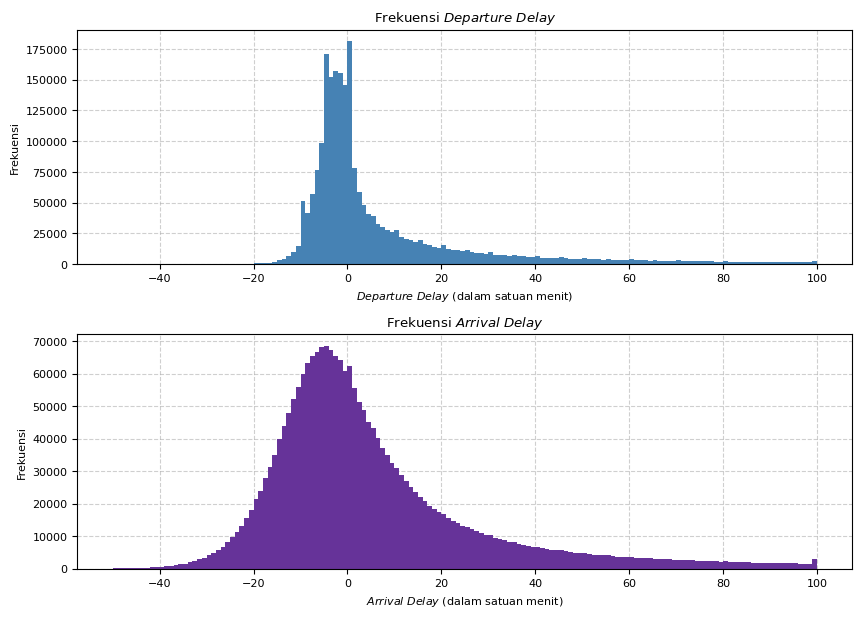

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))
bins = np.arange(-50, 100 + 1, 1)

axs[0].hist(data = penerbangan, x = 'DepDelay', bins = bins, color = 'steelblue', zorder = 2)
axs[0].set_xlabel('$\t{Departure\ Delay}$ (dalam satuan menit)')
axs[0].set_ylabel('Frekuensi')
axs[0].set_title('Frekuensi $\t{Departure\ Delay}$');
axs[0].grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

fig.subplots_adjust(hspace = 0.3)

axs[1].hist(data = penerbangan, x = 'ArrDelay', bins = bins, color = 'rebeccapurple', zorder = 2)
axs[1].set_xlabel('$\t{Arrival\ Delay}$ (dalam satuan menit)')
axs[1].set_ylabel('Frekuensi')
axs[1].set_title('Frekuensi $\t{Arrival\ Delay}$')
axs[1].grid(True, linestyle = '--', alpha = 0.6, zorder = 1);

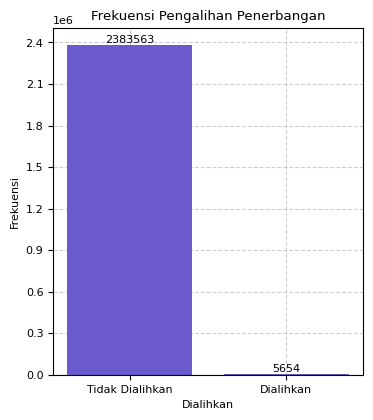

In [ ]:
fig, ax = plt.subplots(figsize = (4, 4.5))
ax.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

jumlah_cancel = penerbangan['Diverted'].value_counts()
x = ['Tidak Dialihkan', 'Dialihkan']
bars = ax.bar(x, jumlah_cancel, color = 'slateblue', zorder = 2)

ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins = 'auto'))

for bar in bars:
  yval = bar.get_height()
  ax.text(bar.get_x() + bar.get_width() / 2, yval + 100, yval, ha = 'center', va = 'bottom')

ax.set_ylabel('Frekuensi')
ax.set_xlabel('Dialihkan')
plt.title('Frekuensi Pengalihan Penerbangan')
plt.show()

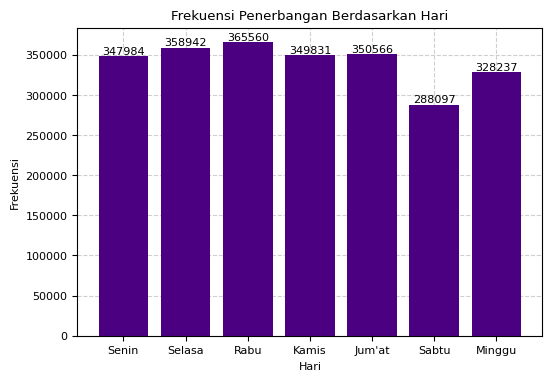

In [ ]:
plt.figure(figsize = (6,4))
plt.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

hitung = penerbangan['DayOfWeek'].value_counts().sort_index()
bars = plt.bar(hitung.index, hitung, color = "indigo", zorder = 2)

plt.xlabel('Hari')
plt.ylabel('Frekuensi')
plt.title('Frekuensi Penerbangan Berdasarkan Hari')

for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2, yval + 100, yval, ha = 'center', va = 'bottom')

plt.show()

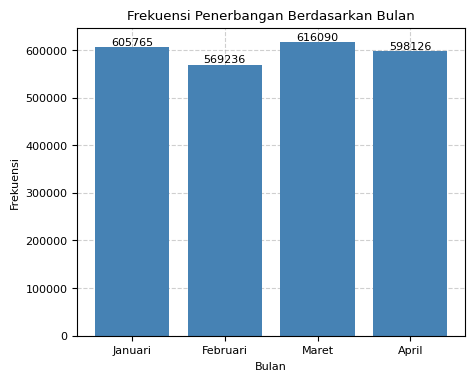

In [ ]:
plt.figure(figsize = (5,4))
plt.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

bln = penerbangan['Month'].value_counts().sort_index()
bars = plt.bar(bln.index, bln, color = "steelblue", zorder = 2)

plt.xlabel('Bulan')
plt.ylabel('Frekuensi')
plt.title('Frekuensi Penerbangan Berdasarkan Bulan')

for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2, yval + 100, yval, ha = 'center', va = 'bottom')

plt.show()

In [ ]:
penerbangan['Distance'].describe()

count    2.389217e+06
mean     7.261589e+02
std      5.571763e+02
min      1.700000e+01
25%      3.250000e+02
50%      5.830000e+02
75%      9.570000e+02
max      4.962000e+03
Name: Distance, dtype: float64

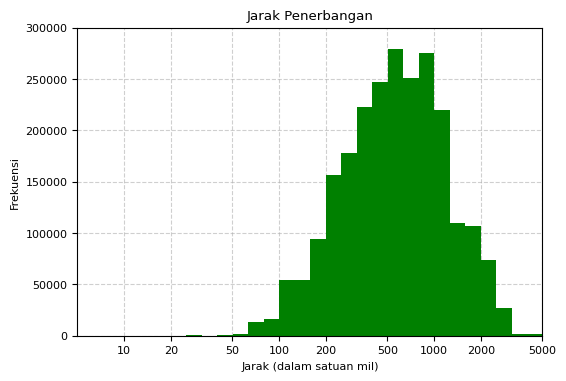

In [ ]:
bins = 10**np.arange(-1, 3.7 + 0.1, 0.1)

plt.figure(figsize = (6,4))
plt.hist(data = penerbangan, x = 'Distance', bins = bins, color = "green", zorder = 2)
plt.xscale('log')

plt.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)
plt.xlim(5, 5000)
plt.gca().xaxis.set_minor_formatter(NullFormatter())
plt.gca().xaxis.set_minor_locator(NullLocator())

x_titik = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
x_label = ['{}'.format(v) for v in x_titik]
plt.xticks(x_titik, x_label)
y_titik = np.arange(0, 3e5 + 5e4, 5e4)
y_label = ['0', '50000', '100000', '150000', '200000', '250000', '300000']
plt.yticks(y_titik, y_label)

plt.title('Jarak Penerbangan')
plt.ylabel('Frekuensi')
plt.xlabel('Jarak (dalam satuan mil)');

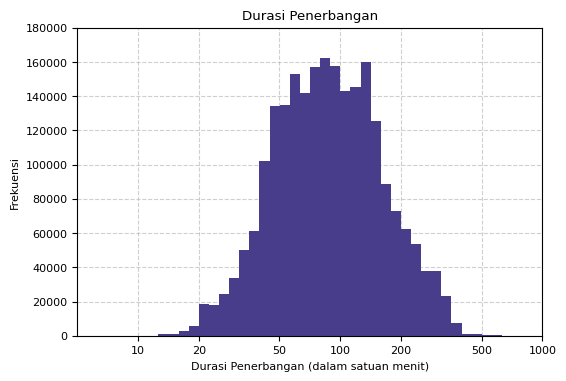

In [ ]:
bins = 10**np.arange(-1, 3 + 0.05, 0.05)

plt.figure(figsize = (6,4))
plt.hist(data = penerbangan, x = 'AirTime', bins = bins, color = "darkslateblue", zorder = 2)
plt.xscale('log')

plt.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)
plt.xlim(5, 1000)
plt.gca().xaxis.set_minor_formatter(NullFormatter())
plt.gca().xaxis.set_minor_locator(NullLocator())

x_titik = [10, 20, 50, 100, 200, 500, 1000]
x_label = ['{}'.format(v) for v in x_titik]
plt.xticks(x_titik, x_label)
y_titik = np.arange(0, 18e4 + 2e4, 2e4)
y_label = ['0', '20000', '40000', '60000', '80000', '100000',
           '120000', '140000', '160000', '180000']
plt.yticks(y_titik, y_label)

plt.title('Durasi Penerbangan')
plt.ylabel('Frekuensi')
plt.xlabel('Durasi Penerbangan (dalam satuan menit)');

In [ ]:
frek_asal = penerbangan['Origin'].value_counts()
frek_dest = penerbangan['Dest'].value_counts()
threshold = 15

order_asal = frek_asal.index[:threshold]
order_dest = frek_dest.index[:threshold]

sub_asal = penerbangan.loc[penerbangan['Origin'].isin(order_asal)]
sub_dest = penerbangan.loc[penerbangan['Dest'].isin(order_dest)]

count_asal = sub_asal['Origin'].value_counts().values
count_dest = sub_dest['Dest'].value_counts().values

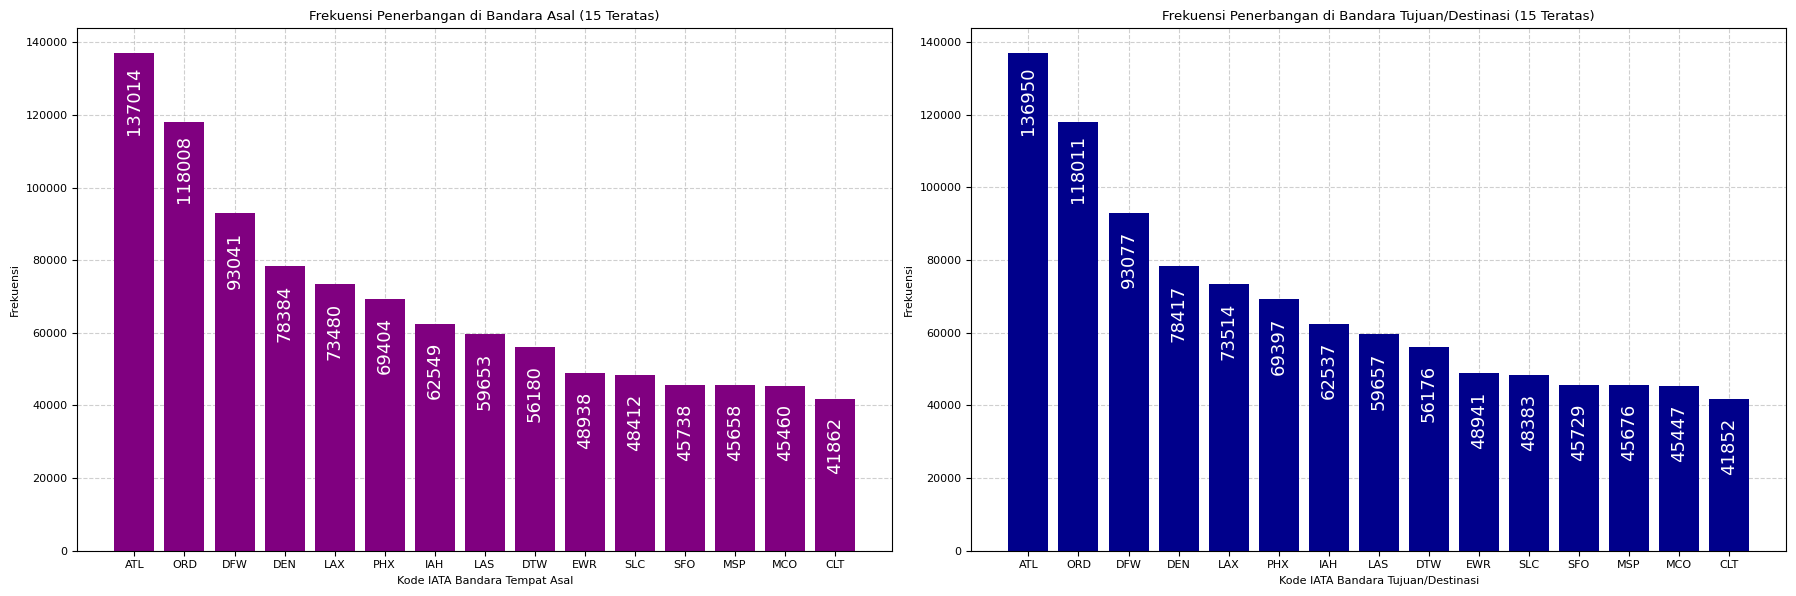

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (18, 6))

axs[0].bar(order_asal, count_asal, color = 'purple', zorder = 2)
axs[0].set_ylabel('Frekuensi')
axs[0].set_xlabel('Kode IATA Bandara Tempat Asal')
axs[0].set_title('Frekuensi Penerbangan di Bandara Asal (15 Teratas)')
axs[0].grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

for i in range(len(count_asal)):
  axs[0].text(i, count_asal[i] - 13000, count_asal[i], ha = 'center',
              va = 'center', rotation = 90, color = 'white', size = 13)

axs[1].bar(order_dest, count_dest, color = 'darkblue', zorder = 2)
axs[1].set_ylabel('Frekuensi')
axs[1].set_xlabel('Kode IATA Bandara Tujuan/Destinasi')
axs[1].set_title('Frekuensi Penerbangan di Bandara Tujuan/Destinasi (15 Teratas)')
axs[1].grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

for i in range(len(count_dest)):
  axs[1].text(i, count_dest[i] - 13000, count_dest[i], ha = 'center',
              va = 'center', rotation = 90, color = 'white', size = 13)
plt.tight_layout()
plt.show()

In [ ]:
print('Terdapat ' + str(len(penerbangan['UniqueCarrier'].unique())) +\
      ' maskapai yang terdaftar dalam dataset ini.')

Terdapat 20 maskapai yang terdaftar dalam dataset ini.


In [ ]:
urutan = penerbangan['UniqueCarrier'].value_counts().index
urutan

Index(['WN', 'AA', 'OO', 'MQ', 'UA', 'US', 'DL', 'XE', 'NW', 'CO', 'EV', '9E',
       'FL', 'YV', 'OH', 'B6', 'AS', 'F9', 'HA', 'AQ'],
      dtype='object')

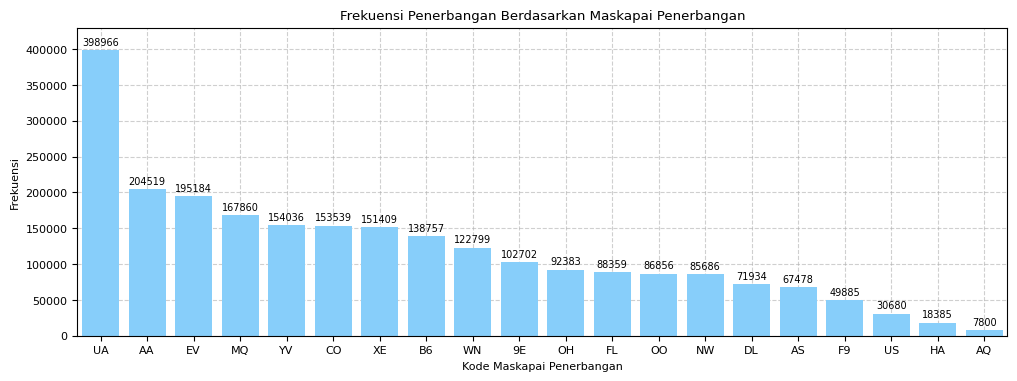

In [ ]:
rcParams.update({'font.size': 8})

plt.figure(figsize = (12,4))
plt.bar(urutan, penerbangan['UniqueCarrier'].value_counts(), color = 'lightskyblue', zorder = 2)
plt.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

plt.xlim(-0.5, len(urutan) - 0.5)
plt.ylim(0, 430000)
plt.ylabel('Frekuensi')
plt.xlabel('Kode Maskapai Penerbangan')
plt.title('Frekuensi Penerbangan Berdasarkan Maskapai Penerbangan')

count_pesawat = penerbangan['UniqueCarrier'].value_counts()
for i in range (count_pesawat.shape[0]):
  count = count_pesawat[i]
  plt.text(i, count + 18000, count, ha = 'center', va = 'top', size = 7);

## Eksplorasi Bivariat

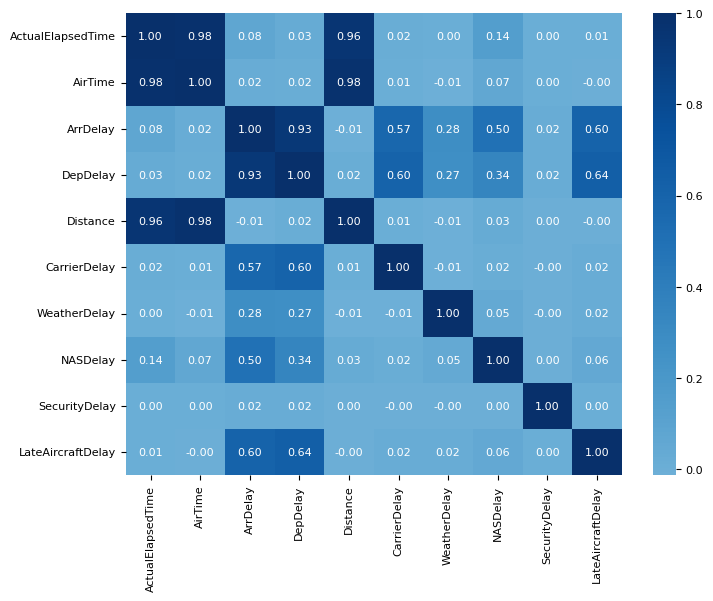

In [ ]:
variabel_numerik = ['ActualElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance',
                    'CarrierDelay','WeatherDelay',	'NASDelay',	'SecurityDelay', 'LateAircraftDelay']

plt.figure(figsize = (8,6))
sns.heatmap(penerbangan[variabel_numerik].corr(), annot = True, fmt = '.2f', cmap = 'Blues', center = 0)
plt.show();

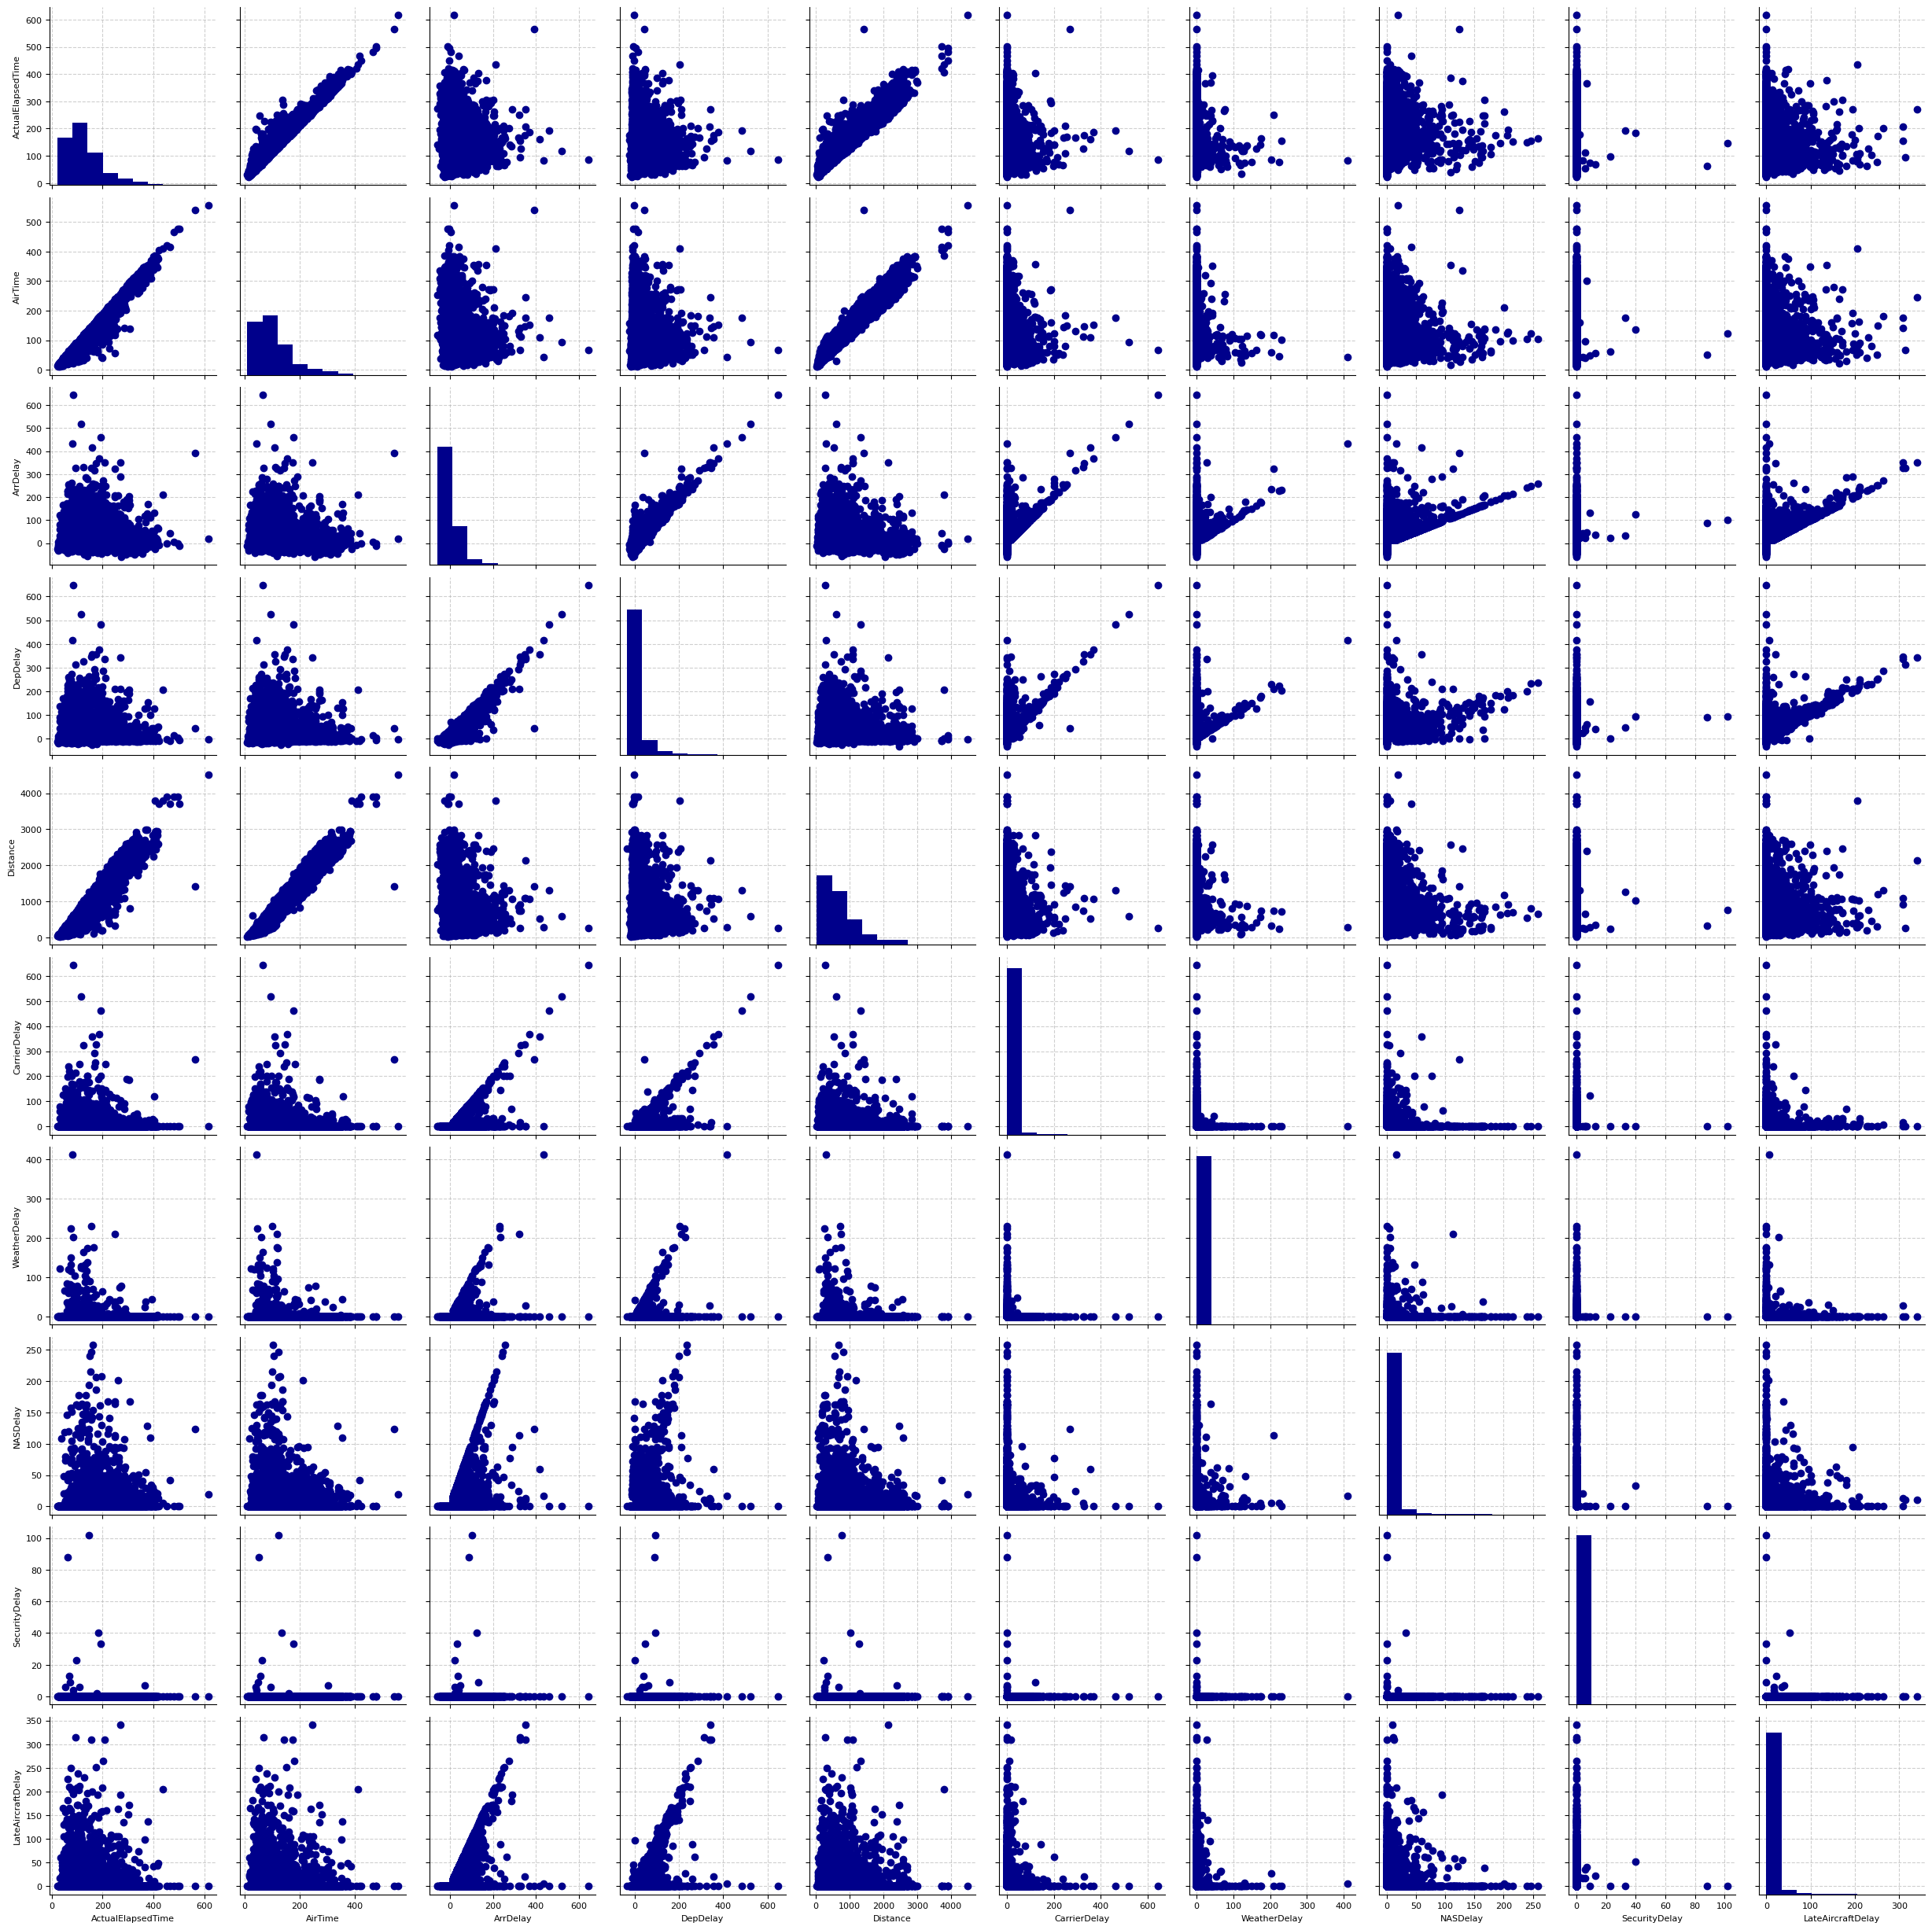

In [ ]:
sampel = np.random.choice(penerbangan.shape[0], 10000, replace = False)
sampel_terbang = penerbangan.loc[sampel,:]

lots = sns.PairGrid(data = sampel_terbang, vars = variabel_numerik)
lots = lots.map_diag(plt.hist, bins = 10, color = 'darkblue', zorder = 2)
lots.map_offdiag(plt.scatter, color = 'darkblue', zorder = 2)
for ax in lots.axes.flatten():
  ax.grid(True, linestyle = '--', alpha = 0.6, zorder = 1);

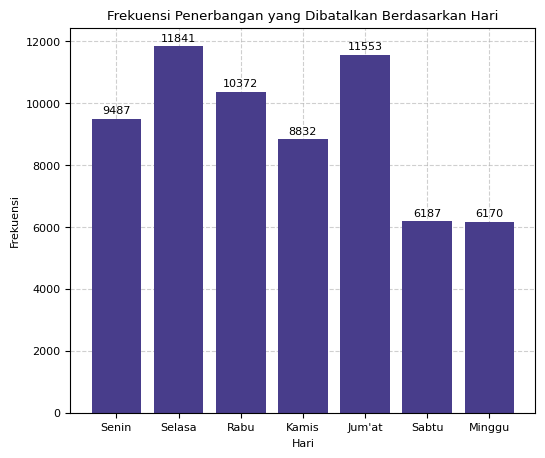

In [ ]:
plt.figure(figsize = (6,5))
plt.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

cancel_penerbangan = penerbangan[penerbangan['Cancelled'] == 1]
cancel_count = cancel_penerbangan['DayOfWeek'].value_counts()
cancel_count = cancel_count.reindex(hari)
bars = plt.bar(cancel_count.index, cancel_count.values, color = "darkslateblue", zorder = 2)

for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2, yval + 100, yval, ha = 'center', va = 'bottom')

plt.title('Frekuensi Penerbangan yang Dibatalkan Berdasarkan Hari')
plt.xlabel('Hari')
plt.ylabel('Frekuensi');

In [ ]:
penerbangan['Cancelled'].mean()

0.026972016355148988

In [ ]:
hari_rata = penerbangan.groupby('DayOfWeek', as_index = False).mean(numeric_only = True)
hari_rata

DayOfWeek    Year  DayofMonth    FlightNum  ActualElapsedTime  \
0     Senin  2008.0   16.662427  2223.238606         127.840537   
1    Selasa  2008.0   15.038834  2209.909980         128.199643   
2      Rabu  2008.0   15.975378  2224.709016         126.991325   
3     Kamis  2008.0   16.151239  2220.490194         128.371085   
4    Jum'at  2008.0   15.355508  2218.707864         129.039905   
5     Sabtu  2008.0   14.643919  2190.617007         131.175208   
6    Minggu  2008.0   15.646847  2204.514317         129.266385   

   CRSElapsedTime     AirTime   ArrDelay   DepDelay    Distance    TaxiIn  \
0      128.454466  104.395835  10.736384  11.830805  718.140423  6.789648   
1      128.252338  104.595394  10.584612  11.194131  716.673658  6.787882   
2      128.312957  103.821266   7.776017   9.390146  716.951726  6.737166   
3      128.764167  104.503995  10.248991  10.998889  720.152496  6.816513   
4      128.803218  104.639271  14.630594  14.768929  720.630766  6.974399   
5      133.346527  108.418612   7.509435  10.001837  761.042677  6.816639   
6      130.555623  106.018129  10.066515  11.750415  736.974394  6.965339   

     TaxiOut  Cancelled  Diverted  CarrierDelay  WeatherDelay  NASDelay  \
0  16.662573   0.027263  0.002411      3.727168      0.694285  4.210398   
1  16.827042   0.032989  0.002948      3.435260      0.813638  4.732804   
2  16.437661   0.028373  0.002005      3.501855      0.549724  3.349160   
3  17.056830   0.025246  0.001961      3.792640      0.600844  3.801807   
4  17.438517   0.032955  0.002450      4.329422      0.979502  4.972008   
5  15.951889   0.021475  0.002711      4.097262      0.734739  2.949357   
6  16.289207   0.018797  0.002127      4.185326      0.663518  3.457812   

   SecurityDelay  LateAircraftDelay  Ditunda/Delay  
0       0.015541           5.371876       0.419258  
1       0.013779           5.084746       0.382689  
2       0.019764           4.125706       0.379965  
3       0.016888           5.095340       0.424368  
4       0.022327           6.565269       0.472833  
5       0.028206           4.253703       0.397720  
6       0.023139           5.332830       0.434412

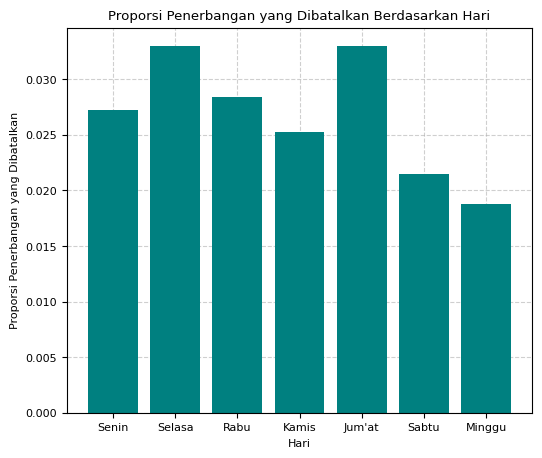

In [ ]:
plt.figure(figsize = (6,5))
plt.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)
plt.bar(data = hari_rata, x = 'DayOfWeek', height = 'Cancelled',
        color = 'teal', zorder = 2)

plt.xlabel('Hari')
plt.ylabel('Proporsi Penerbangan yang Dibatalkan')
plt.title('Proporsi Penerbangan yang Dibatalkan Berdasarkan Hari');

In [ ]:
bandara_rata = penerbangan.groupby('Origin', as_index = False).mean(numeric_only = True)
bandara_rata

Origin    Year  DayofMonth    FlightNum  ActualElapsedTime  \
0      ABE  2008.0   15.658173  4210.604723         114.701847   
1      ABI  2008.0   15.665533  3423.365079          55.880282   
2      ABQ  2008.0   15.677058  1681.235316         109.088237   
3      ABY  2008.0   15.698565  4473.203349          54.241463   
4      ACT  2008.0   15.657790  3265.936085          50.861538   
..     ...     ...         ...          ...                ...   
286    WRG  2008.0   15.636364    64.500000          29.797357   
287    XNA  2008.0   15.710008  4030.132538         111.454364   
288    YAK  2008.0   15.636364    63.500000          47.260870   
289    YKM  2008.0   16.027473  3862.659341         101.162011   
290    YUM  2008.0   15.676371  4124.604604          69.260417   

     CRSElapsedTime    AirTime   ArrDelay   DepDelay    Distance     TaxiIn  \
0        114.727781  90.965040   9.090369   8.411184  526.683654   9.430739   
1         56.894558  36.690141  10.430751  11.395076  158.000000   9.307512   
2        111.276144  91.471470   5.543149   7.812677  649.567175   6.581338   
3         55.031100  34.963415  11.141463  11.970732  146.000000  10.802439   
4         51.749667  30.539860   5.935664   6.832168   89.000000  10.969231   
..              ...        ...        ...        ...         ...        ...   
286       32.615702  17.215859   0.806167   5.217391   56.500000   4.264317   
287      110.405326  86.097475  15.283784  14.441768  578.561558   9.941294   
288       48.628099  36.243478   2.521739   5.923404  206.000000   3.547826   
289       90.000000  81.145251  13.670391   2.508380  586.000000   6.642458   
290       67.774543  48.629861   4.836111   3.427481  233.252539   7.640972   

       TaxiOut  Cancelled  Diverted  CarrierDelay  WeatherDelay  NASDelay  \
0    14.296053   0.055314  0.002486      4.280298      0.594158  5.086389   
1     9.885111   0.032880  0.001134      7.568027      2.643991  2.869615   
2    11.035230   0.010539  0.001400      1.782961      0.181222  1.714423   
3     8.475610   0.019139  0.000000      7.538278      1.074163  3.787081   
4     9.352448   0.047936  0.000000      1.805593      0.579228  1.862850   
..         ...        ...       ...           ...           ...       ...   
286   8.360870   0.049587  0.012397      0.925620      1.132231  1.285124   
287  15.434696   0.052554  0.002303      4.246859      1.134003  7.261935   
288   7.548936   0.028926  0.020661      0.446281      0.198347  0.685950   
289  13.374302   0.016484  0.000000      3.412088      1.000000  1.483516   
290  12.994448   0.024374  0.000677      4.058903      0.000000  1.144211   

     SecurityDelay  LateAircraftDelay  Ditunda/Delay  
0         0.000000           3.378496       0.249223  
1         0.000000           1.730159       0.214286  
2         0.002358           5.333997       0.411747  
3         0.000000           0.669856       0.366029  
4         0.000000           4.660453       0.275632  
..             ...                ...            ...  
286       0.000000           7.132231       0.285124  
287       0.000000           5.757328       0.355318  
288       0.000000          13.227273       0.297521  
289       0.000000           4.714286       0.357143  
290       0.392011           1.441435       0.280975  

[291 rows x 20 columns]

In [ ]:
cancel_asal = bandara_rata['Cancelled'].sort_values(ascending = False)
cancel_prop = bandara_rata['Cancelled'].sort_values(ascending = False)
threshold = 10

cancel_max = cancel_prop.index[:threshold]
cancel_min = cancel_prop.index[-threshold:]

cancel_sub_max = bandara_rata.loc[cancel_max]
cancel_sub_min = bandara_rata.loc[cancel_min]

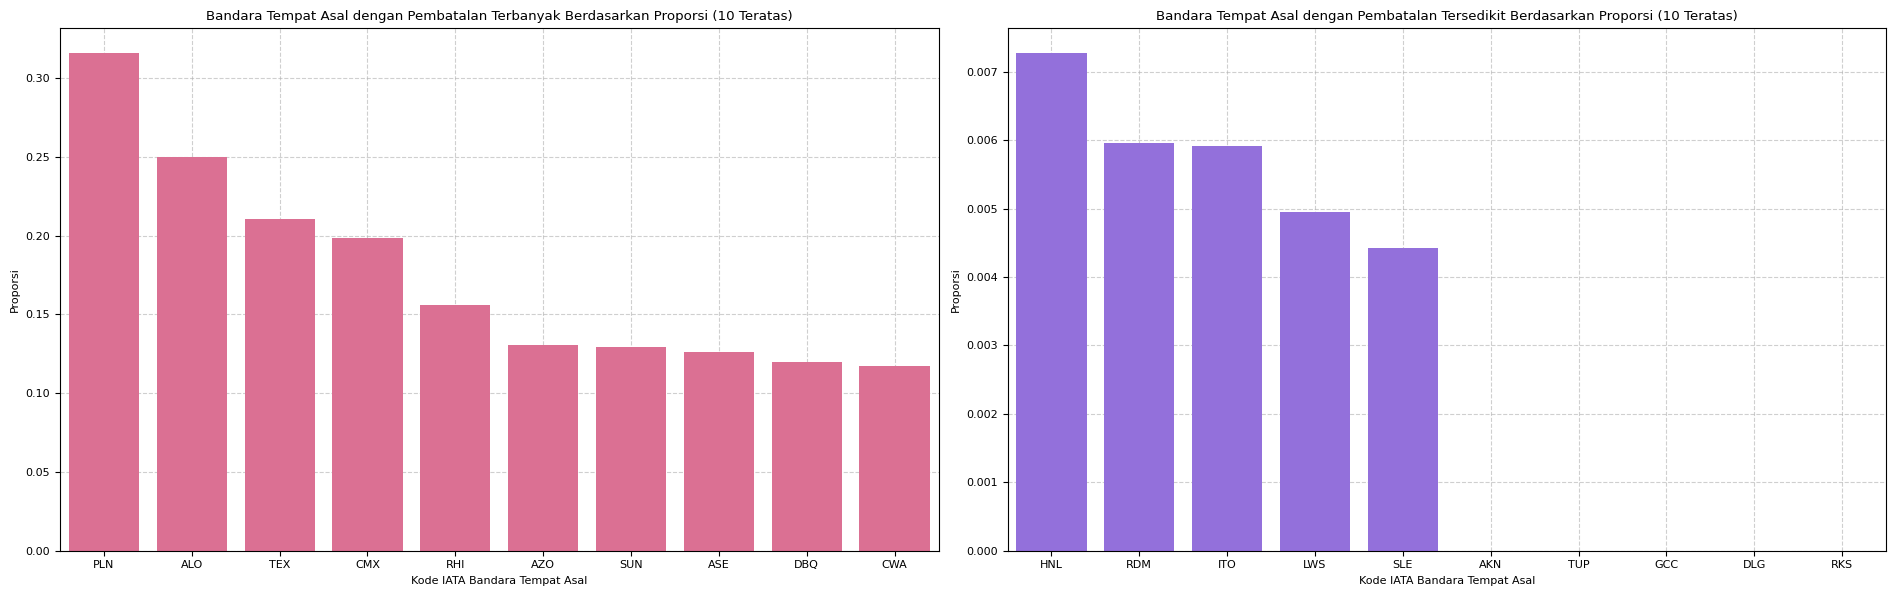

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (19, 6))

axs[0].bar(data = cancel_sub_max, x = 'Origin', height = 'Cancelled',
           color = 'palevioletred', zorder = 2)
axs[0].grid(True, linestyle = '--', alpha = 0.6, zorder = 1)
axs[0].set_ylabel('Proporsi')
axs[0].set_xlabel('Kode IATA Bandara Tempat Asal')
axs[0].set_title('Bandara Tempat Asal dengan Pembatalan Terbanyak Berdasarkan Proporsi (10 Teratas)')
axs[0].set_xlim(-0.5, len(cancel_sub_max['Origin'])-0.5)

axs[1].bar(data = cancel_sub_min, x = 'Origin', height = 'Cancelled',
           color = 'mediumpurple', zorder = 2)
axs[1].grid(True, linestyle = '--', alpha = 0.6, zorder = 1)
axs[1].set_ylabel('Proporsi')
axs[1].set_xlabel('Kode IATA Bandara Tempat Asal')
axs[1].set_title('Bandara Tempat Asal dengan Pembatalan Tersedikit Berdasarkan Proporsi (10 Teratas)')
axs[1].set_xlim(-0.5, len(cancel_sub_min['Origin'])-0.5)
plt.tight_layout();

In [ ]:
prop_batal_tinggi = ['PLN', 'ALO', 'TEX', 'CMX', 'RHI']
jumlah_penerbangan_batal_tinggi = penerbangan.loc[penerbangan['Origin'].isin(prop_batal_tinggi)].shape[0]
print('5 bandara dengan proporsi pembatalan paling tinggi mencakup ' + str(jumlah_penerbangan_batal_tinggi) +\
      ' dari ' + str(penerbangan.shape[0]) + ' penerbangan.')

5 bandara dengan proporsi pembatalan paling tinggi mencakup 461 dari 2389217 penerbangan.


In [ ]:
prop_batal_sedikit = ['HNL', 'RDM', 'ITO', 'LWS', 'SLE']
jumlah_penerbangan_batal_sedikit = penerbangan.loc[penerbangan['Origin'].isin(prop_batal_sedikit)].shape[0]
print('5 bandara dengan proporsi pembatalan paling sedikit mencakup ' + str(jumlah_penerbangan_batal_sedikit) +\
      ' dari ' + str(penerbangan.shape[0]) + ' penerbangan.')

5 bandara dengan proporsi pembatalan paling sedikit mencakup 23839 dari 2389217 penerbangan.


In [ ]:
tidak_ada_batal = ['AKN', 'TUP', 'GCC', 'DLG', 'RKS']
jumlah_penerbangan_tidak_batal = penerbangan.loc[penerbangan['Origin'].isin(tidak_ada_batal)].shape[0]
print('Bandara yang tidak memiliki pembatalan mencakup ' + str(jumlah_penerbangan_tidak_batal) +\
      ' dari ' + str(penerbangan.shape[0]) + ' penerbangan.')

Bandara yang tidak memiliki pembatalan mencakup 172 dari 2389217 penerbangan.


In [ ]:
kode_rata = penerbangan.groupby('UniqueCarrier').mean(numeric_only = True)
urutan = kode_rata['DepDelay'].sort_values(ascending = False).index
urutan

Index(['UA', 'AA', 'EV', 'MQ', 'YV', 'CO', 'XE', 'B6', 'WN', '9E', 'OH', 'FL',
       'OO', 'NW', 'DL', 'AS', 'F9', 'US', 'HA', 'AQ'],
      dtype='object', name='UniqueCarrier')

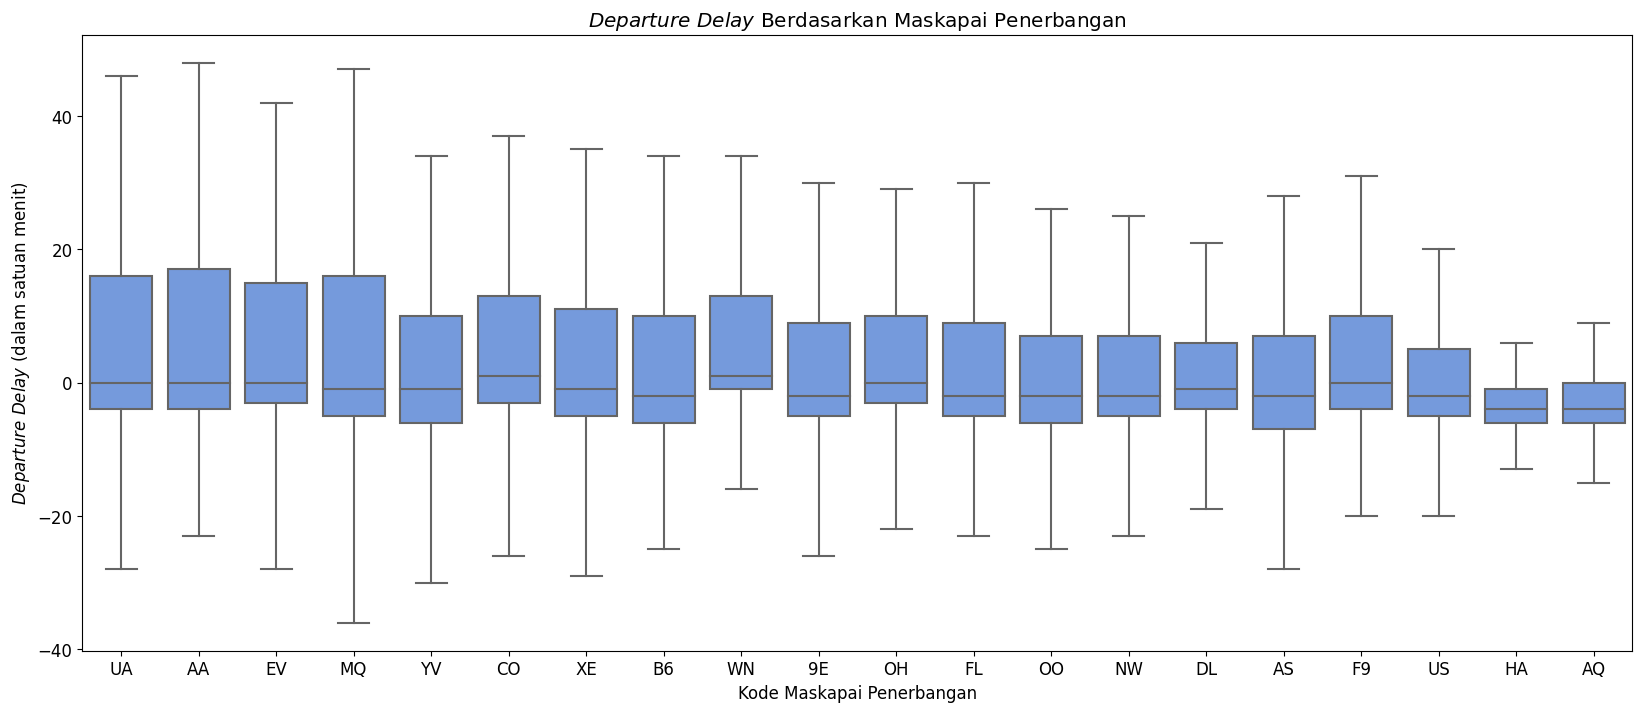

In [ ]:
plt.figure(figsize = (20,8))
rcParams.update({'font.size': 12})
sns.boxplot(data = penerbangan, x = 'UniqueCarrier', y = 'DepDelay', color = 'cornflowerblue',
            order = urutan, showfliers = False)

plt.xlabel('Kode Maskapai Penerbangan')
plt.ylabel('$\t{Departure\ Delay}$ (dalam satuan menit)')
plt.title('$\t{Departure\ Delay}$ Berdasarkan Maskapai Penerbangan');

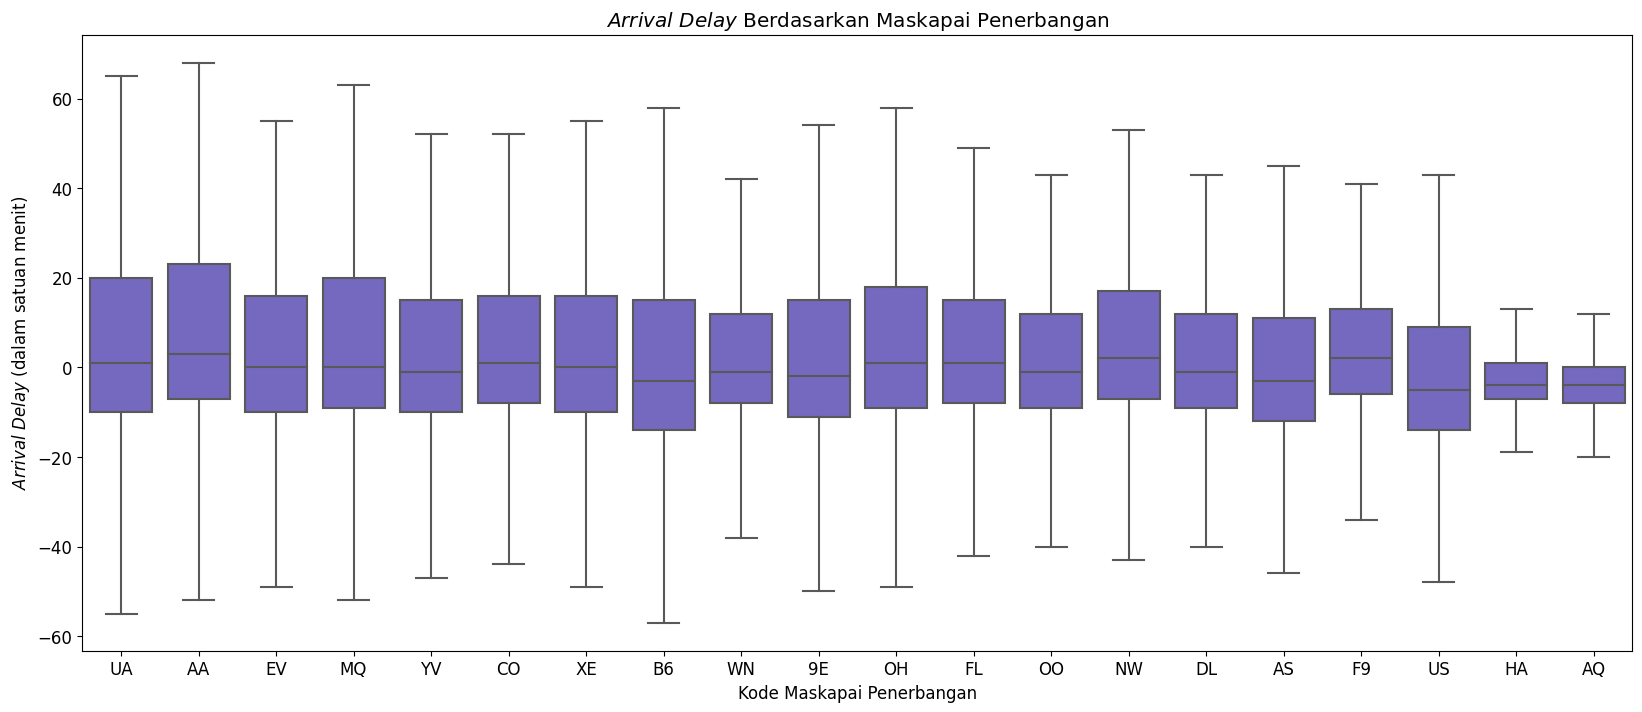

In [ ]:
plt.figure(figsize = (20,8))
sns.boxplot(data = penerbangan, x = 'UniqueCarrier', y = 'ArrDelay', color = 'slateblue',
            order = urutan, showfliers = False)

plt.xlabel('Kode Maskapai Penerbangan')
plt.ylabel('$\t{Arrival\ Delay}$ (dalam satuan menit)')
plt.title('$\t{Arrival\ Delay}$ Berdasarkan Maskapai Penerbangan');

In [ ]:
def cancel_oleh_maskapai(var, title):
    plt.figure(figsize = (12, 4))
    cancel = penerbangan.groupby('UniqueCarrier').mean(numeric_only = True)

    order = cancel[var].sort_values(ascending = False).index

    sns.barplot(data = cancel, x = cancel.index, y = var, zorder = 2,
                order = order, color = 'lightskyblue');

    plt.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)
    plt.xlim(-0.5, len(order) - 0.5)

    plt.xlabel('Kode Maskapai Penerbangan')
    plt.ylabel('Proporsi ' + title)
    plt.title('Proporsi ' + title + ' Berdasarkan Maskapai Penerbangan');

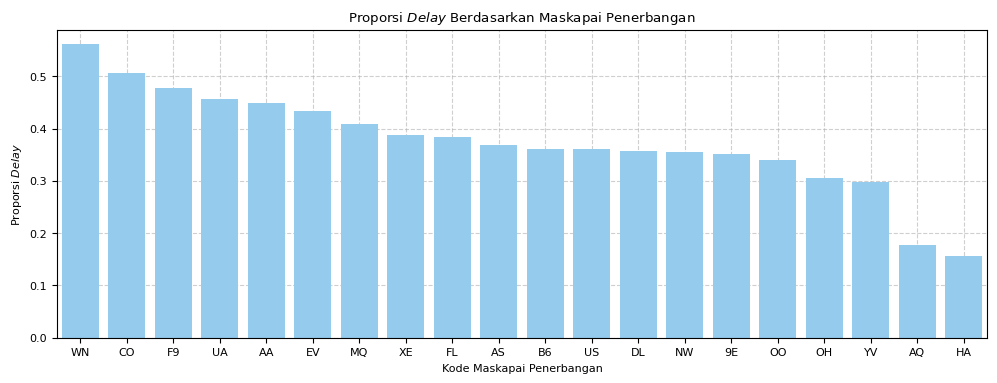

In [ ]:
rcParams.update({'font.size': 8})
cancel_oleh_maskapai('Ditunda/Delay', '$\t{Delay}$')

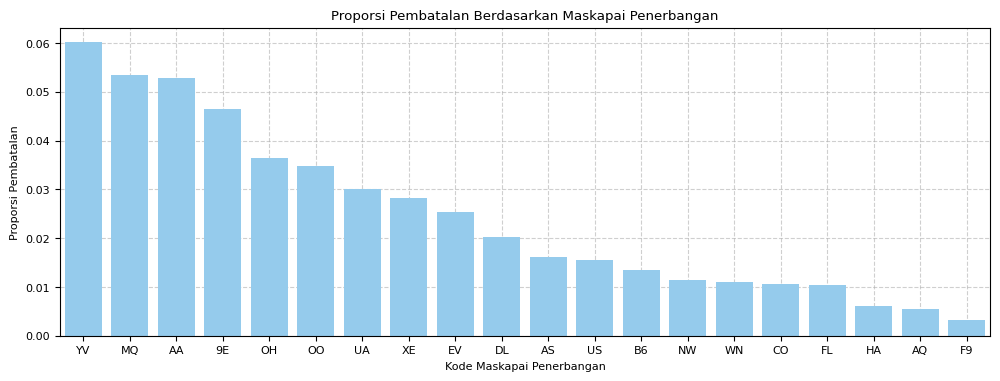

In [ ]:
cancel_oleh_maskapai('Cancelled', 'Pembatalan')

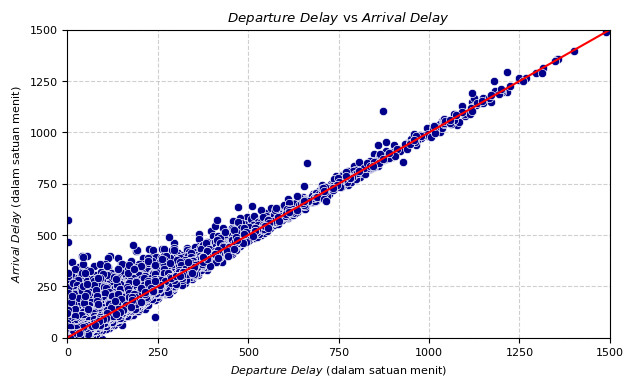

In [ ]:
plt.figure(figsize = (7, 4))
sns.scatterplot(data = penerbangan, x = 'DepDelay', y = 'ArrDelay',
                color = 'darkblue', zorder = 2)
plt.plot([0, 2500], [0, 2500], color = 'red')
plt.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

lim = (0, 1500)
tick = np.arange(0, 1500 + 1, 250)
plt.xlim(lim)
plt.ylim(lim)
plt.yticks(tick)
plt.xticks(tick)

plt.ylabel('$\t{Arrival\ Delay}$ (dalam satuan menit)')
plt.xlabel('$\t{Departure\ Delay}$ (dalam satuan menit)')
plt.title('$\t{Departure\ Delay}$ vs $\t{Arrival\ Delay}$');

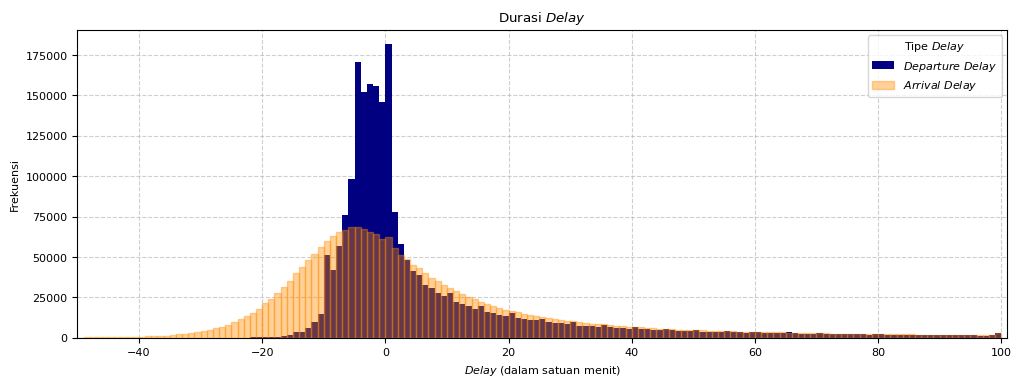

In [ ]:
plt.figure(figsize = (12, 4))

bins = np.arange(-50, 100 + 1, 1)

plt.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)
plt.hist(data = penerbangan, x = 'DepDelay', bins = bins, color = 'navy',
         zorder = 2)
plt.hist(data = penerbangan, x = 'ArrDelay', bins = bins, ec = 'darkorange',
         color = 'darkorange', alpha = 0.4, zorder = 3)

plt.xlim(-50, 100 + 1)
plt.ylabel('Frekuensi')
plt.xlabel('$\t{Delay}$ (dalam satuan menit)')
plt.title('Durasi $\t{Delay}$')
plt.legend(['$\t{Departure\ Delay}$','$\t{Arrival\ Delay}$'], title = 'Tipe $\t{Delay}$');

## Eksplorasi Multivariat

In [ ]:
maskapai = penerbangan[penerbangan['CarrierDelay'] > 0].groupby('DayOfWeek').mean(numeric_only = True)
cuaca = penerbangan[penerbangan['WeatherDelay'] > 0].groupby('DayOfWeek').mean(numeric_only = True)
nas = penerbangan[penerbangan['NASDelay'] > 0].groupby('DayOfWeek').mean(numeric_only = True)
security = penerbangan[penerbangan['SecurityDelay'] > 0].groupby('DayOfWeek').mean(numeric_only = True)
pesawat_telat = penerbangan[penerbangan['LateAircraftDelay'] > 0].groupby('DayOfWeek').mean(numeric_only = True)

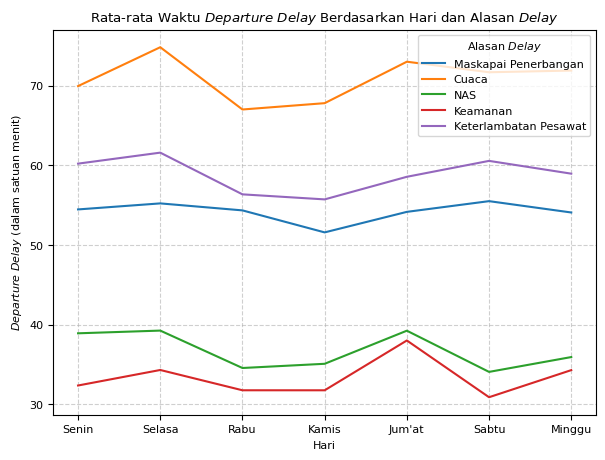

In [ ]:
plt.figure(figsize = (7,5))
plt.grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

plt.plot(maskapai['DepDelay'], zorder = 2)
plt.plot(cuaca['DepDelay'], zorder = 2)
plt.plot(nas['DepDelay'], zorder = 2)
plt.plot(security['DepDelay'], zorder = 2)
plt.plot(pesawat_telat['DepDelay'], zorder = 2)

plt.ylabel('$\t{Departure\ Delay}$ (dalam satuan menit)')
plt.xlabel('Hari')
plt.title('Rata-rata Waktu $\t{Departure\ Delay}$ Berdasarkan Hari dan Alasan $\t{Delay}$')
plt.legend(['Maskapai Penerbangan', 'Cuaca', 'NAS', 'Keamanan', 'Keterlambatan Pesawat'],
           title = 'Alasan $\t{Delay}$');

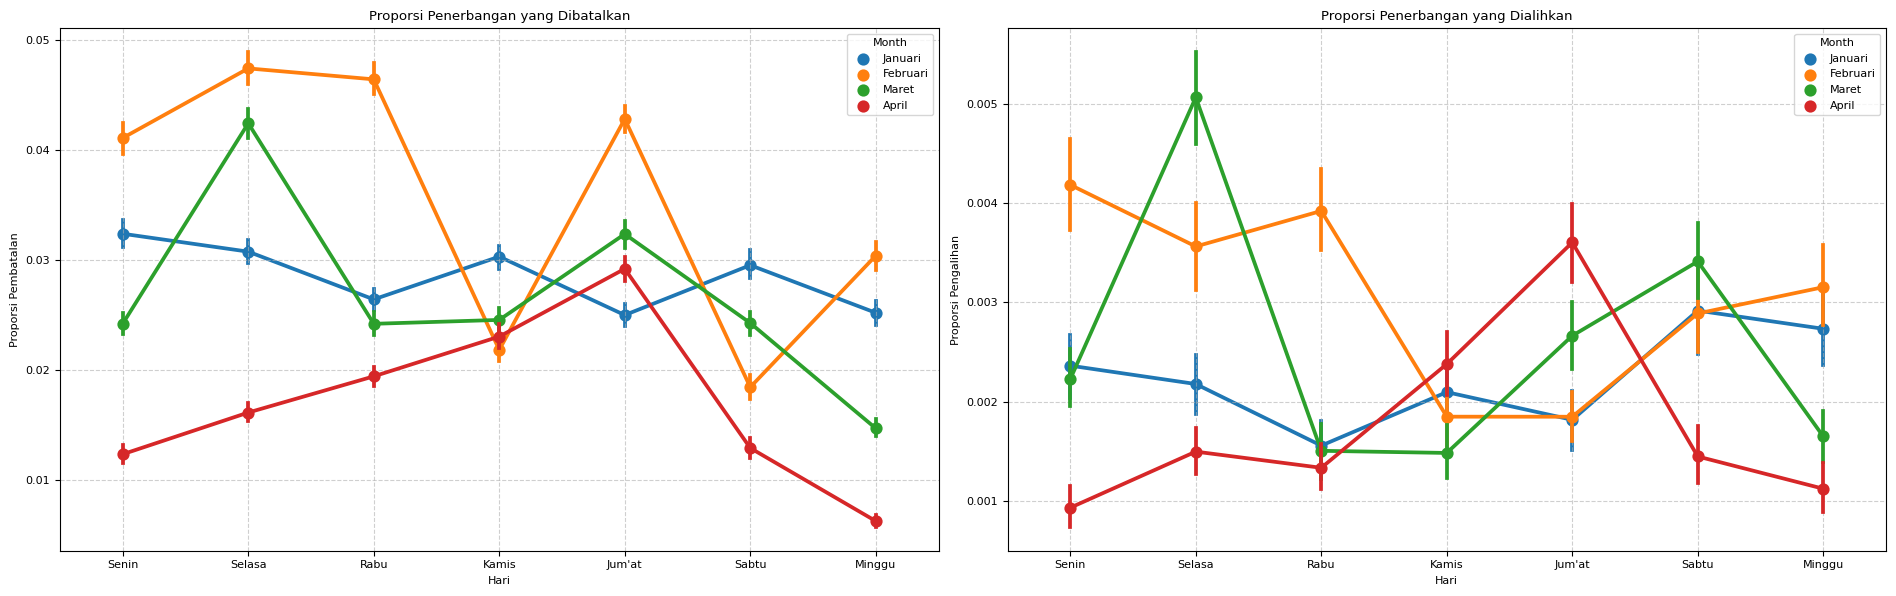

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (19, 6))

sns.pointplot(data = penerbangan, x = 'DayOfWeek', y = 'Cancelled',
              hue = 'Month', ax = axs[0])
axs[0].set_xlabel('Hari')
axs[0].set_ylabel('Proporsi Pembatalan')
axs[0].set_title('Proporsi Penerbangan yang Dibatalkan')
axs[0].grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

sns.pointplot(data = penerbangan, x = 'DayOfWeek', y = 'Diverted',
              hue = 'Month', ax = axs[1])
axs[1].set_xlabel('Hari')
axs[1].set_ylabel('Proporsi Pengalihan')
axs[1].set_title('Proporsi Penerbangan yang Dialihkan')
axs[1].grid(True, linestyle = '--', alpha = 0.6, zorder = 1)

plt.tight_layout()
plt.show();

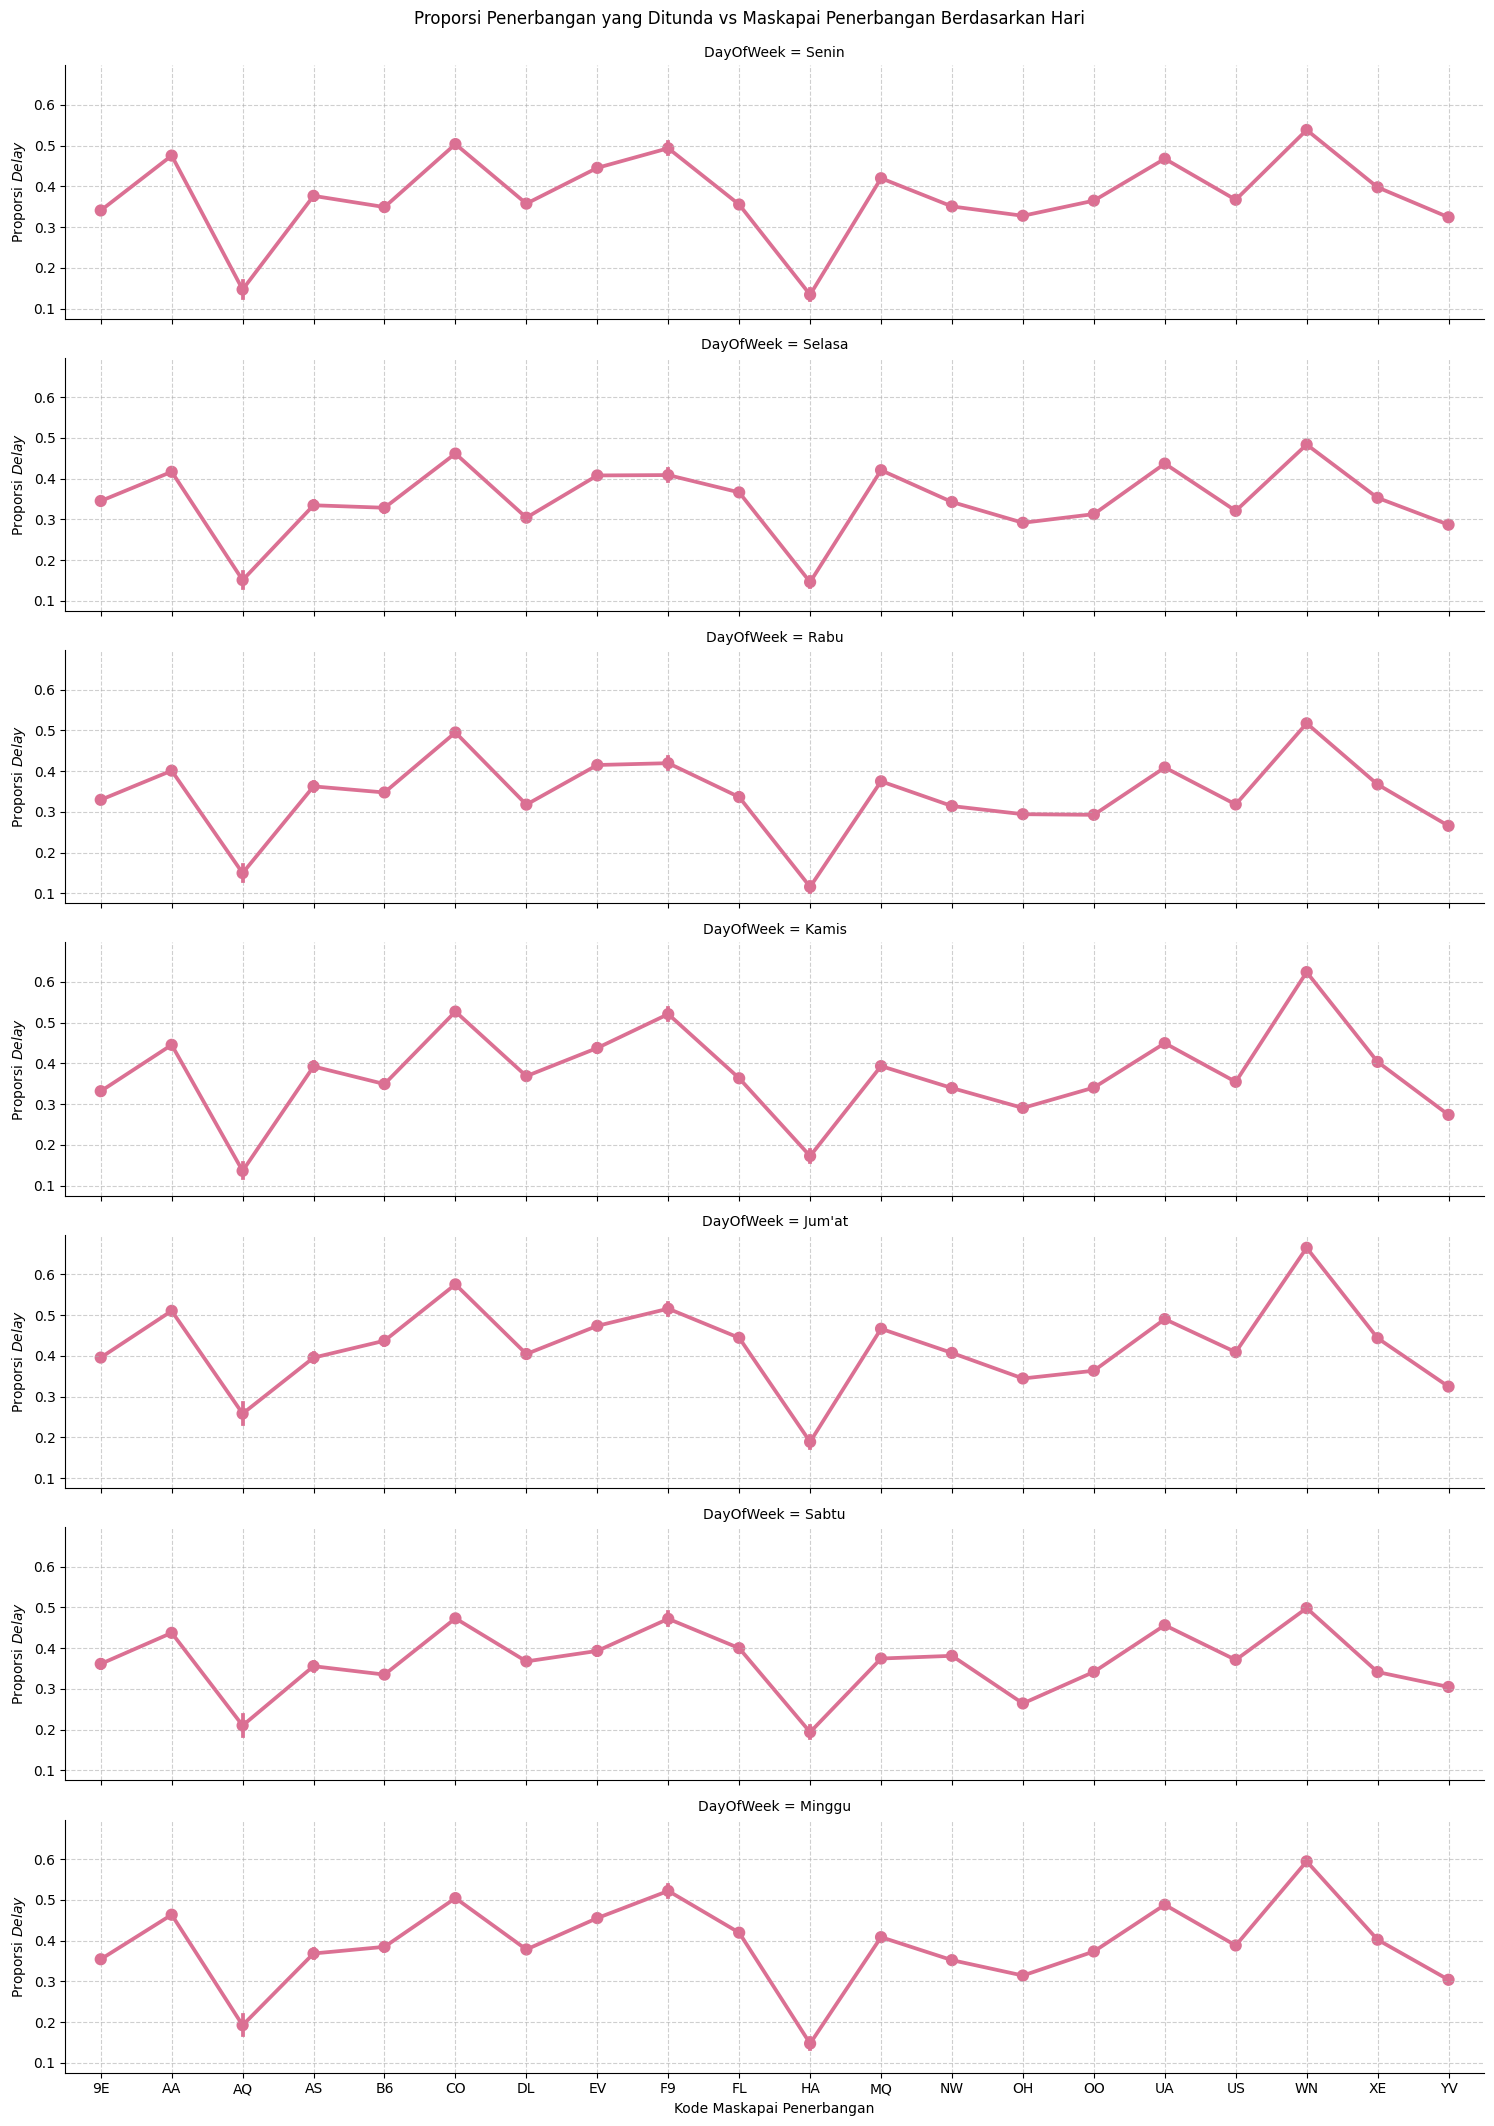

In [ ]:
carrier_order = penerbangan['UniqueCarrier'].sort_values().unique()
rcParams.update({'font.size': 10})

group = sns.FacetGrid(data = penerbangan, col = 'DayOfWeek',
                      col_wrap = 1, aspect = 5)
group.map(sns.pointplot, 'UniqueCarrier', 'Ditunda/Delay',
          order = carrier_order, color = 'palevioletred')
group.set_ylabels('Proporsi $\t{Delay}$')
group.set_xlabels('Kode Maskapai Penerbangan')
group.fig.suptitle('Proporsi Penerbangan yang Ditunda vs Maskapai Penerbangan Berdasarkan Hari', y = 1.01)

for ax in group.axes.flatten():
  ax.grid(True, linestyle = '--', alpha = 0.6);

In [ ]:
menit_10sd100 = penerbangan.loc[(penerbangan['DepDelay'] <= 100) &\
                                (penerbangan['DepDelay'] > 10)]

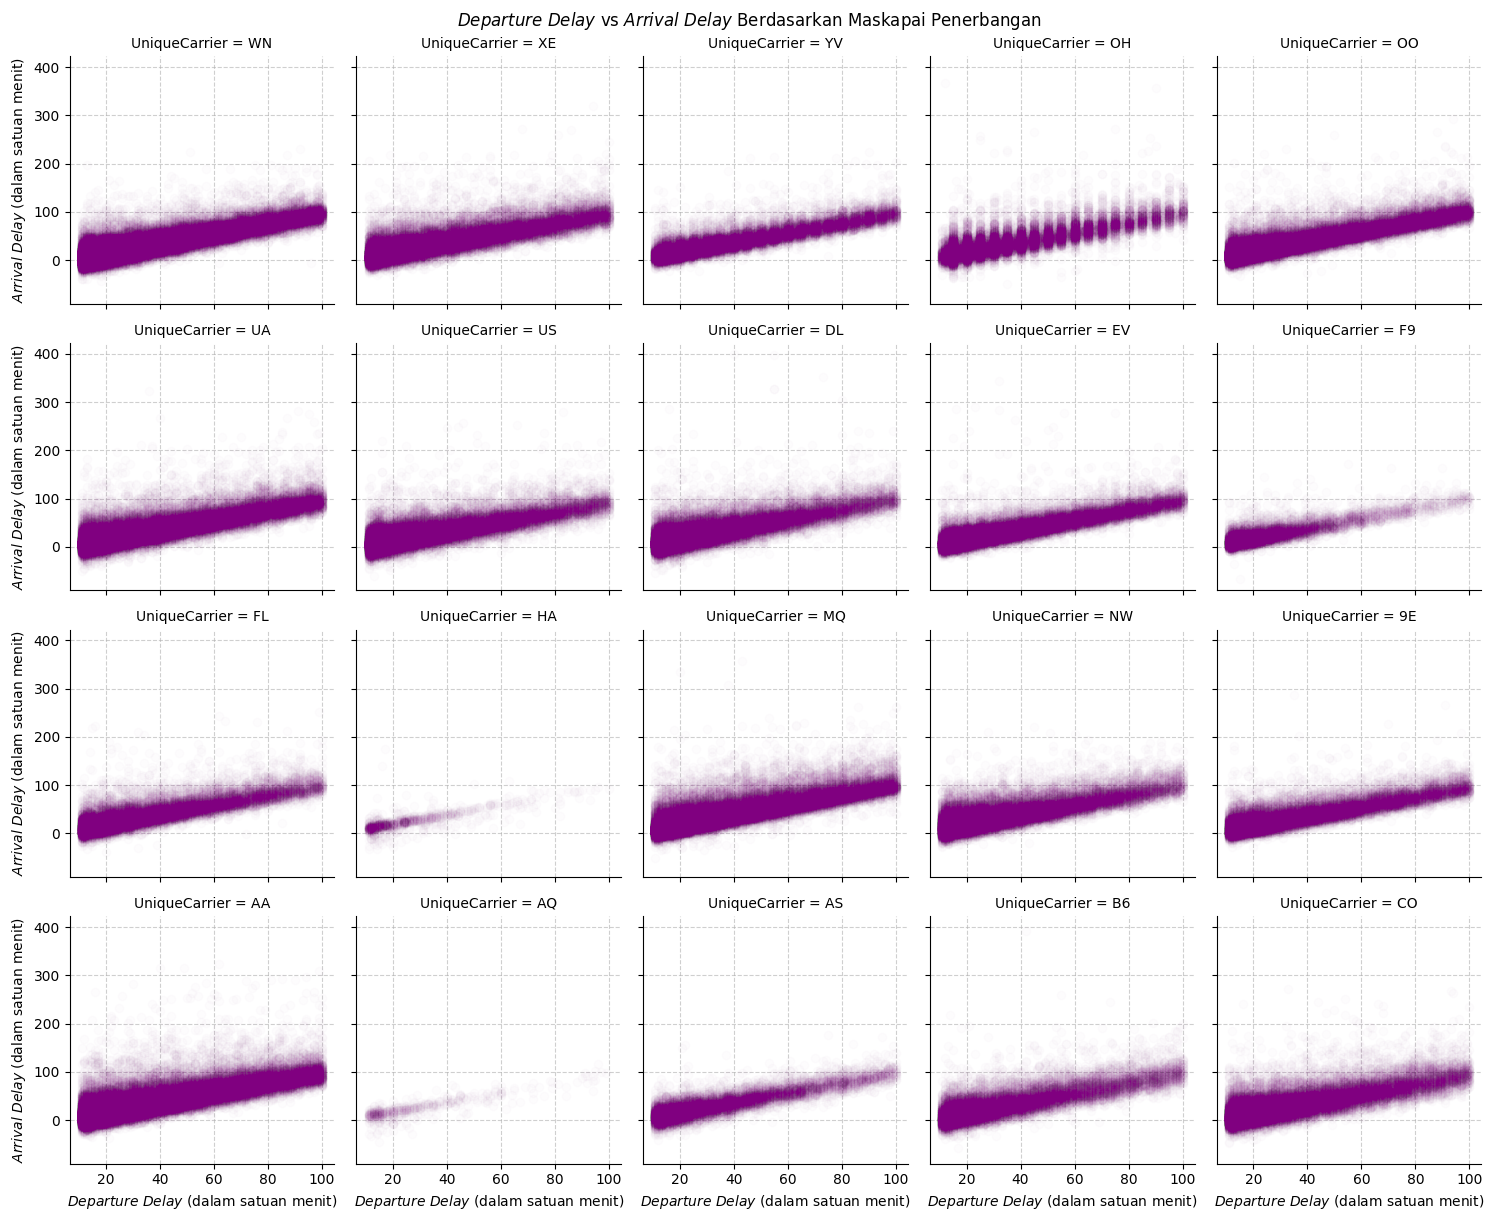

In [ ]:
kumpul = sns.FacetGrid(data = menit_10sd100, col = 'UniqueCarrier', col_wrap = 5)
kumpul.map(plt.scatter, 'DepDelay', 'ArrDelay', alpha = 0.01, zorder = 2,
           color = 'purple')
kumpul.fig.suptitle('$\t{Departure\ Delay}$ vs $\t{Arrival\ Delay}$ Berdasarkan Maskapai Penerbangan', y = 1.01)
kumpul.set_ylabels('$\t{Arrival\ Delay}$ (dalam satuan menit)')
kumpul.set_xlabels('$\t{Departure\ Delay}$ (dalam satuan menit)')
for ax in kumpul.axes.flatten():
  ax.grid(True, linestyle = '--', alpha = 0.6, zorder = 1);

# *Data Learning*

In [ ]:
for col in data.columns :
  print(col)
  print(data[col].unique())

# Tahunnya cuma tahun 2008
# Bulannya cuma bulan 1 - 4

In [ ]:
data_security_bersih = data.dropna(subset = ['SecurityDelay']).reset_index(drop = True)
data_security_bersih.shape

(584583, 29)

In [ ]:
data_security_bersih.loc[data_security_bersih['NASDelay'] != 0].shape
data_security_bersih.loc[data_security_bersih['SecurityDelay'] != 0].shape
data_security_bersih.loc[data_security_bersih['LateAircraftDelay'] != 0].shape

(275249, 29)

Text(0, 0.5, 'LateAircraft Delay')

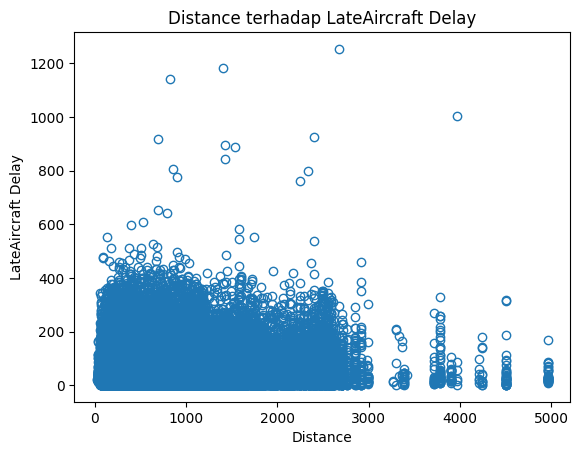

In [ ]:
plt.plot(data_security_bersih['Distance'], data_security_bersih['LateAircraftDelay'], 'o', markerfacecolor = 'none')
#plt.ylim([-1,150])
plt.title("Distance terhadap LateAircraft Delay")
plt.xlabel("Distance")
plt.ylabel("LateAircraft Delay")

Text(0, 0.5, 'NAS Delay')

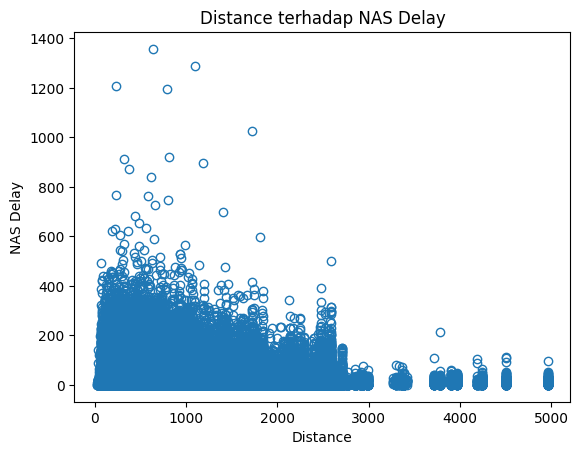

In [ ]:
plt.plot(data_security_bersih['Distance'],data_security_bersih['NASDelay'], 'o', markerfacecolor = 'none')
#plt.ylim([-1,150])
plt.title("Distance terhadap NAS Delay")
plt.xlabel("Distance")
plt.ylabel("NAS Delay")

Text(0, 0.5, 'Security Delay')

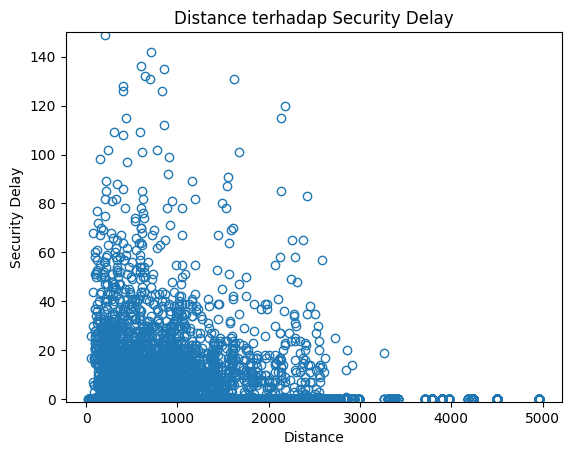

In [ ]:
plt.plot(data_security_bersih['Distance'],data_security_bersih['SecurityDelay'], 'o', markerfacecolor = 'none')
plt.ylim([-1,150])
plt.title("Distance terhadap Security Delay")
plt.xlabel("Distance")
plt.ylabel("Security Delay")

Text(0, 0.5, 'Security Delay')

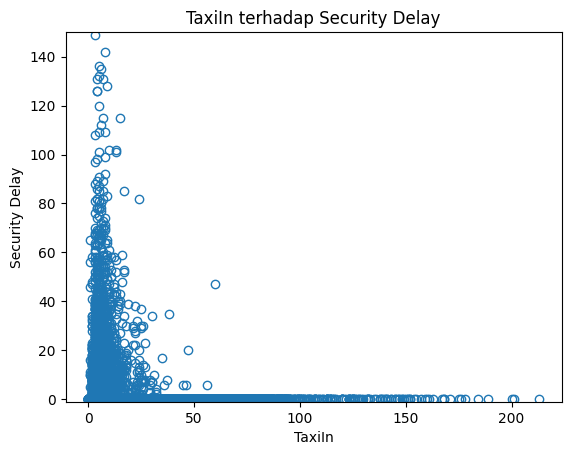

In [ ]:
plt.plot(data_security_bersih['TaxiIn'],data_security_bersih['SecurityDelay'], 'o', markerfacecolor = 'none')
plt.ylim([-1,150])
plt.title("TaxiIn terhadap Security Delay")
plt.xlabel("TaxiIn")
plt.ylabel("Security Delay")

Text(0, 0.5, 'Security Delay')

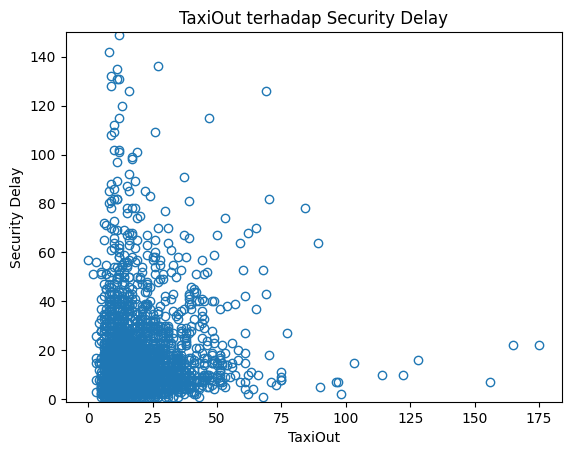

In [ ]:
plt.plot(data_security_bersih['TaxiOut'],data_security_bersih['SecurityDelay'], 'o', markerfacecolor = 'none')
plt.ylim([-1,150])
plt.title("TaxiOut terhadap Security Delay")
plt.xlabel("TaxiOut")
plt.ylabel("Security Delay")

Distance, TaxiIn, TaxiOut berbanding terbalik dengan Security Delay

# *Security Delay*

In [ ]:
# Pilih data yang mau dipakai
data_security = data.filter(['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'TaxiIn', 'TaxiOut', 'SecurityDelay'], axis = 1)
data_security = data_security.dropna(subset = ['SecurityDelay']).reset_index(drop = True)

# Normalisasi data
data_security_normalized, rata_rata_security, standar_deviasi_security = Standarisasi(data_security)
data_security_normalized.head()

Month  DayofMonth  DayOfWeek  Distance    TaxiIn   TaxiOut  \
0 -1.323022   -1.361859   0.027674 -0.645440 -0.564400 -0.788840   
1 -1.323022   -1.361859   0.027674  0.163136 -0.263036 -0.730440   
2 -1.323022   -1.361859   0.027674  0.321298 -0.263036 -0.555241   
3 -1.323022   -1.361859   0.027674  0.321298  0.339690 -0.730440   
4 -1.323022   -1.361859   0.027674  0.321298  3.956052 -0.847239   

   SecurityDelay  
0      -0.046172  
1      -0.046172  
2      -0.046172  
3      -0.046172  
4      -0.046172

In [ ]:
# Pisah Data yang sudah dinormalisasi menjadi prediktor dan target
data_security_prediktor = data_security_normalized.drop('SecurityDelay',axis = 1)
data_security_prediktor = data_security_prediktor.to_numpy()
data_security_target = data_security_normalized['SecurityDelay']
data_security_target = data_security_target.to_numpy()

# Pisah Data menjadi data train dan data test
data_security_prediktor_train, data_security_prediktor_test, data_security_target_train, data_security_target_test = \
  train_test_split(data_security_prediktor, data_security_target, test_size = 0.15, random_state = 10)

data_security_prediktor_test.shape

(87688, 6)

In [ ]:
# Mencari titik pusat dengan K-Means

banyak_basis = 100
cluster = KMeans(n_clusters = banyak_basis, random_state = 10, n_init = 10).fit(data_security_prediktor_train)
Titik_pusat_basis = cluster.cluster_centers_
Titik_pusat_basis.shape

(100, 6)

## Sequential

In [ ]:
np.random.seed(10)

start = datetime.datetime.now()

parameter_awal = [0,1,1,1,1,1,1]
rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, parameter_akhir = Gaussian_Process_fitting_ARD(data_security_prediktor_train,
                                                                                                                data_security_target_train,
                                                                                                                parameter_awal,
                                                                                                                learning_rate = 1*1e-5,
                                                                                                                basis = Titik_pusat_basis,
                                                                                                                batch_size = 25)
print("Waktu fitting : ")
print(datetime.datetime.now() - start)

Fitting ARD: 100%|██████████| 19876/19876 [36:52<00:00,  8.98it/s]


Galat terakhir sebesar  9.951104092701391e-05
Waktu fitting : 
0:36:52.628426


In [ ]:
#print("Parameter ESS + ARD")
#print("sigma kuadrat ESS :",np.exp(parameter_akhir[0]))
#print("Lengthscale :",parameter_akhir[1])
#print("periodicity :",parameter_akhir[2])
print("sigma kuadrat ARD :",np.exp(parameter_akhir[0]))
print("fitur 1 :",parameter_akhir[1])
print("fitur 2 :",parameter_akhir[2])
print("fitur 3 :",parameter_akhir[3])
print("fitur 4 :",parameter_akhir[4])
print("fitur 5 :",parameter_akhir[5])
print("fitur 6 :",parameter_akhir[6])

sigma kuadrat ARD : 0.5393977754458846
fitur 1 : 1.2147221888988893
fitur 2 : 1.1256664984103566
fitur 3 : 1.1489694815655438
fitur 4 : 1.15970890306412
fitur 5 : 1.006053297294043
fitur 6 : 1.0450886955458942


In [ ]:
rata_rata_dalam, variansi_dalam = \
Predict_ARD(data_security_prediktor_train,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 500)

Predict ARD: 100%|██████████| 994/994 [02:46<00:00,  5.99it/s]


In [ ]:
MSE_dalam = 0
for i in range(rata_rata_dalam.shape[0]) :
  MSE_dalam = MSE_dalam + (rata_rata_dalam[i] - data_security_target_train[0])**2

print("Mean Square Error latih = ", MSE_dalam)

Mean Square Error latih =  [16587.71623852]


Text(0.5, 0, 'Data-ke')

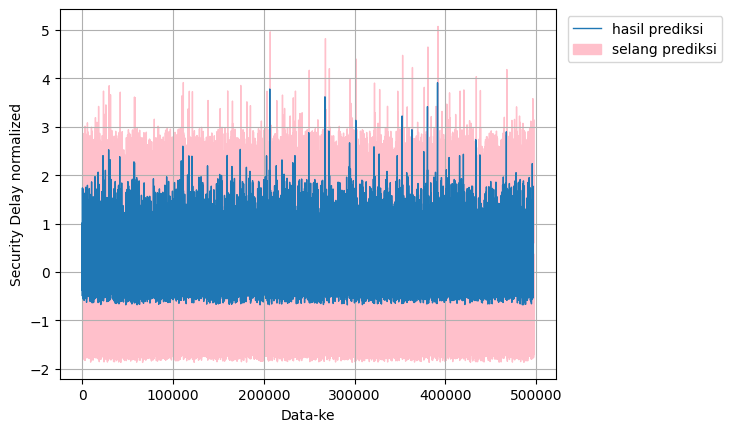

In [ ]:
# Plotting

#plt.plot(data_security_target_train, markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 1)
plt.plot(rata_rata_dalam, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1, alpha = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(np.arange(data_security_target_train.shape[0]),
                 rata_rata_dalam[:,0] - 1.96*np.power(variansi_dalam[:,0],0.5),
                 rata_rata_dalam[:,0] + 1.96*np.power(variansi_dalam[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-1,20])
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.ylabel('Security Delay normalized')
plt.xlabel('Data-ke')

In [ ]:
rata_rata_luar, variansi_luar = \
Predict_ARD(data_security_prediktor_test,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 500)

Predict ARD: 100%|██████████| 176/176 [00:30<00:00,  5.82it/s]


In [ ]:
MSE_luar = 0
for i in range(rata_rata_luar.shape[0]) :
  MSE_luar = MSE_luar + (rata_rata_luar[i] - data_security_target_test[0])**2

print("Mean Square Error prediksi = ", MSE_luar)

Mean Square Error prediksi =  [2955.37660153]


Text(0.5, 0, 'Data-ke')

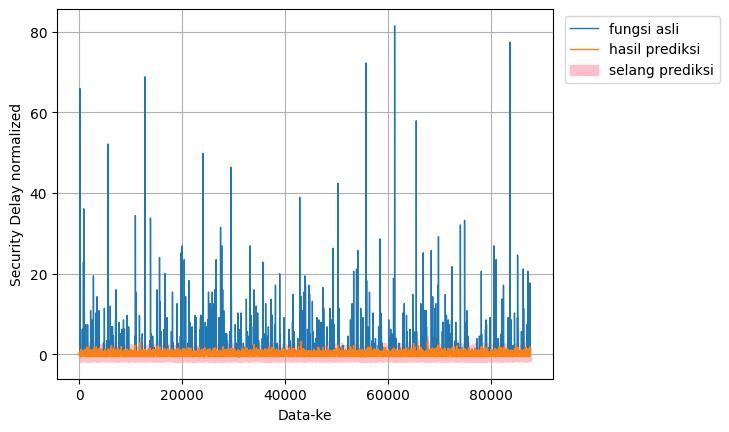

In [ ]:
# Plotting

plt.plot(data_security_target_test, markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 1)
plt.plot(rata_rata_luar, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1, alpha = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(np.arange(data_security_target_test.shape[0]),
                 rata_rata_luar[:,0] - 1.96*np.power(variansi_luar[:,0],0.5),
                 rata_rata_luar[:,0] + 1.96*np.power(variansi_luar[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-1,20])
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.ylabel('Security Delay normalized')
plt.xlabel('Data-ke')

In [ ]:
rata_rata_unnormalized = rata_rata_dalam*standar_deviasi_security[6] + rata_rata_security[6]
variansi_unnormalized = variansi_dalam*standar_deviasi_security[6] + standar_deviasi_security[6]

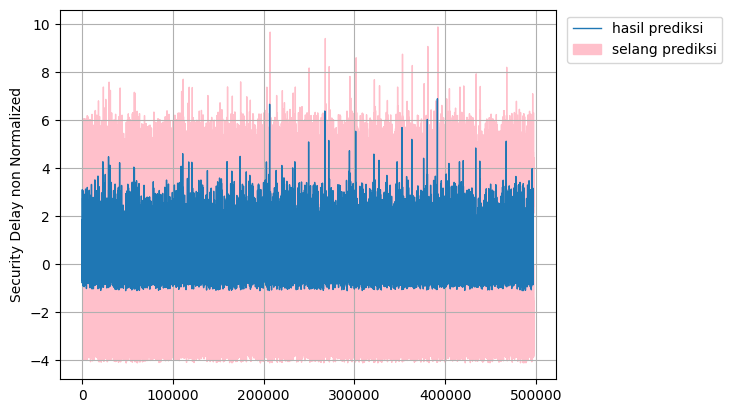

In [ ]:
#plt.plot(data_security['SecurityDelay'], 'o', markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 0.1)
plt.plot(rata_rata_unnormalized, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1)
plt.fill_between(np.arange(data_security_target_train.shape[0]),
                 rata_rata_unnormalized[:,0] - 1.96*np.power(variansi_unnormalized[:,0],0.5),
                 rata_rata_unnormalized[:,0] + 1.96*np.power(variansi_unnormalized[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-5,30])
plt.ylabel('Security Delay non Normalized')
plt.legend(bbox_to_anchor=(1.35, 1.0))

## Randomized 1

Fitting ARD: 100%|██████████| 20000/20000 [48:19<00:00,  6.90it/s]



Galat terakhir sebesar  0.00029874557661195637
Waktu fitting : 
0:48:19.167313


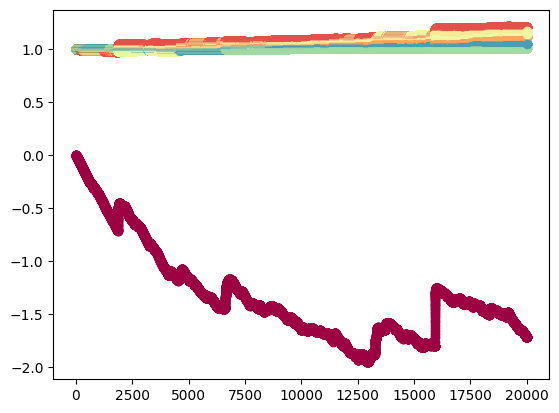

In [ ]:
np.random.seed(10)

start = datetime.datetime.now()

parameter_awal = [0,1,1,1,1,1,1]
rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, parameter_akhir = \
Gaussian_Process_fitting_ARD_Randomized(data_security_prediktor_train,
                                        data_security_target_train,
                                        parameter_awal,
                                        learning_rate = 1*1e-5,
                                        basis = Titik_pusat_basis,
                                        batch_size = 25,
                                        iterasi = 20000)

print("Waktu fitting : ")
print(datetime.datetime.now() - start)

In [ ]:
#print("Parameter ESS + ARD")
#print("sigma kuadrat ESS :",np.exp(parameter_akhir[0]))
#print("Lengthscale :",parameter_akhir[1])
#print("periodicity :",parameter_akhir[2])
print("sigma kuadrat ARD :",np.exp(parameter_akhir[0]))
print("fitur 1 :",parameter_akhir[1])
print("fitur 2 :",parameter_akhir[2])
print("fitur 3 :",parameter_akhir[3])
print("fitur 4 :",parameter_akhir[4])
print("fitur 5 :",parameter_akhir[5])
print("fitur 6 :",parameter_akhir[6])

sigma kuadrat ARD : 0.1792163757133272
fitur 1 : 1.2083689422512927
fitur 2 : 1.1092291187574703
fitur 3 : 1.1691877551799033
fitur 4 : 1.1429918568793738
fitur 5 : 1.0079103182791904
fitur 6 : 1.0491245331082983


In [ ]:
rata_rata_dalam, variansi_dalam = \
Predict_ARD(data_security_prediktor_train,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 100)

Predict ARD: 100%|██████████| 4969/4969 [02:14<00:00, 36.90it/s]


In [ ]:
MSE_dalam = 0
for i in range(rata_rata_dalam.shape[0]) :
  MSE_dalam = MSE_dalam + (rata_rata_dalam[i] - data_security_target_train[0])**2

print("Mean Square Error prediksi = ", MSE_dalam)

Mean Square Error prediksi =  [10878.74653861]


Text(0.5, 0, 'Data-ke')

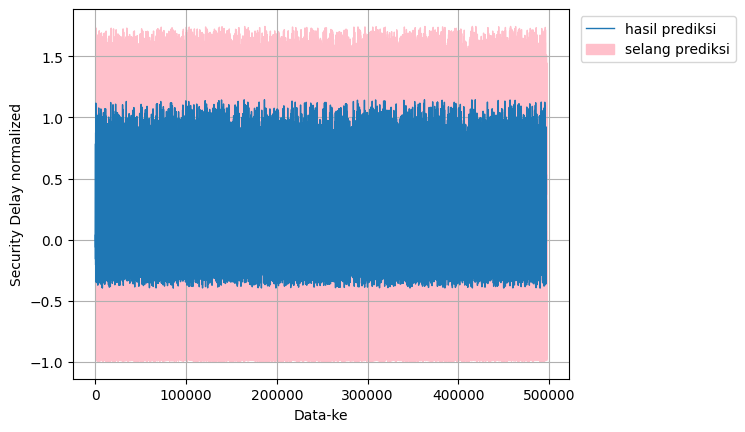

In [ ]:
# Plotting

#plt.plot(data_security_target_train, markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 1)
plt.plot(rata_rata_dalam, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1, alpha = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(np.arange(data_security_target_train.shape[0]),
                 rata_rata_dalam[:,0] - 1.96*np.power(variansi_dalam[:,0],0.5),
                 rata_rata_dalam[:,0] + 1.96*np.power(variansi_dalam[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-1,20])
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.ylabel('Security Delay normalized')
plt.xlabel('Data-ke')

In [ ]:
rata_rata_luar, variansi_luar = \
Predict_ARD(data_security_prediktor_test,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 500)

Predict ARD: 100%|██████████| 176/176 [00:28<00:00,  6.10it/s]


In [ ]:
MSE_luar = 0
for i in range(rata_rata_luar.shape[0]) :
  MSE_luar = MSE_luar + (rata_rata_luar[i] - data_security_target_test[0])**2

print("Mean Square Error prediksi = ", MSE_luar)

Mean Square Error prediksi =  [1907.04961635]


Text(0.5, 0, 'Data-ke')

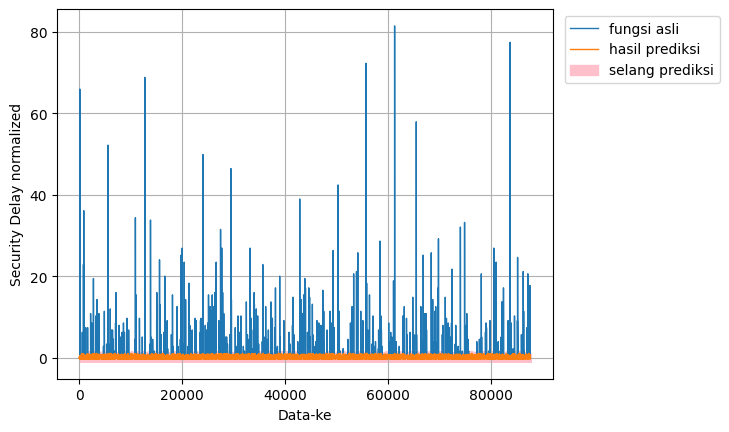

In [ ]:
# Plotting

plt.plot(data_security_target_test, markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 1)
plt.plot(rata_rata_luar, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1, alpha = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(np.arange(data_security_target_test.shape[0]),
                 rata_rata_luar[:,0] - 1.96*np.power(variansi_luar[:,0],0.5),
                 rata_rata_luar[:,0] + 1.96*np.power(variansi_luar[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-1,20])
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.ylabel('Security Delay normalized')
plt.xlabel('Data-ke')

In [ ]:
rata_rata_unnormalized = rata_rata_dalam*standar_deviasi_security[6] + rata_rata_security[6]
variansi_unnormalized = variansi_dalam*standar_deviasi_security[6] + standar_deviasi_security[6]

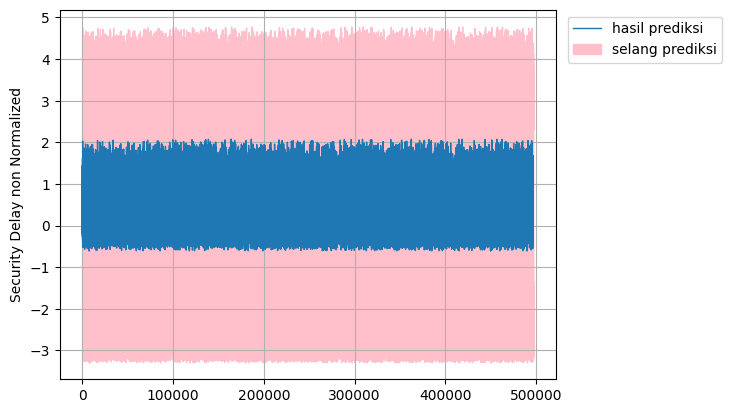

In [ ]:
#plt.plot(data_security['SecurityDelay'], 'o', markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 0.1)
plt.plot(rata_rata_unnormalized, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1)
plt.fill_between(np.arange(data_security_target_train.shape[0]),
                 rata_rata_unnormalized[:,0] - 1.96*np.power(variansi_unnormalized[:,0],0.5),
                 rata_rata_unnormalized[:,0] + 1.96*np.power(variansi_unnormalized[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-5,30])
plt.ylabel('Security Delay non Normalized')
plt.legend(bbox_to_anchor=(1.35, 1.0))

## Randomized 2

Fitting ARD: 100%|██████████| 20000/20000 [52:14<00:00,  6.38it/s]



Galat terakhir sebesar  0.0003827550243918557
Waktu fitting : 
0:52:14.209326


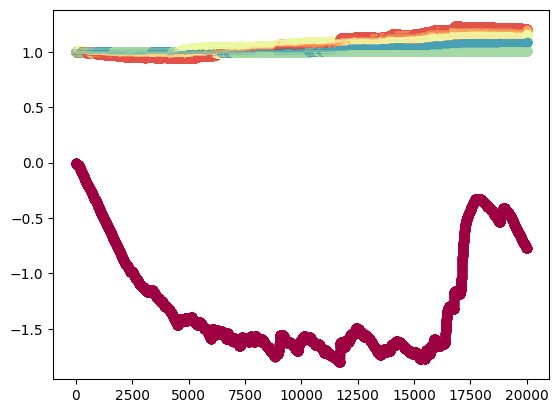

In [ ]:
np.random.seed(11)

start = datetime.datetime.now()

parameter_awal = [0,1,1,1,1,1,1]
rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, parameter_akhir = \
Gaussian_Process_fitting_ARD_Randomized(data_security_prediktor_train,
                                        data_security_target_train,
                                        parameter_awal,
                                        learning_rate = 1*1e-5,
                                        basis = Titik_pusat_basis,
                                        batch_size = 25,
                                        iterasi = 20000)

print("Waktu fitting : ")
print(datetime.datetime.now() - start)

In [ ]:
#print("Parameter ESS + ARD")
#print("sigma kuadrat ESS :",np.exp(parameter_akhir[0]))
#print("Lengthscale :",parameter_akhir[1])
#print("periodicity :",parameter_akhir[2])
print("sigma kuadrat ARD :",np.exp(parameter_akhir[0]))
print("fitur 1 :",parameter_akhir[1])
print("fitur 2 :",parameter_akhir[2])
print("fitur 3 :",parameter_akhir[3])
print("fitur 4 :",parameter_akhir[4])
print("fitur 5 :",parameter_akhir[5])
print("fitur 6 :",parameter_akhir[6])

sigma kuadrat ARD : 0.46173345416040695
fitur 1 : 1.207765043581781
fitur 2 : 1.200064361636643
fitur 3 : 1.1501754551914136
fitur 4 : 1.1581290300420237
fitur 5 : 1.0052225628717926
fitur 6 : 1.0847402368382746


In [ ]:
rata_rata_dalam, variansi_dalam = \
Predict_ARD(data_security_prediktor_train,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 100)

Predict ARD: 100%|██████████| 4969/4969 [02:20<00:00, 35.47it/s]


In [ ]:
MSE_dalam = 0
for i in range(rata_rata_dalam.shape[0]) :
  MSE_dalam = MSE_dalam + (rata_rata_dalam[i] - data_security_target_train[0])**2

print("Mean Square Error latih = ", MSE_dalam)

Mean Square Error latih =  [13845.70587663]


Text(0.5, 0, 'Data-ke')

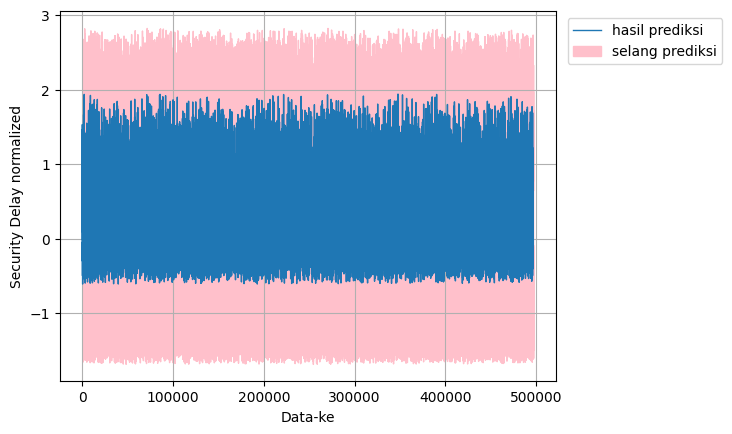

In [ ]:
# Plotting

#plt.plot(data_security_target_train, markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 1)
plt.plot(rata_rata_dalam, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1, alpha = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(np.arange(data_security_target_train.shape[0]),
                 rata_rata_dalam[:,0] - 1.96*np.power(variansi_dalam[:,0],0.5),
                 rata_rata_dalam[:,0] + 1.96*np.power(variansi_dalam[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-1,20])
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.ylabel('Security Delay normalized')
plt.xlabel('Data-ke')

In [ ]:
rata_rata_luar, variansi_luar = \
Predict_ARD(data_security_prediktor_test,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 500)

Predict ARD: 100%|██████████| 176/176 [00:29<00:00,  6.04it/s]


In [ ]:
MSE_luar = 0
for i in range(rata_rata_luar.shape[0]) :
  MSE_luar = MSE_luar + (rata_rata_luar[i] - data_security_target_test[0])**2

print("Mean Square Error prediksi = ", MSE_luar)

Mean Square Error prediksi =  [2479.16138623]


Text(0.5, 0, 'Data-ke')

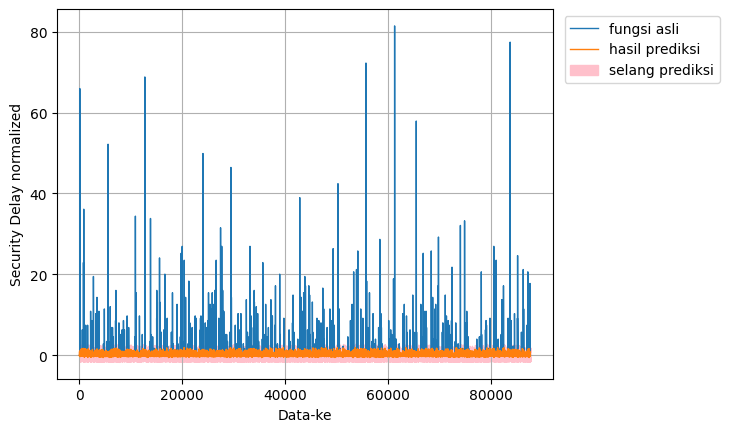

In [ ]:
# Plotting

plt.plot(data_security_target_test, markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 1)
plt.plot(rata_rata_luar, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1, alpha = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(np.arange(data_security_target_test.shape[0]),
                 rata_rata_luar[:,0] - 1.96*np.power(variansi_luar[:,0],0.5),
                 rata_rata_luar[:,0] + 1.96*np.power(variansi_luar[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-1,20])
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.ylabel('Security Delay normalized')
plt.xlabel('Data-ke')

In [ ]:
rata_rata_unnormalized = rata_rata_dalam*standar_deviasi_security[6] + rata_rata_security[6]
variansi_unnormalized = variansi_dalam*standar_deviasi_security[6] + standar_deviasi_security[6]

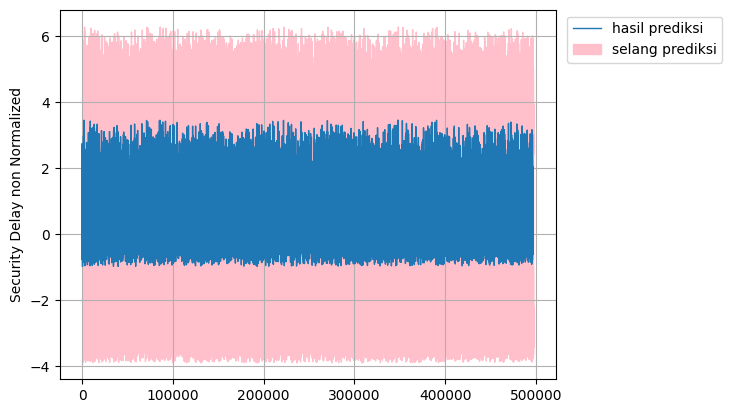

In [ ]:
#plt.plot(data_security['SecurityDelay'], 'o', markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 0.1)
plt.plot(rata_rata_unnormalized, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1)
plt.fill_between(np.arange(data_security_target_train.shape[0]),
                 rata_rata_unnormalized[:,0] - 1.96*np.power(variansi_unnormalized[:,0],0.5),
                 rata_rata_unnormalized[:,0] + 1.96*np.power(variansi_unnormalized[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-5,30])
plt.ylabel('Security Delay non Normalized')
plt.legend(bbox_to_anchor=(1.35, 1.0))

## Randomized 3

Fitting ARD: 100%|██████████| 20000/20000 [50:02<00:00,  6.66it/s]



Galat terakhir sebesar  0.00024667562264638645
Waktu fitting : 
0:50:02.093897


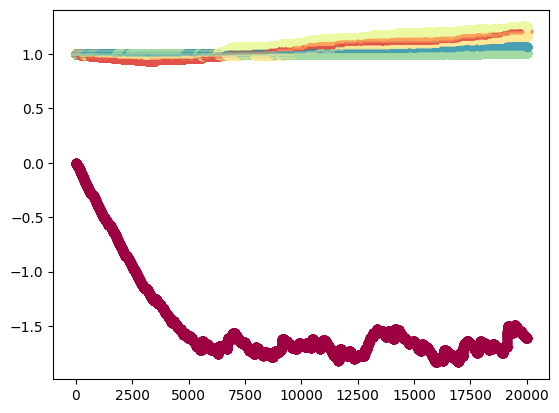

In [ ]:
np.random.seed(12)

start = datetime.datetime.now()

parameter_awal = [0,1,1,1,1,1,1]
rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, parameter_akhir = \
Gaussian_Process_fitting_ARD_Randomized(data_security_prediktor_train,
                                        data_security_target_train,
                                        parameter_awal,
                                        learning_rate = 1*1e-5,
                                        basis = Titik_pusat_basis,
                                        batch_size = 25,
                                        iterasi = 20000)

print("Waktu fitting : ")
print(datetime.datetime.now() - start)

In [ ]:
#print("Parameter ESS + ARD")
#print("sigma kuadrat ESS :",np.exp(parameter_akhir[0]))
#print("Lengthscale :",parameter_akhir[1])
#print("periodicity :",parameter_akhir[2])
print("sigma kuadrat ARD :",np.exp(parameter_akhir[0]))
print("fitur 1 :",parameter_akhir[1])
print("fitur 2 :",parameter_akhir[2])
print("fitur 3 :",parameter_akhir[3])
print("fitur 4 :",parameter_akhir[4])
print("fitur 5 :",parameter_akhir[5])
print("fitur 6 :",parameter_akhir[6])

sigma kuadrat ARD : 0.19938952850719843
fitur 1 : 1.213462526991323
fitur 2 : 1.2035545001154582
fitur 3 : 1.1678129805116437
fitur 4 : 1.2522177343507397
fitur 5 : 1.0055057846800264
fitur 6 : 1.0658018357615062


In [ ]:
rata_rata_dalam, variansi_dalam = \
Predict_ARD(data_security_prediktor_train,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 100)

Predict ARD: 100%|██████████| 4969/4969 [02:14<00:00, 37.04it/s]


In [ ]:
MSE_dalam = 0
for i in range(rata_rata_dalam.shape[0]) :
  MSE_dalam = MSE_dalam + (rata_rata_dalam[i] - data_security_target_train[0])**2

print("Mean Square Error latih = ", MSE_dalam)

Mean Square Error latih =  [55351.16082263]


Text(0.5, 0, 'Data-ke')

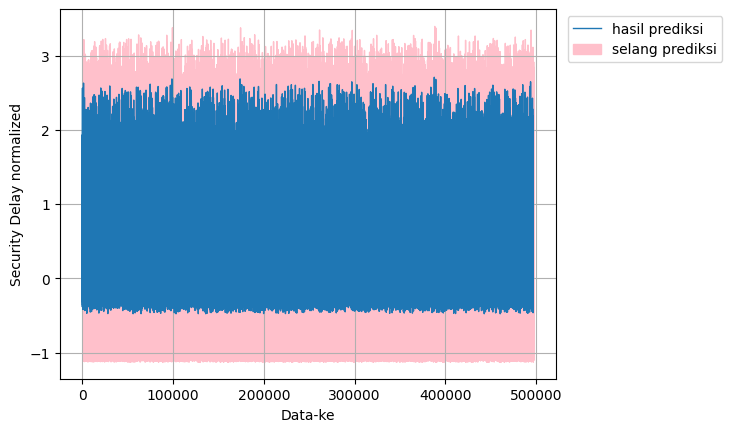

In [ ]:
# Plotting

#plt.plot(data_security_target_train, markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 1)
plt.plot(rata_rata_dalam, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1, alpha = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(np.arange(data_security_target_train.shape[0]),
                 rata_rata_dalam[:,0] - 1.96*np.power(variansi_dalam[:,0],0.5),
                 rata_rata_dalam[:,0] + 1.96*np.power(variansi_dalam[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-1,20])
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.ylabel('Security Delay normalized')
plt.xlabel('Data-ke')

In [ ]:
rata_rata_luar, variansi_luar = \
Predict_ARD(data_security_prediktor_test,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 500)

Predict ARD: 100%|██████████| 176/176 [00:28<00:00,  6.24it/s]


In [ ]:
MSE_luar = 0
for i in range(rata_rata_luar.shape[0]) :
  MSE_luar = MSE_luar + (rata_rata_luar[i] - data_security_target_test[0])**2

print("Mean Square Error prediksi = ", MSE_luar)

Mean Square Error prediksi =  [9729.49493857]


Text(0.5, 0, 'Data-ke')

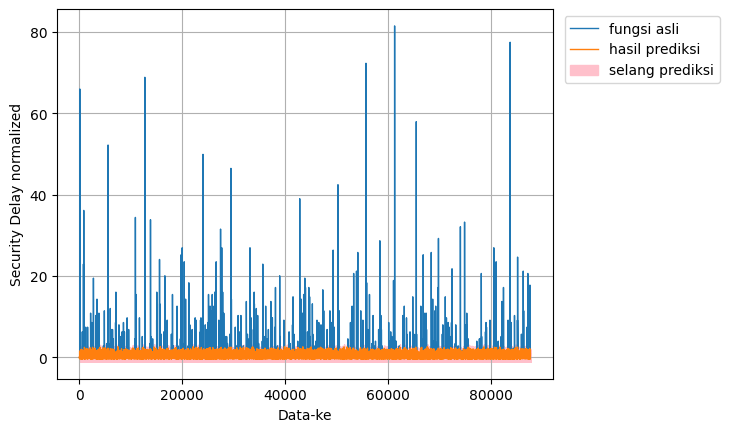

In [ ]:
# Plotting

plt.plot(data_security_target_test, markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 1)
plt.plot(rata_rata_luar, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1, alpha = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(np.arange(data_security_target_test.shape[0]),
                 rata_rata_luar[:,0] - 1.96*np.power(variansi_luar[:,0],0.5),
                 rata_rata_luar[:,0] + 1.96*np.power(variansi_luar[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-1,20])
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.ylabel('Security Delay normalized')
plt.xlabel('Data-ke')

In [ ]:
rata_rata_unnormalized = rata_rata_dalam*standar_deviasi_security[6] + rata_rata_security[6]
variansi_unnormalized = variansi_dalam*standar_deviasi_security[6] + standar_deviasi_security[6]

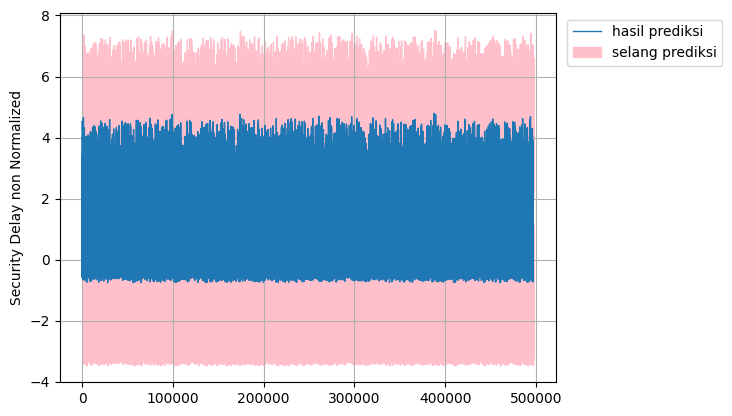

In [ ]:
#plt.plot(data_security['SecurityDelay'], 'o', markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 0.1)
plt.plot(rata_rata_unnormalized, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1)
plt.fill_between(np.arange(data_security_target_train.shape[0]),
                 rata_rata_unnormalized[:,0] - 1.96*np.power(variansi_unnormalized[:,0],0.5),
                 rata_rata_unnormalized[:,0] + 1.96*np.power(variansi_unnormalized[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-5,30])
plt.ylabel('Security Delay non Normalized')
plt.legend(bbox_to_anchor=(1.35, 1.0))

## Randomized 4

Fitting ARD: 100%|██████████| 20000/20000 [49:14<00:00,  6.77it/s]



Galat terakhir sebesar  0.00046790704871311654
Waktu fitting : 
0:49:14.049951


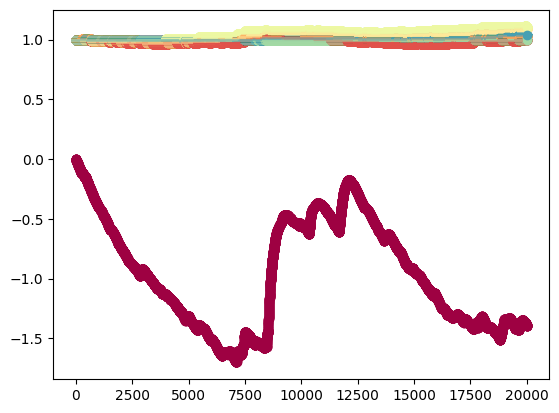

In [ ]:
np.random.seed(13)

start = datetime.datetime.now()

parameter_awal = [0,1,1,1,1,1,1]
rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, parameter_akhir = \
Gaussian_Process_fitting_ARD_Randomized(data_security_prediktor_train,
                                        data_security_target_train,
                                        parameter_awal,
                                        learning_rate = 1*1e-5,
                                        basis = Titik_pusat_basis,
                                        batch_size = 25,
                                        iterasi = 20000)

print("Waktu fitting : ")
print(datetime.datetime.now() - start)

In [ ]:
#print("Parameter ESS + ARD")
#print("sigma kuadrat ESS :",np.exp(parameter_akhir[0]))
#print("Lengthscale :",parameter_akhir[1])
#print("periodicity :",parameter_akhir[2])
print("sigma kuadrat ARD :",np.exp(parameter_akhir[0]))
print("fitur 1 :",parameter_akhir[1])
print("fitur 2 :",parameter_akhir[2])
print("fitur 3 :",parameter_akhir[3])
print("fitur 4 :",parameter_akhir[4])
print("fitur 5 :",parameter_akhir[5])
print("fitur 6 :",parameter_akhir[6])

sigma kuadrat ARD : 0.24755855203938884
fitur 1 : 0.995797459496894
fitur 2 : 1.028287254877477
fitur 3 : 1.0900057974254242
fitur 4 : 1.1092581258129692
fitur 5 : 0.9968921683815318
fitur 6 : 1.041159097014614


In [ ]:
rata_rata_dalam, variansi_dalam = \
Predict_ARD(data_security_prediktor_train,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 100)

Predict ARD: 100%|██████████| 4969/4969 [02:13<00:00, 37.18it/s]


In [ ]:
MSE_dalam = 0
for i in range(rata_rata_dalam.shape[0]) :
  MSE_dalam = MSE_dalam + (rata_rata_dalam[i] - data_security_target_train[0])**2

print("Mean Square Error latih = ", MSE_dalam)

Mean Square Error latih =  [615.10775399]


Text(0.5, 0, 'Data-ke')

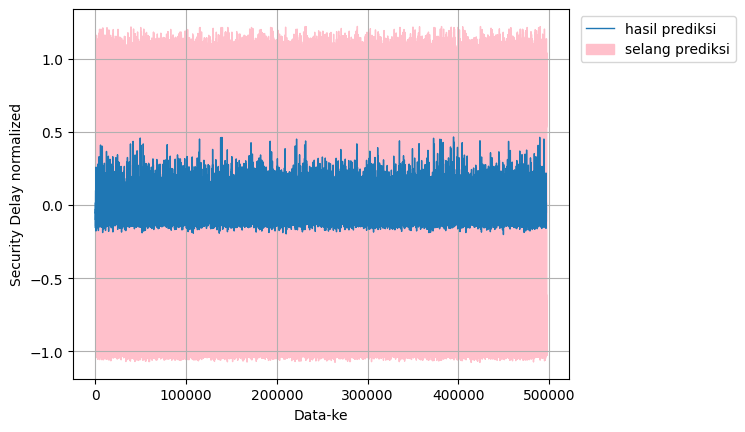

In [ ]:
# Plotting

#plt.plot(data_security_target_train, markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 1)
plt.plot(rata_rata_dalam, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1, alpha = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(np.arange(data_security_target_train.shape[0]),
                 rata_rata_dalam[:,0] - 1.96*np.power(variansi_dalam[:,0],0.5),
                 rata_rata_dalam[:,0] + 1.96*np.power(variansi_dalam[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-1,20])
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.ylabel('Security Delay normalized')
plt.xlabel('Data-ke')

In [ ]:
rata_rata_luar, variansi_luar = \
Predict_ARD(data_security_prediktor_test,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 500)

Predict ARD: 100%|██████████| 176/176 [00:28<00:00,  6.11it/s]


In [ ]:
MSE_luar = 0
for i in range(rata_rata_luar.shape[0]) :
  MSE_luar = MSE_luar + (rata_rata_luar[i] - data_security_target_test[0])**2

print("Mean Square Error prediksi = ", MSE_luar)

Mean Square Error prediksi =  [109.22192802]


Text(0.5, 0, 'Data-ke')

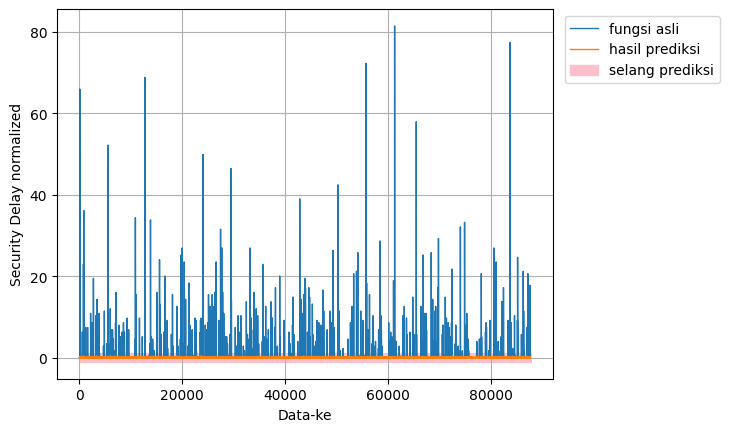

In [ ]:
# Plotting

plt.plot(data_security_target_test, markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 1)
plt.plot(rata_rata_luar, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1, alpha = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(np.arange(data_security_target_test.shape[0]),
                 rata_rata_luar[:,0] - 1.96*np.power(variansi_luar[:,0],0.5),
                 rata_rata_luar[:,0] + 1.96*np.power(variansi_luar[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-1,20])
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.ylabel('Security Delay normalized')
plt.xlabel('Data-ke')

In [ ]:
rata_rata_unnormalized = rata_rata_dalam*standar_deviasi_security[6] + rata_rata_security[6]
variansi_unnormalized = variansi_dalam*standar_deviasi_security[6] + standar_deviasi_security[6]

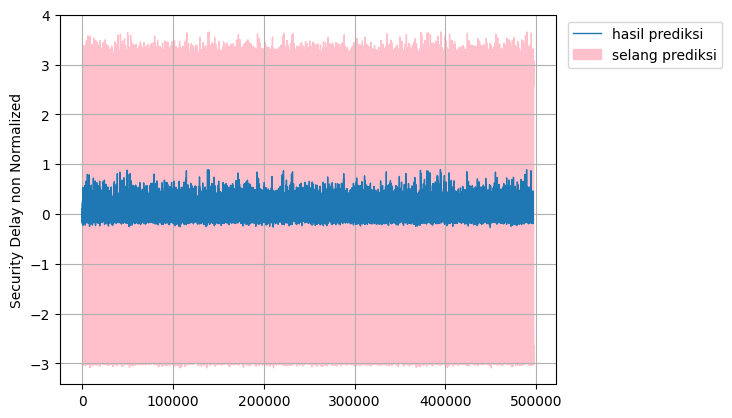

In [ ]:
#plt.plot(data_security['SecurityDelay'], 'o', markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 0.1)
plt.plot(rata_rata_unnormalized, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1)
plt.fill_between(np.arange(data_security_target_train.shape[0]),
                 rata_rata_unnormalized[:,0] - 1.96*np.power(variansi_unnormalized[:,0],0.5),
                 rata_rata_unnormalized[:,0] + 1.96*np.power(variansi_unnormalized[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-5,30])
plt.ylabel('Security Delay non Normalized')
plt.legend(bbox_to_anchor=(1.35, 1.0))

## Randomized 5

Fitting ARD: 100%|██████████| 20000/20000 [49:18<00:00,  6.76it/s]



Galat terakhir sebesar  0.00028484020813416785
Waktu fitting : 
0:49:18.265431


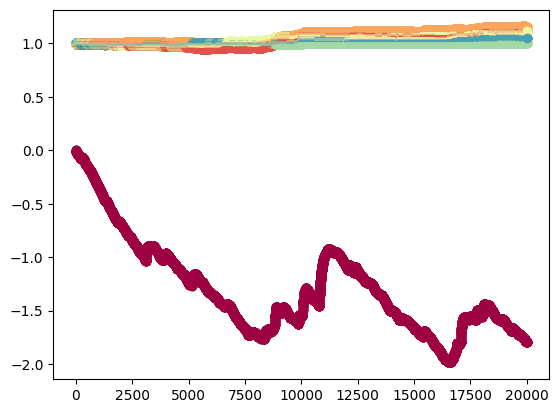

In [ ]:
np.random.seed(14)

start = datetime.datetime.now()

parameter_awal = [0,1,1,1,1,1,1]
rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, parameter_akhir = \
Gaussian_Process_fitting_ARD_Randomized(data_security_prediktor_train,
                                        data_security_target_train,
                                        parameter_awal,
                                        learning_rate = 1*1e-5,
                                        basis = Titik_pusat_basis,
                                        batch_size = 25,
                                        iterasi = 20000)

print("Waktu fitting : ")
print(datetime.datetime.now() - start)

In [ ]:
#print("Parameter ESS + ARD")
#print("sigma kuadrat ESS :",np.exp(parameter_akhir[0]))
#print("Lengthscale :",parameter_akhir[1])
#print("periodicity :",parameter_akhir[2])
print("sigma kuadrat ARD :",np.exp(parameter_akhir[0]))
print("fitur 1 :",parameter_akhir[1])
print("fitur 2 :",parameter_akhir[2])
print("fitur 3 :",parameter_akhir[3])
print("fitur 4 :",parameter_akhir[4])
print("fitur 5 :",parameter_akhir[5])
print("fitur 6 :",parameter_akhir[6])

sigma kuadrat ARD : 0.16621826097698514
fitur 1 : 1.1195724378276604
fitur 2 : 1.1586329682968566
fitur 3 : 1.107859924120877
fitur 4 : 1.1185356366537045
fitur 5 : 1.0020021627571158
fitur 6 : 1.0553700070676173


In [ ]:
rata_rata_dalam, variansi_dalam = \
Predict_ARD(data_security_prediktor_train,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 100)

Predict ARD: 100%|██████████| 4969/4969 [02:13<00:00, 37.22it/s]


In [ ]:
MSE_dalam = 0
for i in range(rata_rata_dalam.shape[0]) :
  MSE_dalam = MSE_dalam + (rata_rata_dalam[i] - data_security_target_train[0])**2

print("Mean Square Error latih = ", MSE_dalam)

Mean Square Error latih =  [4515.67420774]


Text(0.5, 0, 'Data-ke')

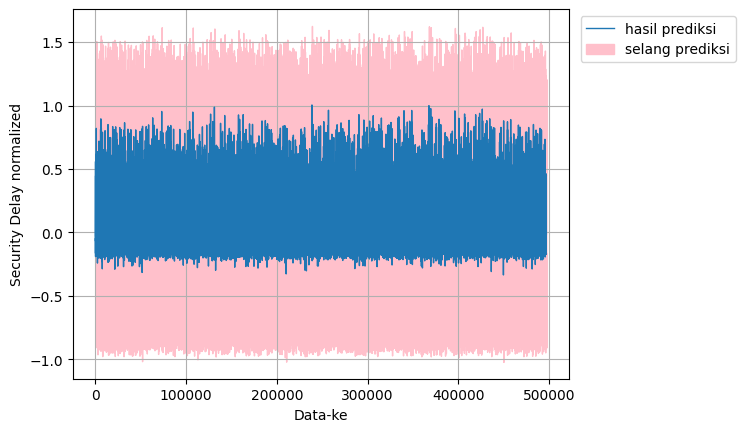

In [ ]:
# Plotting

#plt.plot(data_security_target_train, markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 1)
plt.plot(rata_rata_dalam, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1, alpha = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(np.arange(data_security_target_train.shape[0]),
                 rata_rata_dalam[:,0] - 1.96*np.power(variansi_dalam[:,0],0.5),
                 rata_rata_dalam[:,0] + 1.96*np.power(variansi_dalam[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-1,20])
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.ylabel('Security Delay normalized')
plt.xlabel('Data-ke')

In [ ]:
rata_rata_luar, variansi_luar = \
Predict_ARD(data_security_prediktor_test,parameter_akhir, Titik_pusat_basis,rata_rata_basis_prediksi, matriks_kovariansi_basis_prediksi, partisi = 500)

Predict ARD: 100%|██████████| 176/176 [00:28<00:00,  6.22it/s]


In [ ]:
MSE_luar = 0
for i in range(rata_rata_luar.shape[0]) :
  MSE_luar = MSE_luar + (rata_rata_luar[i] - data_security_target_test[0])**2

print("Mean Square Error prediksi = ", MSE_luar)

Mean Square Error prediksi =  [787.41226792]


Text(0.5, 0, 'Data-ke')

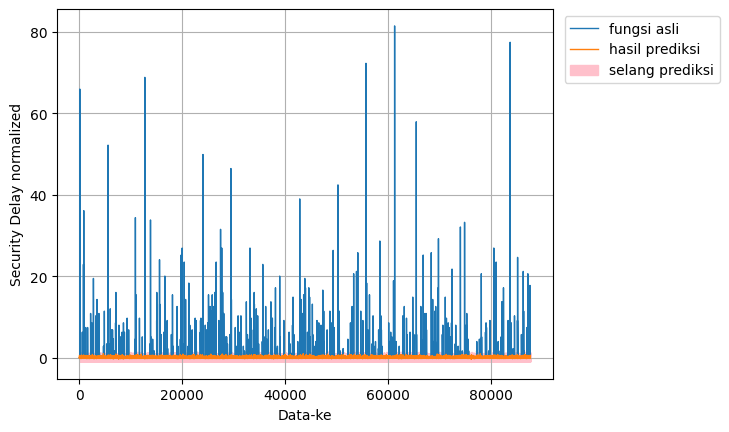

In [ ]:
# Plotting

plt.plot(data_security_target_test, markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 1)
plt.plot(rata_rata_luar, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1, alpha = 1)
#plt.plot(Titik_pusat_basis, [0 for i in range(len(Titik_pusat_basis))], 'ro',
#         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis")
plt.fill_between(np.arange(data_security_target_test.shape[0]),
                 rata_rata_luar[:,0] - 1.96*np.power(variansi_luar[:,0],0.5),
                 rata_rata_luar[:,0] + 1.96*np.power(variansi_luar[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-1,20])
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.ylabel('Security Delay normalized')
plt.xlabel('Data-ke')

In [ ]:
rata_rata_unnormalized = rata_rata_dalam*standar_deviasi_security[6] + rata_rata_security[6]
variansi_unnormalized = variansi_dalam*standar_deviasi_security[6] + standar_deviasi_security[6]

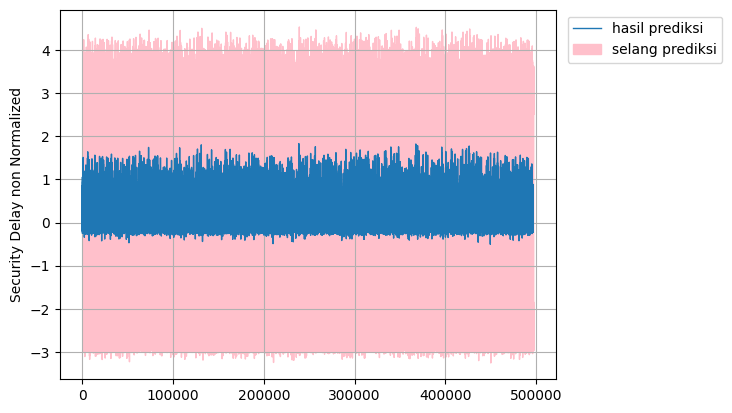

In [ ]:
#plt.plot(data_security['SecurityDelay'], 'o', markerfacecolor = 'none', linewidth = 1, label = "fungsi asli", alpha = 0.1)
plt.plot(rata_rata_unnormalized, markerfacecolor = 'none', label = "hasil prediksi", linewidth = 1)
plt.fill_between(np.arange(data_security_target_train.shape[0]),
                 rata_rata_unnormalized[:,0] - 1.96*np.power(variansi_unnormalized[:,0],0.5),
                 rata_rata_unnormalized[:,0] + 1.96*np.power(variansi_unnormalized[:,0],0.5),
                 color = "pink", label = "selang prediksi", alpha = 1)
plt.grid()
#plt.hlines(0,5,15, color = 'black', alpha = 0.5)
#plt.ylim([-5,30])
plt.ylabel('Security Delay non Normalized')
plt.legend(bbox_to_anchor=(1.35, 1.0))

# *Testing Space*

In [ ]:
A = np.array([[i+j for j in range(10)] for i in range(10)])
B = np.array([[i-j for j in range(10)] for i in range(10)])
print(A)
print(B)

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 1  2  3  4  5  6  7  8  9 10]
 [ 2  3  4  5  6  7  8  9 10 11]
 [ 3  4  5  6  7  8  9 10 11 12]
 [ 4  5  6  7  8  9 10 11 12 13]
 [ 5  6  7  8  9 10 11 12 13 14]
 [ 6  7  8  9 10 11 12 13 14 15]
 [ 7  8  9 10 11 12 13 14 15 16]
 [ 8  9 10 11 12 13 14 15 16 17]
 [ 9 10 11 12 13 14 15 16 17 18]]
[[ 0 -1 -2 -3 -4 -5 -6 -7 -8 -9]
 [ 1  0 -1 -2 -3 -4 -5 -6 -7 -8]
 [ 2  1  0 -1 -2 -3 -4 -5 -6 -7]
 [ 3  2  1  0 -1 -2 -3 -4 -5 -6]
 [ 4  3  2  1  0 -1 -2 -3 -4 -5]
 [ 5  4  3  2  1  0 -1 -2 -3 -4]
 [ 6  5  4  3  2  1  0 -1 -2 -3]
 [ 7  6  5  4  3  2  1  0 -1 -2]
 [ 8  7  6  5  4  3  2  1  0 -1]
 [ 9  8  7  6  5  4  3  2  1  0]]


## Coba-coba

### Percobaan Pertama; pakai `sklearn`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.cluster import KMeans

In [ ]:
def fungsi_sinus(x):
  return np.sin(x) + np.sin(4 * x)

In [ ]:
# membangun data sintetis
banyak_data_train = 1000
prediktor_train = np.linspace(-5, 5, banyak_data_train).reshape(-1, 1)
target_train = fungsi_sinus(prediktor_train) + np.random.normal(0, 1, banyak_data_train).reshape(-1, 1)

In [ ]:
# mencari titik pusat dengan K-Means
banyak_basis = 10
cluster = KMeans(n_clusters = banyak_basis, random_state = 10, n_init = 10).fit(prediktor_train)
titik_pusat_basis = cluster.cluster_centers_
titik_pusat_basis.shape

(10, 1)

In [ ]:
# menggunakan Gaussian Process Regression dari sklearn

# GPR pada sklearn mengarah pada algoritma 1
# buku: C. E. Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning
kernel = ConstantKernel(1.0) * RBF(length_scale = np.ones(prediktor_train.shape[1]))
gpr = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 50, alpha = 0.01)
gpr.fit(prediktor_train, target_train)

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=50)

In [ ]:
# memprediksi target
rata_rata_prediksi, std_prediksi = gpr.predict(prediktor_train, return_std = True)

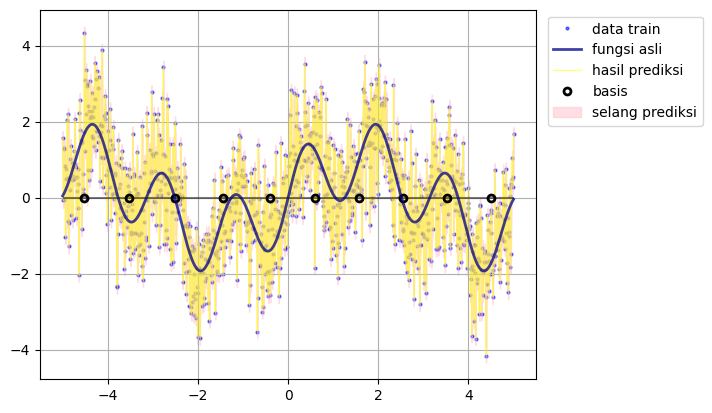

In [ ]:
# plotting
plt.plot(prediktor_train, target_train, 'o', markersize = 2, label = "data train", alpha = 0.55, zorder = 1, color = "blue")
plt.plot(prediktor_train, fungsi_sinus(prediktor_train), linewidth = 2,
         label = "fungsi asli", alpha = 0.75, zorder = 4, color = "darkblue")
plt.plot(prediktor_train, rata_rata_prediksi,  label = "hasil prediksi", linewidth = 1,
         alpha = 0.50, zorder = 2, color = "yellow")
plt.plot(titik_pusat_basis, [0 for _ in range(len(titik_pusat_basis))], 'o', zorder = 3,
         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis", color = "black")
plt.fill_between(prediktor_train[:, 0],
                 rata_rata_prediksi - 1.96 * std_prediksi,
                 rata_rata_prediksi + 1.96 * std_prediksi,
                 color = "pink", label = "selang prediksi", alpha = 0.5)
plt.grid()
plt.hlines(0, -5, 5, color = "black", alpha = 0.5)
plt.legend(bbox_to_anchor = (1.35, 1.0))
plt.show()

### Percobaan Kedua; pakai `wesselb/gpar`

In [ ]:
!pip install git+https://github.com/wesselb/gpar.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.0/708.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 

In [ ]:
# ketentuan package berbeda dengan colab
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from gpar.regression import GPARRegressor

In [ ]:
def fungsi_sinus(x):
  return np.sin(x) + np.sin(4 * x)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# membangun data sintetis
banyak_data_train = 1000
prediktor_train = np.linspace(-5, 5, banyak_data_train).reshape(-1, 1)
target_train = fungsi_sinus(prediktor_train) + np.random.normal(0, 1, banyak_data_train).reshape(-1, 1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# mencari titik pusat dengan K-Means
banyak_basis = 10
cluster = KMeans(n_clusters = banyak_basis, random_state = 10, n_init = 10).fit(prediktor_train)
titik_pusat_basis = cluster.cluster_centers_

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# pelatihan model GPARRegressor
model = GPARRegressor(scale = 0.1, linear = True)
model.fit(prediktor_train, target_train)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training conditionals (total: 1): 1


In [ ]:
# melakukan prediksi
means, lowers, uppers = model.predict(prediktor_train, num_samples = 50,
                                      credible_bounds = True, latent = True)

Sampling (total: 50): 1

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


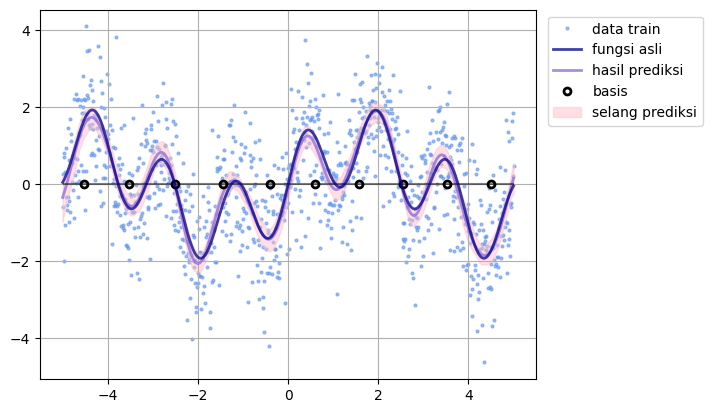

In [ ]:
# plotting
plt.plot(prediktor_train, target_train, 'o', markersize = 2, label = "data train",
         alpha = 0.6, zorder = 1, color = "cornflowerblue")
plt.plot(prediktor_train, fungsi_sinus(prediktor_train), linewidth = 2,
         label = "fungsi asli", alpha = 0.75, zorder = 4, color = "darkblue")
plt.plot(prediktor_train, means[:, 0], label = "hasil prediksi", linewidth = 2,
         alpha = 0.8, zorder = 2, color = "mediumpurple")
plt.plot(titik_pusat_basis, [0 for _ in range(len(titik_pusat_basis))], 'o', zorder = 3,
         markeredgewidth = 2, markerfacecolor = 'none', markersize = 5, label = "basis", color = "black")
plt.fill_between(prediktor_train[:, 0], lowers[:, 0], uppers[:, 0],
                 color = "pink", label = "selang prediksi", alpha = 0.5)

plt.grid()
plt.hlines(0, -5, 5, color = "black", alpha = 0.5)
plt.legend(bbox_to_anchor = (1.35, 1.0))
plt.show()